In [1]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import KFold, TimeSeriesSplit
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc

# Funcs

In [3]:
def num_cat(df):
    '''
    Функция возвращает куски исходного датафрейма. Куски состоят из категориальных фич и из числовых
    '''
    categorical_features = df.select_dtypes(include = ["object"]).columns
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    if 'target' in numerical_features:
        numerical_features = numerical_features.drop('target')
    print("Numerical features : " + str(len(numerical_features)))
    
    print("Categorical features : " + str(len(categorical_features)))

    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    return df_num, df_cat
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 
def fast_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def fast_estimation(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))
    oof_list = []
    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
#         print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        
        oof_list.append(roc_auc_score(y.iloc[test_idx], oof[test_idx]))
        
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

#         print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
#     print('Training has finished.')
#     print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

#     feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


#     plt.figure(figsize=(16, 16))
#     sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
#     plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return roc_auc_score(y, oof)

def submission_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def outliers(i, df, col):
    scaled = StandardScaler().fit_transform(df[col].dropna()[:, np.newaxis])
    
    low_range = scaled[scaled[:,0].argsort()][:10]
    high_range= scaled[scaled[:,0].argsort()][-10:]
    if len(np.unique(low_range)) >= 2 or len(np.unique(high_range)) >= 2:
        print(i, col)
        print('outer range (low) of the distribution:')
        print(low_range)
        print('\nouter range (high) of the distribution:')
        print(high_range)
        print('\n')

        return col, (high_range[-1]/high_range[0])[0], (low_range[-1]/low_range[0])[0]
def kde_target(var_name, df):    
    corr = df['isFraud'].corr(df[var_name])
    avg_repaid = df.loc[df['isFraud'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['isFraud'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 9))
    
    sns.kdeplot(df.loc[df['isFraud'] == 0, var_name], label = 'isFraud == 0')
    sns.kdeplot(df.loc[df['isFraud'] == 1, var_name], label = 'isFraud == 1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    print('The correlation between %s and the isFraud is %0.4f' % (var_name, corr))
def check_outliers(flag, df, col):
    if flag == 'train':
        sns.distplot(df[col].dropna())
        kde_target(col, df)
    
    else:
        pass        
    return df[col].value_counts().sort_index()

def time_series_validation(X, y, params):
    folds = TimeSeriesSplit(n_splits=5)

    aucs = list()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
        clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)

        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
        aucs.append(clf.best_score['valid_1']['auc'])

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('Mean AUC:', np.mean(aucs))
    print('-' * 30)

# Read data

##### прочитать данные с нуля

In [174]:
# folder_path = '../input/'
# subm = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/sample_submission.csv'))

# te_id = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/test_identity.csv'))
# te_tr = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/test_transaction.csv'))
# tr_id = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/train_identity.csv'))
# tr_tr = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/train_transaction.csv'))
sub = reduce_memory_usage(pd.read_csv(f'input/sample_submission.csv'))
# test_id = reduce_memory_usage(pd.read_csv(f'../ieee/input/test_identity.csv'))
# test_tr = reduce_memory_usage(pd.read_csv(f'../ieee/input/test_transaction.csv'))
# train_id = reduce_memory_usage(pd.read_csv(f'../ieee/input/train_identity.csv'))
# train_tr = reduce_memory_usage(pd.read_csv(f'../ieee/input/train_transaction.csv'))

# files = ['input/ieee-fraud-detection/test_identity.csv', 
#          'input/ieee-fraud-detection/test_transaction.csv',
#          'input/ieee-fraud-detection/train_identity.csv',
#          'input/ieee-fraud-detection/train_transaction.csv',
#          'input/ieee-fraud-detection/sample_submission.csv']

Memory usage: Before|7.73 MB || After|2.90 MB || Decreased|62.5%


In [9]:
# files = ['ieee/test_identity.csv', 
#          'ieee/test_transaction.csv',
#          'ieee/train_identity.csv',
#          'ieee/train_transaction.csv',
#          'ieee/sample_submission.csv']
files = ['input/test_identity.csv', 
         'input/test_transaction.csv',
         'input/train_identity.csv',
         'input/train_transaction.csv',
         'input/sample_submission.csv']

def load_data(file):
    return pd.read_csv(file)

test_id, test_tr, train_id, train_tr, sub = map(load_data, files)

In [10]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

39

In [11]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

NameError: name 'reduce_memory_usage' is not defined

In [ ]:
tr_num, tr_cat = num_cat(train)
te_num, te_cat = num_cat(test)

In [ ]:
import pickle
with open('train.pickle', 'wb') as handle:
    b = pickle.dump(train, handle)
with open('test.pickle', 'wb') as handle:
    b = pickle.dump(test, handle)

# train+test from pickle

In [2]:
with open('train.pickle', 'rb') as handle:
    train = pickle.load(handle)
with open('test.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Features

In [4]:
start_date = '2017-12-01' 
startdate = datetime.datetime.strptime(start_date, "%Y-%m-%d") 

for dataset in (train, test): 
    dataset['Date'] = dataset['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x))) 
    dataset['Weekdays'] = dataset['Date'].dt.dayofweek 
    dataset['Hours'] = dataset['Date'].dt.hour 
    dataset['Days'] = dataset['Date'].dt.day 
    dataset['isNight'] = dataset['Hours'].map(lambda x: 1 if (x >= 23 or x < 5) else 0)

    dataset['DT_M'] = (dataset['Date'].dt.year-2017)*12 + dataset['Date'].dt.month
    dataset['DT_W'] = (dataset['Date'].dt.year-2017)*52 + dataset['Date'].dt.weekofyear
    dataset['DT_D'] = (dataset['Date'].dt.year-2017)*365 + dataset['Date'].dt.dayofyear


train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

train['nulls1'] = train.isna().sum(axis=1)
test['nulls1'] = test.isna().sum(axis=1)

a = np.zeros(train.shape[0])
train["lastest_browser"] = a
a = np.zeros(test.shape[0])
test["lastest_browser"] = a

def browser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=browser(train)
test=browser(test)

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 
          'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 
          'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other',
          'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com':
          'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 
          'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
          'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0].astype(str)
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1].astype(str)

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0].astype(str)
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1].astype(str)

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0].astype(str)
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1].astype(str)

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0].astype(str)
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1].astype(str)

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1].astype(str)
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1].astype(str)

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

train = id_split(train)
test = id_split(test)

train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# Count encoding for card1 feature. 
# Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
    

useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']



# for feature in ['id_34', 'id_36']:
#     if feature in useful_features:
#         # Count encoded for both train and test
#         train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
#         test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    if feature in useful_features:
        # Count encoded separately for train and test
        train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))
        

In [5]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))

train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))

train['card6_count_full'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
test['card6_count_full'] = test['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))


train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))

category_features=["ProductCD","P_emaildomain",
                   "R_emaildomain","M1","M2","M3","M4","M5","M6","M7","M8","M9","DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_32","id_34", 'id_36'
                   "id_37","id_38"]
for c in category_features:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

In [6]:
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train[[col]], test[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)

    train[col] = np.where(train[col].isin(valid_card), train[col], np.nan)
    test[col]  = np.where(test[col].isin(valid_card), test[col], np.nan)

In [7]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)
del df

In [8]:
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean']  = test[col].map(temp_dict)

In [9]:
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

In [10]:
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

In [11]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)
           

In [12]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo',
          'id_30',
#           'id_30_device',
          'version_id_30',
          'version_id_31',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [13]:
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [14]:
n, c = num_cat(train)

Numerical features : 538
Categorical features : 46


In [16]:
c.columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'device_name', 'device_version', 'OS_id_30',
       'version_id_30', 'browser_id_31', 'version_id_31', 'screen_width',
       'screen_height', 'uid', 'uid2', 'uid3'],
      dtype='object')

In [35]:
for f in train.columns:
    if  train[f].dtype=='object': 
        train[f] = train[f].replace("nan", "other")
        train[f] = train[f].replace(np.nan, "other")
        test[f] = test[f].replace("nan", "other")
        test[f] = test[f].replace(np.nan, "other")

        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))  

In [36]:
import pickle
with open('train_09457.pickle', 'wb') as handle:
    b = pickle.dump(train, handle)
with open('test_09457.pickle', 'wb') as handle:
    b = pickle.dump(test, handle)

# features from pickle

In [19]:
with open('train_09457.pickle', 'rb') as handle:
    train = pickle.load(handle)
with open('test_09457.pickle', 'rb') as handle:
    test = pickle.load(handle)

In [5]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
# test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

# X.drop('Date', axis=1, inplace=True)
# test.drop('Date', axis=1, inplace=True)


In [7]:
numerical_features = X.columns

In [8]:
def add_numerical_aggregate(df, target_column, group_column, scoring=True, save=True):
    print(target_column, group_column)
    to_mean = pd.DataFrame()
    to_mean[f'{target_column}_to_mean_{group_column}'] = df[target_column] / df.groupby([group_column])[target_column].transform('mean')
    if scoring:
        new_score = quick_score2(df,categorial_features,addition=to_mean,categorial_features_in_addition=[])
        delta_score = new_score - score
        with open('./hdf/num_agg_scores.csv','a') as f:
            f.write(f'{target_column}_to_mean_{group_column}, {delta_score}\n')
    if save:
        with pd.HDFStore('./hdf/engineering.h5') as store:
            store[f'numerical/{target_column}_to_std_{group_column}'] = to_mean[[f'{target_column}_to_mean_{group_column}']]

    to_std = pd.DataFrame()
    to_std[f'{target_column}_to_std_{group_column}'] = df[target_column] / df.groupby([group_column])[target_column].transform('std')
    if scoring:
        new_score = quick_score2(df,categorial_features,addition=to_std,categorial_features_in_addition=[])
        delta_score = new_score - score
        with open('./hdf/num_agg_scores.csv','a') as f:
            f.write(f'{target_column}_to_std_{group_column}, {delta_score}\n')
    if save:
        with pd.HDFStore('./hdf/engineering.h5') as store:
            store[f'numerical/{target_column}_to_std_{group_column}'] = to_std[[f'{target_column}_to_std_{group_column}']]
    return to_mean.join(to_std)

In [ ]:
# started = False
# for num_feature in numerical_features:
#     if not started and num_feature != 'V1':
#         continue
#     started = True
#     for cat_feature in ['uid2']:
#         try:
#             add_numerical_aggregate(X, num_feature, cat_feature, scoring=False,save=False)
#         except Exception as ex:
#             print('Exception', ex)

In [9]:
num_aggs = []
# started = False
for i,num_feature in enumerate(numerical_features):
#     if not started and num_feature != 'V266':
#         continue
#     started=
    for cat_feature in ['uid2']:
        try:
            agg_new = add_numerical_aggregate(X,num_feature, cat_feature,scoring=False, save=False)
            num_aggs.append(agg_new)
        except Exception as ex:
            print('Exception', ex)
            

num_agg = pd.concat(num_aggs,axis=1)
X_num_agg = X.join(num_agg)
X_num_agg.drop('Date', axis=1, inplace=True)

TransactionAmt uid2
ProductCD uid2
card1 uid2
card2 uid2
card3 uid2
card4 uid2
card5 uid2
card6 uid2
addr1 uid2
addr2 uid2
dist1 uid2
dist2 uid2
P_emaildomain uid2
R_emaildomain uid2
C1 uid2
C2 uid2
C3 uid2
C4 uid2
C5 uid2
C6 uid2
C7 uid2
C8 uid2
C9 uid2
C10 uid2
C11 uid2
C12 uid2
C13 uid2
C14 uid2
D1 uid2
D2 uid2
D3 uid2
D4 uid2
D5 uid2
D6 uid2
D7 uid2
D8 uid2
D9 uid2
D10 uid2
D11 uid2
D12 uid2
D13 uid2
D14 uid2
D15 uid2
M1 uid2
M2 uid2
M3 uid2
M4 uid2
M5 uid2
M6 uid2
M7 uid2
M8 uid2
M9 uid2
V1 uid2
V2 uid2
V3 uid2
V4 uid2
V5 uid2
V6 uid2
V7 uid2
V8 uid2
V9 uid2
V10 uid2
V11 uid2
V12 uid2
V13 uid2
V14 uid2
V15 uid2
V16 uid2
V17 uid2
V18 uid2
V19 uid2
V20 uid2
V21 uid2
V22 uid2
V23 uid2
V24 uid2
V25 uid2
V26 uid2
V27 uid2
V28 uid2
V29 uid2
V30 uid2
V31 uid2
V32 uid2
V33 uid2
V34 uid2
V35 uid2
V36 uid2
V37 uid2
V38 uid2
V39 uid2
V40 uid2
V41 uid2
V42 uid2
V43 uid2
V44 uid2
V45 uid2
V46 uid2
V47 uid2
V48 uid2
V49 uid2
V50 uid2
V51 uid2
V52 uid2
V53 uid2
V54 uid2
V55 uid2
V56 uid2
V57 uid

In [10]:
X_num_agg.dropna(how='all', axis=1, inplace=True)

In [11]:
many_same_values_columns_train = [c for c in X_num_agg.columns if X_num_agg[c].value_counts(normalize=True).values[0] > 0.998]


In [12]:
many_same_values_columns_train

['V1',
 'V14',
 'V27',
 'V28',
 'V41',
 'V65',
 'V68',
 'V88',
 'V89',
 'V107',
 'V117',
 'V118',
 'V119',
 'V120',
 'V240',
 'V241',
 'V305',
 'had_id',
 'M_sum',
 'card1_to_mean_uid2',
 'card1_to_std_uid2',
 'card2_to_mean_uid2',
 'card2_to_std_uid2',
 'card3_to_mean_uid2',
 'card3_to_std_uid2',
 'card4_to_mean_uid2',
 'card4_to_std_uid2',
 'had_id_to_mean_uid2',
 'had_id_to_std_uid2',
 'card2_count_full_to_mean_uid2',
 'card2_count_full_to_std_uid2',
 'card3_count_full_to_mean_uid2',
 'card3_count_full_to_std_uid2',
 'card4_count_full_to_mean_uid2',
 'card4_count_full_to_std_uid2',
 'uid_to_mean_uid2',
 'uid_to_std_uid2',
 'uid2_to_mean_uid2',
 'uid2_to_std_uid2',
 'card1_TransactionAmt_mean_to_mean_uid2',
 'card1_TransactionAmt_mean_to_std_uid2',
 'card1_TransactionAmt_std_to_mean_uid2',
 'card1_TransactionAmt_std_to_std_uid2',
 'card2_TransactionAmt_mean_to_mean_uid2',
 'card2_TransactionAmt_mean_to_std_uid2',
 'card2_TransactionAmt_std_to_mean_uid2',
 'card2_TransactionAmt_std_to

In [68]:
X_num_agg.drop(many_same_values_columns_train, axis=1, inplace=True)

# RFE

In [ ]:
from sklearn.feature_selection import RFECV

with open('train_09457_with_additions.pkl', 'rb') as handle:
    addtrain = pickle.load(handle)
with open('test_09457_with_additions.pkl', 'rb') as handle:
    addtest = pickle.load(handle)

X = addtrain.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y = addtrain.sort_values('TransactionDT')['isFraud']

X.fillna(-999, inplace=True)

In [9]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 0,
          'n_jobs': -1
         }

In [5]:
X.drop('Date', axis=1, inplace=True)

In [6]:
X.replace(np.inf, np.nan, inplace=True)
X.replace(-np.inf, np.nan, inplace=True)

X.fillna(-999, inplace=True)

In [7]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [13]:
rfe.fit(X, y)

Fitting estimator with 638 features.
Fitting estimator with 628 features.
Fitting estimator with 618 features.
Fitting estimator with 608 features.
Fitting estimator with 598 features.
Fitting estimator with 588 features.
Fitting estimator with 578 features.
Fitting estimator with 568 features.
Fitting estimator with 558 features.


OSError: exception: access violation reading 0x0000000000000248

In [11]:
rfe

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_we...=0.03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=1, num_leaves=491,
                               objective='binary', random_state=0,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsam

In [12]:
rfe.grid_scores_

AttributeError: 'RFECV' object has no attribute 'grid_scores_'

In [ ]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

# Feature importance & correlation

In [69]:
df_num_corr = X_num_agg.corr()
df_num_corr_0_8 = df_num_corr.where(df_num_corr>0.8).copy()

for i in df_num_corr.index:
    j = i
    df_num_corr_0_8.loc[i, j] = np.nan
    
df_num_corr_0_8 = df_num_corr_0_8.where(df_num_corr>0.8).dropna(how='all', axis=0).copy()
df_num_corr_0_8.dropna(how='all', axis=1, inplace=True)

df_num_corrs = pd.DataFrame(columns = ['var1', 'var2', 'corr'])

for k, i in enumerate(df_num_corr_0_8.index):
    for j in df_num_corr_0_8.columns[k:]:
        if df_num_corr_0_8.loc[i, j] > 0:
            df_temp = pd.DataFrame(columns = ['var1', 'var2', 'corr'], data = [[i, j, df_num_corr_0_8.loc[i, j]]])
            df_num_corrs = df_num_corrs.append(df_temp, ignore_index=True)
df_num_corrs.sort_values(by='corr', inplace=True, ascending=False)

In [96]:
df_num_corrs.sort_values(by='corr', inplace=True, ascending=False)

In [97]:
df_num_corrs

,var1,var2,corr
6357,TransactionAmt_to_mean_card4_to_mean_uid2,TransactionAmt_to_std_card4_to_mean_uid2,1.000000
4425,D15_to_std_uid2,D15_to_mean_card4_to_std_uid2,1.000000
6334,D15_to_mean_card4_to_std_uid2,D15_to_std_card4_to_std_uid2,1.000000
6314,id_02_to_mean_card4_to_mean_uid2,id_02_to_std_card4_to_mean_uid2,1.000000
4419,D15_to_mean_uid2,D15_to_mean_card4_to_mean_uid2,1.000000
4427,D15_to_std_uid2,D15_to_std_card4_to_std_uid2,1.000000
6299,Hours_to_mean_uid2,Transaction_hour_to_mean_uid2,1.000000
6513,addr1_count_full_to_std_uid2,addr1_fq_enc_to_std_uid2,1.000000
5981,id_02_to_mean_uid2,id_02_to_mean_card4_to_mean_uid2,1.000000
6512,addr1_count_full_to_mean_uid2,addr1_fq_enc_to_mean_uid2,1.000000


In [85]:
def individual_roc(i, df,y,  feature):
    print(i, ' feature: ', feature)
    df.replace(np.inf, np.nan, inplace=True)
    df.replace(-np.inf, np.nan, inplace=True)
    df = df.fillna(-9999999)
    
    
    if df[feature].dtypes == 'O':
        x = pd.get_dummies(df[feature]).values
        obvious_roc = 0
    else:
#         print('\t  Counting obvious roc...')
        x = df[feature].values.reshape(-1, 1)    
        obvious_roc = round(abs(roc_auc_score(y, x)), 3)

#     print('\t  Now count roc using decision tree')    
    parameters = {'min_weight_fraction_leaf': [0.01, 0.025, 0.05, 0.1]}
    param_dist = {'min_weight_fraction_leaf': np.random.uniform(0.001, 0.1, 4) }
    dt = DecisionTreeClassifier(random_state=1)
        
    cv = StratifiedKFold(3, random_state=1)
    clf = GridSearchCV(dt, parameters,cv=cv,scoring='roc_auc', n_jobs=30)
    print('\t  Run grid search...')
#     clf = RandomizedSearchCV(dt, param_distributions=param_dist, cv=cv, verbose=0, n_jobs=10, scoring='roc_auc')
    clf.fit(x, y)
    
    true_roc = round(abs(clf.best_score_), 3)
    print('\t  True roc is ', true_roc)
    print('\t  Clf is fitted!\n-------------------------------------------')
    
    return max(obvious_roc, true_roc), obvious_roc, true_roc, obvious_roc > true_roc

In [84]:
X_num_agg['D15_to_std_card1'].fillna(-999999)

0              0.000000
1              0.000000
2              1.851016
3              0.520531
4        -999999.000000
5              0.000000
6              0.000000
7              0.000000
8        -999999.000000
9              1.717691
10             0.000000
11             0.000000
12             0.637609
13             0.212695
14             0.000000
15             0.000000
16       -999999.000000
17       -999999.000000
18             0.000000
19             0.327323
20             0.000000
21             0.868277
22       -999999.000000
23             0.000000
24             0.343685
25             0.122220
26             1.087801
27             0.000000
28             0.000000
29             0.000000
              ...      
590510         0.000000
590511         2.136807
590512         0.000000
590513         3.491668
590514         1.988107
590515         2.321625
590516         0.296532
590517         0.000000
590518         1.067016
590519         0.408075
590520         2

In [87]:
df_roc = pd.DataFrame(index = X_num_agg.columns.values, columns = ['max_roc', 'obvious', 'true_roc', 'obvious_is_max'])

for i, col in enumerate(X_num_agg.columns):
    roc = individual_roc(i, X_num_agg, y, col)
    df_roc.loc[[col], ['max_roc', 'obvious', 'true_roc', 'obvious_is_max']] = roc

0  feature:  TransactionAmt
	  Run grid search...
	  True roc is  0.649
	  Clf is fitted!
-------------------------------------------
1  feature:  ProductCD
	  Run grid search...
	  True roc is  0.679
	  Clf is fitted!
-------------------------------------------
2  feature:  card1
	  Run grid search...
	  True roc is  0.634
	  Clf is fitted!
-------------------------------------------
3  feature:  card2
	  Run grid search...
	  True roc is  0.672
	  Clf is fitted!
-------------------------------------------
4  feature:  card3
	  Run grid search...
	  True roc is  0.639
	  Clf is fitted!
-------------------------------------------
5  feature:  card4
	  Run grid search...
	  True roc is  0.499
	  Clf is fitted!
-------------------------------------------
6  feature:  card5
	  Run grid search...
	  True roc is  0.639
	  Clf is fitted!
-------------------------------------------
7  feature:  card6
	  Run grid search...
	  True roc is  0.619
	  Clf is fitted!
-------------------------------

	  Run grid search...
	  True roc is  0.668
	  Clf is fitted!
-------------------------------------------
67  feature:  V19
	  Run grid search...
	  True roc is  0.554
	  Clf is fitted!
-------------------------------------------
68  feature:  V20
	  Run grid search...
	  True roc is  0.558
	  Clf is fitted!
-------------------------------------------
69  feature:  V21
	  Run grid search...
	  True roc is  0.666
	  Clf is fitted!
-------------------------------------------
70  feature:  V22
	  Run grid search...
	  True roc is  0.666
	  Clf is fitted!
-------------------------------------------
71  feature:  V23
	  Run grid search...
	  True roc is  0.572
	  Clf is fitted!
-------------------------------------------
72  feature:  V24
	  Run grid search...
	  True roc is  0.571
	  Clf is fitted!
-------------------------------------------
73  feature:  V25
	  Run grid search...
	  True roc is  0.533
	  Clf is fitted!
-------------------------------------------
74  feature:  V26
	  Run g

	  Run grid search...
	  True roc is  0.627
	  Clf is fitted!
-------------------------------------------
133  feature:  V92
	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
134  feature:  V93
	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
135  feature:  V94
	  Run grid search...
	  True roc is  0.687
	  Clf is fitted!
-------------------------------------------
136  feature:  V95
	  Run grid search...
	  True roc is  0.584
	  Clf is fitted!
-------------------------------------------
137  feature:  V96
	  Run grid search...
	  True roc is  0.526
	  Clf is fitted!
-------------------------------------------
138  feature:  V97
	  Run grid search...
	  True roc is  0.582
	  Clf is fitted!
-------------------------------------------
139  feature:  V98
	  Run grid search...
	  True roc is  0.517
	  Clf is fitted!
-------------------------------------------
140  feature:  V99


	  True roc is  0.527
	  Clf is fitted!
-------------------------------------------
198  feature:  V166
	  Run grid search...
	  True roc is  0.527
	  Clf is fitted!
-------------------------------------------
199  feature:  V167
	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
200  feature:  V168
	  Run grid search...
	  True roc is  0.677
	  Clf is fitted!
-------------------------------------------
201  feature:  V169
	  Run grid search...
	  True roc is  0.657
	  Clf is fitted!
-------------------------------------------
202  feature:  V170
	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
203  feature:  V171
	  Run grid search...
	  True roc is  0.676
	  Clf is fitted!
-------------------------------------------
204  feature:  V172
	  Run grid search...
	  True roc is  0.655
	  Clf is fitted!
-------------------------------------------
205  feature:  V173
	  Run grid se

263  feature:  V231
	  Run grid search...
	  True roc is  0.661
	  Clf is fitted!
-------------------------------------------
264  feature:  V232
	  Run grid search...
	  True roc is  0.663
	  Clf is fitted!
-------------------------------------------
265  feature:  V233
	  Run grid search...
	  True roc is  0.662
	  Clf is fitted!
-------------------------------------------
266  feature:  V234
	  Run grid search...
	  True roc is  0.661
	  Clf is fitted!
-------------------------------------------
267  feature:  V235
	  Run grid search...
	  True roc is  0.648
	  Clf is fitted!
-------------------------------------------
268  feature:  V236
	  Run grid search...
	  True roc is  0.65
	  Clf is fitted!
-------------------------------------------
269  feature:  V237
	  Run grid search...
	  True roc is  0.649
	  Clf is fitted!
-------------------------------------------
270  feature:  V238
	  Run grid search...
	  True roc is  0.659
	  Clf is fitted!
-------------------------------------

	  Run grid search...
	  True roc is  0.518
	  Clf is fitted!
-------------------------------------------
329  feature:  V299
	  Run grid search...
	  True roc is  0.515
	  Clf is fitted!
-------------------------------------------
330  feature:  V300
	  Run grid search...
	  True roc is  0.513
	  Clf is fitted!
-------------------------------------------
331  feature:  V301
	  Run grid search...
	  True roc is  0.517
	  Clf is fitted!
-------------------------------------------
332  feature:  V302
	  Run grid search...
	  True roc is  0.658
	  Clf is fitted!
-------------------------------------------
333  feature:  V303
	  Run grid search...
	  True roc is  0.662
	  Clf is fitted!
-------------------------------------------
334  feature:  V304
	  Run grid search...
	  True roc is  0.661
	  Clf is fitted!
-------------------------------------------
335  feature:  V306
	  Run grid search...
	  True roc is  0.581
	  Clf is fitted!
-------------------------------------------
336  feature

	  True roc is  0.5
	  Clf is fitted!
-------------------------------------------
394  feature:  id_26
	  Run grid search...
	  True roc is  0.5
	  Clf is fitted!
-------------------------------------------
395  feature:  id_27
	  Run grid search...
	  True roc is  0.5
	  Clf is fitted!
-------------------------------------------
396  feature:  id_28
	  Run grid search...
	  True roc is  0.668
	  Clf is fitted!
-------------------------------------------
397  feature:  id_29
	  Run grid search...
	  True roc is  0.669
	  Clf is fitted!
-------------------------------------------
398  feature:  id_30
	  Run grid search...
	  True roc is  0.51
	  Clf is fitted!
-------------------------------------------
399  feature:  id_31
	  Run grid search...
	  True roc is  0.664
	  Clf is fitted!
-------------------------------------------
400  feature:  id_32
	  Run grid search...
	  True roc is  0.525
	  Clf is fitted!
-------------------------------------------
401  feature:  id_33
	  Run grid s

	  True roc is  0.677
	  Clf is fitted!
-------------------------------------------
455  feature:  card1__card5
	  Run grid search...
	  True roc is  0.634
	  Clf is fitted!
-------------------------------------------
456  feature:  card2__id_20
	  Run grid search...
	  True roc is  0.674
	  Clf is fitted!
-------------------------------------------
457  feature:  card5__P_emaildomain
	  Run grid search...
	  True roc is  0.654
	  Clf is fitted!
-------------------------------------------
458  feature:  addr1__card1
	  Run grid search...
	  True roc is  0.669
	  Clf is fitted!
-------------------------------------------
459  feature:  id_36_count_full
	  Run grid search...
	  True roc is  0.658
	  Clf is fitted!
-------------------------------------------
460  feature:  id_01_count_dist
	  Run grid search...
	  True roc is  0.671
	  Clf is fitted!
-------------------------------------------
461  feature:  id_31_count_dist
	  Run grid search...
	  True roc is  0.663
	  Clf is fitted!
--

	  True roc is  0.632
	  Clf is fitted!
-------------------------------------------
515  feature:  D7_fq_enc
	  Run grid search...
	  True roc is  0.613
	  Clf is fitted!
-------------------------------------------
516  feature:  D8_fq_enc
	  Run grid search...
	  True roc is  0.637
	  Clf is fitted!
-------------------------------------------
517  feature:  addr1_fq_enc
	  Run grid search...
	  True roc is  0.665
	  Clf is fitted!
-------------------------------------------
518  feature:  addr2_fq_enc
	  Run grid search...
	  True roc is  0.644
	  Clf is fitted!
-------------------------------------------
519  feature:  dist1_fq_enc
	  Run grid search...
	  True roc is  0.596
	  Clf is fitted!
-------------------------------------------
520  feature:  dist2_fq_enc
	  Run grid search...
	  True roc is  0.561
	  Clf is fitted!
-------------------------------------------
521  feature:  P_emaildomain_fq_enc
	  Run grid search...
	  True roc is  0.585
	  Clf is fitted!
--------------------

575  feature:  C1_to_mean_uid2
	  Run grid search...
	  True roc is  0.588
	  Clf is fitted!
-------------------------------------------
576  feature:  C1_to_std_uid2
	  Run grid search...
	  True roc is  0.582
	  Clf is fitted!
-------------------------------------------
577  feature:  C2_to_mean_uid2
	  Run grid search...
	  True roc is  0.606
	  Clf is fitted!
-------------------------------------------
578  feature:  C2_to_std_uid2
	  Run grid search...
	  True roc is  0.59
	  Clf is fitted!
-------------------------------------------
579  feature:  C3_to_mean_uid2
	  Run grid search...
	  True roc is  0.541
	  Clf is fitted!
-------------------------------------------
580  feature:  C3_to_std_uid2
	  Run grid search...
	  True roc is  0.541
	  Clf is fitted!
-------------------------------------------
581  feature:  C4_to_mean_uid2
	  Run grid search...
	  True roc is  0.685
	  Clf is fitted!
-------------------------------------------
582  feature:  C4_to_std_uid2
	  Run grid sea

	  Run grid search...
	  True roc is  0.701
	  Clf is fitted!
-------------------------------------------
636  feature:  M2_to_std_uid2
	  Run grid search...
	  True roc is  0.688
	  Clf is fitted!
-------------------------------------------
637  feature:  M3_to_mean_uid2
	  Run grid search...
	  True roc is  0.702
	  Clf is fitted!
-------------------------------------------
638  feature:  M3_to_std_uid2
	  Run grid search...
	  True roc is  0.69
	  Clf is fitted!
-------------------------------------------
639  feature:  M4_to_mean_uid2
	  Run grid search...
	  True roc is  0.659
	  Clf is fitted!
-------------------------------------------
640  feature:  M4_to_std_uid2
	  Run grid search...
	  True roc is  0.652
	  Clf is fitted!
-------------------------------------------
641  feature:  M5_to_mean_uid2
	  Run grid search...
	  True roc is  0.686
	  Clf is fitted!
-------------------------------------------
642  feature:  M5_to_std_uid2
	  Run grid search...
	  True roc is  0.682
	 

	  Run grid search...
	  True roc is  0.702
	  Clf is fitted!
-------------------------------------------
696  feature:  V23_to_std_uid2
	  Run grid search...
	  True roc is  0.644
	  Clf is fitted!
-------------------------------------------
697  feature:  V24_to_mean_uid2
	  Run grid search...
	  True roc is  0.686
	  Clf is fitted!
-------------------------------------------
698  feature:  V24_to_std_uid2
	  Run grid search...
	  True roc is  0.642
	  Clf is fitted!
-------------------------------------------
699  feature:  V25_to_mean_uid2
	  Run grid search...
	  True roc is  0.638
	  Clf is fitted!
-------------------------------------------
700  feature:  V25_to_std_uid2
	  Run grid search...
	  True roc is  0.626
	  Clf is fitted!
-------------------------------------------
701  feature:  V26_to_mean_uid2
	  Run grid search...
	  True roc is  0.639
	  Clf is fitted!
-------------------------------------------
702  feature:  V26_to_std_uid2
	  Run grid search...
	  True roc is  

	  Run grid search...
	  True roc is  0.704
	  Clf is fitted!
-------------------------------------------
756  feature:  V55_to_std_uid2
	  Run grid search...
	  True roc is  0.652
	  Clf is fitted!
-------------------------------------------
757  feature:  V56_to_mean_uid2
	  Run grid search...
	  True roc is  0.708
	  Clf is fitted!
-------------------------------------------
758  feature:  V56_to_std_uid2
	  Run grid search...
	  True roc is  0.637
	  Clf is fitted!
-------------------------------------------
759  feature:  V57_to_mean_uid2
	  Run grid search...
	  True roc is  0.626
	  Clf is fitted!
-------------------------------------------
760  feature:  V57_to_std_uid2
	  Run grid search...
	  True roc is  0.626
	  Clf is fitted!
-------------------------------------------
761  feature:  V58_to_mean_uid2
	  Run grid search...
	  True roc is  0.627
	  Clf is fitted!
-------------------------------------------
762  feature:  V58_to_std_uid2
	  Run grid search...
	  True roc is  

	  Run grid search...
	  True roc is  0.714
	  Clf is fitted!
-------------------------------------------
816  feature:  V86_to_std_uid2
	  Run grid search...
	  True roc is  0.648
	  Clf is fitted!
-------------------------------------------
817  feature:  V87_to_mean_uid2
	  Run grid search...
	  True roc is  0.717
	  Clf is fitted!
-------------------------------------------
818  feature:  V87_to_std_uid2
	  Run grid search...
	  True roc is  0.629
	  Clf is fitted!
-------------------------------------------
819  feature:  V88_to_mean_uid2
	  Run grid search...
	  True roc is  0.567
	  Clf is fitted!
-------------------------------------------
820  feature:  V88_to_std_uid2
	  Run grid search...
	  True roc is  0.547
	  Clf is fitted!
-------------------------------------------
821  feature:  V89_to_mean_uid2
	  Run grid search...
	  True roc is  0.504
	  Clf is fitted!
-------------------------------------------
822  feature:  V89_to_std_uid2
	  Run grid search...
	  True roc is  

	  Run grid search...
	  True roc is  0.674
	  Clf is fitted!
-------------------------------------------
876  feature:  V116_to_std_uid2
	  Run grid search...
	  True roc is  0.667
	  Clf is fitted!
-------------------------------------------
877  feature:  V117_to_mean_uid2
	  Run grid search...
	  True roc is  0.65
	  Clf is fitted!
-------------------------------------------
878  feature:  V117_to_std_uid2
	  Run grid search...
	  True roc is  0.641
	  Clf is fitted!
-------------------------------------------
879  feature:  V118_to_mean_uid2
	  Run grid search...
	  True roc is  0.643
	  Clf is fitted!
-------------------------------------------
880  feature:  V118_to_std_uid2
	  Run grid search...
	  True roc is  0.641
	  Clf is fitted!
-------------------------------------------
881  feature:  V119_to_mean_uid2
	  Run grid search...
	  True roc is  0.647
	  Clf is fitted!
-------------------------------------------
882  feature:  V119_to_std_uid2
	  Run grid search...
	  True ro

	  Run grid search...
	  True roc is  0.523
	  Clf is fitted!
-------------------------------------------
936  feature:  V146_to_std_uid2
	  Run grid search...
	  True roc is  0.523
	  Clf is fitted!
-------------------------------------------
937  feature:  V147_to_mean_uid2
	  Run grid search...
	  True roc is  0.523
	  Clf is fitted!
-------------------------------------------
938  feature:  V147_to_std_uid2
	  Run grid search...
	  True roc is  0.523
	  Clf is fitted!
-------------------------------------------
939  feature:  V148_to_mean_uid2
	  Run grid search...
	  True roc is  0.52
	  Clf is fitted!
-------------------------------------------
940  feature:  V148_to_std_uid2
	  Run grid search...
	  True roc is  0.518
	  Clf is fitted!
-------------------------------------------
941  feature:  V149_to_mean_uid2
	  Run grid search...
	  True roc is  0.523
	  Clf is fitted!
-------------------------------------------
942  feature:  V149_to_std_uid2
	  Run grid search...
	  True ro

	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
996  feature:  V176_to_std_uid2
	  Run grid search...
	  True roc is  0.665
	  Clf is fitted!
-------------------------------------------
997  feature:  V177_to_mean_uid2
	  Run grid search...
	  True roc is  0.673
	  Clf is fitted!
-------------------------------------------
998  feature:  V177_to_std_uid2
	  Run grid search...
	  True roc is  0.672
	  Clf is fitted!
-------------------------------------------
999  feature:  V178_to_mean_uid2
	  Run grid search...
	  True roc is  0.676
	  Clf is fitted!
-------------------------------------------
1000  feature:  V178_to_std_uid2
	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
1001  feature:  V179_to_mean_uid2
	  Run grid search...
	  True roc is  0.675
	  Clf is fitted!
-------------------------------------------
1002  feature:  V179_to_std_uid2
	  Run grid search...
	  Tru

	  True roc is  0.648
	  Clf is fitted!
-------------------------------------------
1055  feature:  V206_to_mean_uid2
	  Run grid search...
	  True roc is  0.643
	  Clf is fitted!
-------------------------------------------
1056  feature:  V206_to_std_uid2
	  Run grid search...
	  True roc is  0.643
	  Clf is fitted!
-------------------------------------------
1057  feature:  V207_to_mean_uid2
	  Run grid search...
	  True roc is  0.65
	  Clf is fitted!
-------------------------------------------
1058  feature:  V207_to_std_uid2
	  Run grid search...
	  True roc is  0.65
	  Clf is fitted!
-------------------------------------------
1059  feature:  V208_to_mean_uid2
	  Run grid search...
	  True roc is  0.651
	  Clf is fitted!
-------------------------------------------
1060  feature:  V208_to_std_uid2
	  Run grid search...
	  True roc is  0.651
	  Clf is fitted!
-------------------------------------------
1061  feature:  V209_to_mean_uid2
	  Run grid search...
	  True roc is  0.652
	  

	  Run grid search...
	  True roc is  0.647
	  Clf is fitted!
-------------------------------------------
1114  feature:  V235_to_std_uid2
	  Run grid search...
	  True roc is  0.646
	  Clf is fitted!
-------------------------------------------
1115  feature:  V236_to_mean_uid2
	  Run grid search...
	  True roc is  0.65
	  Clf is fitted!
-------------------------------------------
1116  feature:  V236_to_std_uid2
	  Run grid search...
	  True roc is  0.649
	  Clf is fitted!
-------------------------------------------
1117  feature:  V237_to_mean_uid2
	  Run grid search...
	  True roc is  0.649
	  Clf is fitted!
-------------------------------------------
1118  feature:  V237_to_std_uid2
	  Run grid search...
	  True roc is  0.648
	  Clf is fitted!
-------------------------------------------
1119  feature:  V238_to_mean_uid2
	  Run grid search...
	  True roc is  0.657
	  Clf is fitted!
-------------------------------------------
1120  feature:  V238_to_std_uid2
	  Run grid search...
	  

	  Run grid search...
	  True roc is  0.664
	  Clf is fitted!
-------------------------------------------
1173  feature:  V265_to_mean_uid2
	  Run grid search...
	  True roc is  0.665
	  Clf is fitted!
-------------------------------------------
1174  feature:  V265_to_std_uid2
	  Run grid search...
	  True roc is  0.664
	  Clf is fitted!
-------------------------------------------
1175  feature:  V266_to_mean_uid2
	  Run grid search...
	  True roc is  0.635
	  Clf is fitted!
-------------------------------------------
1176  feature:  V266_to_std_uid2
	  Run grid search...
	  True roc is  0.635
	  Clf is fitted!
-------------------------------------------
1177  feature:  V267_to_mean_uid2
	  Run grid search...
	  True roc is  0.641
	  Clf is fitted!
-------------------------------------------
1178  feature:  V267_to_std_uid2
	  Run grid search...
	  True roc is  0.641
	  Clf is fitted!
-------------------------------------------
1179  feature:  V268_to_mean_uid2
	  Run grid search...
	

	  Run grid search...
	  True roc is  0.616
	  Clf is fitted!
-------------------------------------------
1232  feature:  V294_to_std_uid2
	  Run grid search...
	  True roc is  0.618
	  Clf is fitted!
-------------------------------------------
1233  feature:  V295_to_mean_uid2
	  Run grid search...
	  True roc is  0.606
	  Clf is fitted!
-------------------------------------------
1234  feature:  V295_to_std_uid2
	  Run grid search...
	  True roc is  0.607
	  Clf is fitted!
-------------------------------------------
1235  feature:  V296_to_mean_uid2
	  Run grid search...
	  True roc is  0.53
	  Clf is fitted!
-------------------------------------------
1236  feature:  V296_to_std_uid2
	  Run grid search...
	  True roc is  0.527
	  Clf is fitted!
-------------------------------------------
1237  feature:  V297_to_mean_uid2
	  Run grid search...
	  True roc is  0.521
	  Clf is fitted!
-------------------------------------------
1238  feature:  V297_to_std_uid2
	  Run grid search...
	  

	  Run grid search...
	  True roc is  0.525
	  Clf is fitted!
-------------------------------------------
1291  feature:  V324_to_mean_uid2
	  Run grid search...
	  True roc is  0.526
	  Clf is fitted!
-------------------------------------------
1292  feature:  V324_to_std_uid2
	  Run grid search...
	  True roc is  0.525
	  Clf is fitted!
-------------------------------------------
1293  feature:  V325_to_mean_uid2
	  Run grid search...
	  True roc is  0.518
	  Clf is fitted!
-------------------------------------------
1294  feature:  V325_to_std_uid2
	  Run grid search...
	  True roc is  0.518
	  Clf is fitted!
-------------------------------------------
1295  feature:  V326_to_mean_uid2
	  Run grid search...
	  True roc is  0.52
	  Clf is fitted!
-------------------------------------------
1296  feature:  V326_to_std_uid2
	  Run grid search...
	  True roc is  0.52
	  Clf is fitted!
-------------------------------------------
1297  feature:  V327_to_mean_uid2
	  Run grid search...
	  

	  Run grid search...
	  True roc is  0.505
	  Clf is fitted!
-------------------------------------------
1350  feature:  id_14_to_std_uid2
	  Run grid search...
	  True roc is  0.518
	  Clf is fitted!
-------------------------------------------
1351  feature:  id_15_to_mean_uid2
	  Run grid search...
	  True roc is  0.702
	  Clf is fitted!
-------------------------------------------
1352  feature:  id_15_to_std_uid2
	  Run grid search...
	  True roc is  0.714
	  Clf is fitted!
-------------------------------------------
1353  feature:  id_16_to_mean_uid2
	  Run grid search...
	  True roc is  0.709
	  Clf is fitted!
-------------------------------------------
1354  feature:  id_16_to_std_uid2
	  Run grid search...
	  True roc is  0.714
	  Clf is fitted!
-------------------------------------------
1355  feature:  id_17_to_mean_uid2
	  Run grid search...
	  True roc is  0.671
	  Clf is fitted!
-------------------------------------------
1356  feature:  id_17_to_std_uid2
	  Run grid searc

	  Run grid search...
	  True roc is  0.51
	  Clf is fitted!
-------------------------------------------
1409  feature:  isNight_to_mean_uid2
	  Run grid search...
	  True roc is  0.55
	  Clf is fitted!
-------------------------------------------
1410  feature:  isNight_to_std_uid2
	  Run grid search...
	  True roc is  0.55
	  Clf is fitted!
-------------------------------------------
1411  feature:  DT_M_to_mean_uid2
	  Run grid search...
	  True roc is  0.538
	  Clf is fitted!
-------------------------------------------
1412  feature:  DT_M_to_std_uid2
	  Run grid search...
	  True roc is  0.519
	  Clf is fitted!
-------------------------------------------
1413  feature:  DT_W_to_mean_uid2
	  Run grid search...
	  True roc is  0.507
	  Clf is fitted!
-------------------------------------------
1414  feature:  DT_W_to_std_uid2
	  Run grid search...
	  True roc is  0.522
	  Clf is fitted!
-------------------------------------------
1415  feature:  DT_D_to_mean_uid2
	  Run grid search..

	  Run grid search...
	  True roc is  0.708
	  Clf is fitted!
-------------------------------------------
1463  feature:  OS_id_30_to_mean_uid2
	  Run grid search...
	  True roc is  0.665
	  Clf is fitted!
-------------------------------------------
1464  feature:  OS_id_30_to_std_uid2
	  Run grid search...
	  True roc is  0.663
	  Clf is fitted!
-------------------------------------------
1465  feature:  version_id_30_to_mean_uid2
	  Run grid search...
	  True roc is  0.67
	  Clf is fitted!
-------------------------------------------
1466  feature:  version_id_30_to_std_uid2
	  Run grid search...
	  True roc is  0.665
	  Clf is fitted!
-------------------------------------------
1467  feature:  browser_id_31_to_mean_uid2
	  Run grid search...
	  True roc is  0.703
	  Clf is fitted!
-------------------------------------------
1468  feature:  browser_id_31_to_std_uid2
	  Run grid search...
	  True roc is  0.708
	  Clf is fitted!
-------------------------------------------
1469  feature:

	  Run grid search...
	  True roc is  0.659
	  Clf is fitted!
-------------------------------------------
1518  feature:  addr1_count_full_to_std_uid2
	  Run grid search...
	  True roc is  0.639
	  Clf is fitted!
-------------------------------------------
1519  feature:  addr2_count_full_to_mean_uid2
	  Run grid search...
	  True roc is  0.683
	  Clf is fitted!
-------------------------------------------
1520  feature:  addr2_count_full_to_std_uid2
	  Run grid search...
	  True roc is  0.687
	  Clf is fitted!
-------------------------------------------
1521  feature:  M_na_to_mean_uid2
	  Run grid search...
	  True roc is  0.694
	  Clf is fitted!
-------------------------------------------
1522  feature:  M_na_to_std_uid2
	  Run grid search...
	  True roc is  0.705
	  Clf is fitted!
-------------------------------------------
1523  feature:  ProductCD_target_mean_to_mean_uid2
	  Run grid search...
	  True roc is  0.678
	  Clf is fitted!
-------------------------------------------
1524

	  Run grid search...
	  True roc is  0.639
	  Clf is fitted!
-------------------------------------------
1573  feature:  C12_fq_enc_to_mean_uid2
	  Run grid search...
	  True roc is  0.708
	  Clf is fitted!
-------------------------------------------
1574  feature:  C12_fq_enc_to_std_uid2
	  Run grid search...
	  True roc is  0.705
	  Clf is fitted!
-------------------------------------------
1575  feature:  C13_fq_enc_to_mean_uid2
	  Run grid search...
	  True roc is  0.644
	  Clf is fitted!
-------------------------------------------
1576  feature:  C13_fq_enc_to_std_uid2
	  Run grid search...
	  True roc is  0.644
	  Clf is fitted!
-------------------------------------------
1577  feature:  C14_fq_enc_to_mean_uid2
	  Run grid search...
	  True roc is  0.674
	  Clf is fitted!
-------------------------------------------
1578  feature:  C14_fq_enc_to_std_uid2
	  Run grid search...
	  True roc is  0.673
	  Clf is fitted!
-------------------------------------------
1579  feature:  D1_fq

	  Run grid search...
	  True roc is  0.516
	  Clf is fitted!
-------------------------------------------
1629  feature:  uid2_DT_M_to_mean_uid2
	  Run grid search...
	  True roc is  0.502
	  Clf is fitted!
-------------------------------------------
1630  feature:  uid2_DT_M_to_std_uid2
	  Run grid search...
	  True roc is  0.522
	  Clf is fitted!
-------------------------------------------
1631  feature:  uid3_DT_M_to_mean_uid2
	  Run grid search...
	  True roc is  0.523
	  Clf is fitted!
-------------------------------------------
1632  feature:  uid3_DT_M_to_std_uid2
	  Run grid search...
	  True roc is  0.559
	  Clf is fitted!
-------------------------------------------
1633  feature:  card1_DT_W_to_mean_uid2
	  Run grid search...
	  True roc is  0.529
	  Clf is fitted!
-------------------------------------------
1634  feature:  card1_DT_W_to_std_uid2
	  Run grid search...
	  True roc is  0.547
	  Clf is fitted!
-------------------------------------------
1635  feature:  card2_DT_

In [89]:
# df_roc_all = pd.DataFrame(index =  X_num_agg.columns.values, columns = ['max_roc', 'obvious', 'true_roc', 'obvious_is_max'])
roc_to_drop = list(df_roc.loc[df_roc.max_roc < 0.51].index)

In [95]:
df_roc[df_roc.max_roc < 0.51].sort_values(by='max_roc')

,max_roc,obvious,true_roc,obvious_is_max
DT_W_total,0.472,0.472,0.466,True
DT_D_total,0.474,0.465,0.474,False
DT_M_total,0.474,0.474,0.453,True
card4,0.499,0.496,0.499,False
card4_count_full,0.499,0.496,0.499,False
card3_TransactionAmt_mean_to_mean_uid2,0.5,0.49,0.5,False
card2_TransactionAmt_mean_to_mean_uid2,0.5,0.481,0.5,False
V305_to_std_uid2,0.5,0.498,0.5,False
id_23,0.5,0.494,0.5,False
id_27,0.5,0.494,0.5,False


In [86]:
df_roc.to_csv('df_roc.csv')

In [99]:
to_drop_num = []
log = []
for i in df_num_corrs.values:
    v1 = i[0]
    v2 = i[1]

    if df_roc.loc[v1, 'max_roc'] > df_roc.loc[v2, 'max_roc'] :
        var_to_drop = v2
    else:
        var_to_drop = v1       
    var_to_leave = v2 if (v1==var_to_drop) else v1
    log.append([var_to_drop, var_to_leave, i[2]])
    to_drop_num.append(var_to_drop)
    
log = pd.DataFrame(columns=['drop', 'leave', 'corr'], data=log)
log

,drop,leave,corr
0,TransactionAmt_to_mean_card4_to_mean_uid2,TransactionAmt_to_std_card4_to_mean_uid2,1.000000
1,D15_to_std_uid2,D15_to_mean_card4_to_std_uid2,1.000000
2,D15_to_mean_card4_to_std_uid2,D15_to_std_card4_to_std_uid2,1.000000
3,id_02_to_mean_card4_to_mean_uid2,id_02_to_std_card4_to_mean_uid2,1.000000
4,D15_to_mean_uid2,D15_to_mean_card4_to_mean_uid2,1.000000
5,D15_to_std_uid2,D15_to_std_card4_to_std_uid2,1.000000
6,Hours_to_mean_uid2,Transaction_hour_to_mean_uid2,1.000000
7,addr1_count_full_to_std_uid2,addr1_fq_enc_to_std_uid2,1.000000
8,id_02_to_mean_uid2,id_02_to_mean_card4_to_mean_uid2,1.000000
9,addr1_count_full_to_mean_uid2,addr1_fq_enc_to_mean_uid2,1.000000


In [108]:
log[log['corr'] > 0.95]

,drop,leave,corr
0,TransactionAmt_to_mean_card4_to_mean_uid2,TransactionAmt_to_std_card4_to_mean_uid2,1.000000
1,D15_to_std_uid2,D15_to_mean_card4_to_std_uid2,1.000000
2,D15_to_mean_card4_to_std_uid2,D15_to_std_card4_to_std_uid2,1.000000
3,id_02_to_mean_card4_to_mean_uid2,id_02_to_std_card4_to_mean_uid2,1.000000
4,D15_to_mean_uid2,D15_to_mean_card4_to_mean_uid2,1.000000
5,D15_to_std_uid2,D15_to_std_card4_to_std_uid2,1.000000
6,Hours_to_mean_uid2,Transaction_hour_to_mean_uid2,1.000000
7,addr1_count_full_to_std_uid2,addr1_fq_enc_to_std_uid2,1.000000
8,id_02_to_mean_uid2,id_02_to_mean_card4_to_mean_uid2,1.000000
9,addr1_count_full_to_mean_uid2,addr1_fq_enc_to_mean_uid2,1.000000


In [114]:
listcorrcol = list(set(log[log['corr'] > 0.95]['leave']))

len(listcorrcol)

483

In [122]:
featcorrdrop = df_roc.loc[listcorrcol].sort_values(by='max_roc').index

In [123]:
Xnumagg = X_num_agg.drop(featcorrdrop, axis=1)

In [124]:
Xnumagg.shape

(590540, 1184)

In [127]:
missing_values_table(Xnumagg)

Your selected dataframe has 1184 columns.
There are 1017 columns that have missing values.


,Missing Values,% of Total Values
id_22_to_std_uid2,589473,99.8
id_24_to_std_uid2,587114,99.4
id_25_to_std_uid2,586740,99.4
id_21_to_std_uid2,586718,99.4
id_26_to_std_uid2,586599,99.3
id_08_to_std_uid2,586418,99.3
id_07_to_std_uid2,586222,99.3
id_24,585793,99.2
id_24_to_mean_uid2,585793,99.2
id_07_to_mean_uid2,585488,99.1


In [133]:
Xnumagg.shape

(590540, 1184)

In [ ]:
df_roc.to_csv('ind_rocs.csv')

In [ ]:
df_num_corrs.to_csv('df_num_corrs.csv')

In [ ]:
lo.to_csv('log_ind_corr_drop.csv')

## RF

In [128]:
X1 = Xnumagg.replace(np.inf, np.nan)
X1 = X1.replace(-np.inf, np.nan)
X1 = X1.fillna(-9999999)

In [ ]:
clf_rf = RandomForestClassifier(min_samples_leaf=300, n_estimators=500, max_depth=4, max_leaf_nodes=10,
                                random_state=0)
clf_rf.fit(X1, y)   
print('useful variables:',(clf_rf.feature_importances_>0).sum())

In [130]:
list_to_stay = list(X1.columns[clf_rf.feature_importances_>0])
len(list_to_stay)

488

In [131]:
list_to_stay

['ProductCD',
 'card3',
 'addr1',
 'addr2',
 'C5',
 'C6',
 'C7',
 'C13',
 'D1',
 'D3',
 'D10',
 'V12',
 'V13',
 'V20',
 'V23',
 'V24',
 'V29',
 'V40',
 'V44',
 'V45',
 'V47',
 'V51',
 'V53',
 'V54',
 'V56',
 'V57',
 'V59',
 'V62',
 'V63',
 'V64',
 'V67',
 'V71',
 'V73',
 'V79',
 'V80',
 'V82',
 'V86',
 'V87',
 'V90',
 'V114',
 'V123',
 'V124',
 'V125',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V148',
 'V152',
 'V157',
 'V169',
 'V170',
 'V171',
 'V172',
 'V175',
 'V176',
 'V186',
 'V188',
 'V189',
 'V190',
 'V192',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V200',
 'V201',
 'V207',
 'V208',
 'V209',
 'V210',
 'V220',
 'V223',
 'V224',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V235',
 'V242',
 'V243',
 'V245',
 'V246',
 'V247',
 'V249',
 'V250',
 'V252',
 'V253',
 'V255',
 'V257',
 'V258',
 'V259',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V267',
 'V268',
 'V270',
 'V274',
 'V275',
 'V277',
 'V278',
 'V281',
 'V282',
 'V283',
 'V290',
 'V310',
 'V312',
 'V313',
 'V315

## GB

In [140]:
def learn_lgbm(epochs, X, y,  params):
        
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох, каждый раз обучая новыый классификатор. 
    Возвращает кучу всего, да еще и feature importance считает
    '''
        
    feature_importance_df = pd.DataFrame()
    list_rocauc_test = []
    list_rocauc_train = []

    for epoch in range(epochs):
        
        skf = StratifiedKFold(n_splits=5, shuffle=True)
        oof_preds = np.zeros(X.loc[:, X.columns].shape[0])

        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):

            trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
            tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]

            clf = lightgbm.LGBMClassifier(**params)

            clf.fit(trn_x, trn_y, 
                    eval_set= [(tst_x, tst_y)], 
                    eval_metric='auc', verbose=False, early_stopping_rounds=100  #30
                   )

            oof_preds[tst_idx] = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
            pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]


            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X.loc[:, X.columns].columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            rocauc_test = roc_auc_score(tst_y, oof_preds[tst_idx]) 
            rocauc_train = roc_auc_score(trn_y, pred_train) 

            list_rocauc_test.append(rocauc_test)
            list_rocauc_train.append(rocauc_train)
            print(rocauc_train, rocauc_test)
            
        return clf, feature_importance_df, list_rocauc_train , list_rocauc_test

In [148]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1 }


clf, feature_importance, list_gini_test,  list_gini_train = learn_lgbm(1, Xnumagg, y, params)
fimp = feature_importance[feature_importance['importance']>0].groupby('feature').agg('mean').drop('fold', axis=1).sort_values(by='importance', ascending=False).reset_index()

0.8741229973362427 0.8669186572674614
0.8718510968447126 0.8731851836199305
0.8719832893025006 0.8716275812137416
0.8715763931397351 0.8748186145846848
0.8728064680903812 0.8716874550239126


In [149]:
fimp

,feature,importance
0,C13,15.000000
1,C1_fq_enc_to_mean_uid2,10.200000
2,TransactionAmt_Log,7.200000
3,V312,5.400000
4,id_12_to_std_uid2,5.400000
5,V45,5.400000
6,V148,5.200000
7,DT_M,4.600000
8,D3_to_std_uid2,4.600000
9,V143,4.200000


## SHAP

In [150]:
%matplotlib inline
import shap

shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(Xnumagg)
# shap.summary_plot(shap_values, X, max_display=40)

shap_sum = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame([Xnumagg.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
sorted_shap_importance = importance_df[importance_df['shap_importance'] > 0]

shapp_lgb = sorted_shap_importance['column_name']

In [152]:
sorted_shap_importance

,column_name,shap_importance
0,C1_fq_enc_to_mean_uid2,0.12442
1,C13,0.119008
2,D3_to_std_uid2,0.115546
3,V90,0.109659
4,TransactionAmt_Log,0.0929109
5,id_12_to_std_uid2,0.0863241
6,C6_fq_enc_to_mean_uid2,0.0807933
7,V69,0.07933
8,C5_fq_enc_to_std_uid2,0.0786569
9,V48,0.0785941


In [153]:
feats_union = list(set(list_to_stay) | set(shapp_lgb) | set(fimp['feature']))

In [156]:
feats_union

['id_06',
 'V265_to_mean_uid2',
 'addr1',
 'V134_to_std_uid2',
 'V83_to_std_uid2',
 'V33_to_std_uid2',
 'V233_to_mean_uid2',
 'V250_to_mean_uid2',
 'V287_to_mean_uid2',
 'V103_to_mean_uid2',
 'addr1_count_full',
 'V338_to_mean_uid2',
 'V128_to_std_uid2',
 'C14_fq_enc_to_mean_uid2',
 'V82',
 'V207_to_mean_uid2',
 'C2_fq_enc_to_mean_uid2',
 'V246',
 'V79_to_std_uid2',
 'V315_to_mean_uid2',
 'V209_to_std_uid2',
 'V212_to_std_uid2',
 'V172',
 'C1_to_mean_uid2',
 'V263_to_std_uid2',
 'V250',
 'V52_to_mean_uid2',
 'D2_to_std_uid2',
 'ProductCD',
 'V73_to_std_uid2',
 'V224_to_mean_uid2',
 'V227_to_std_uid2',
 'V47_to_mean_uid2',
 'V124_to_mean_uid2',
 'V140',
 'V277',
 'version_id_31',
 'V83_to_mean_uid2',
 'V30_to_mean_uid2',
 'V331_to_mean_uid2',
 'V111_to_mean_uid2',
 'M5_to_mean_uid2',
 'V33_to_mean_uid2',
 'V310',
 'card2',
 'V223',
 'D3_to_std_uid2',
 'V51_to_mean_uid2',
 'V171_to_std_uid2',
 'V55_to_mean_uid2',
 'V267_to_mean_uid2',
 'V196',
 'V62',
 'V29',
 'V171_to_mean_uid2',
 'C6_to_mean_uid2',
 'V23',
 'V198_to_mean_uid2',
 'id_09_to_mean_uid2',
 'V80_to_mean_uid2',
 'V201',
 'V280_to_std_uid2',
 'V191_to_mean_uid2',
 'V262_to_std_uid2',
 'V242_to_mean_uid2',
 'D2_fq_enc',
 'card6_count_full',
 'V23_to_mean_uid2',
 'V90',
 'V247_to_std_uid2',
 'R_emaildomain_to_mean_uid2',
 'V213_to_std_uid2',
 'V220',
 'V259',
 'V97_to_std_uid2',
 'id_02_to_std_card1_to_mean_uid2',
 'D3_fq_enc_to_std_uid2',
 'D1',
 'D3',
 'V20',
 'V178_to_mean_uid2',
 'V313_to_std_uid2',
 'TransactionAmt_to_std_card4',
 'C5_to_mean_uid2',
 'V227',
 'id_17',
 'C2_fq_enc',
 'V200_to_mean_uid2',
 'V264_to_std_uid2',
 'card2_TransactionAmt_mean',
 'R_emaildomain_bin',
 'V24_to_mean_uid2',
 'V209_to_mean_uid2',
 'V254_to_mean_uid2',
 'screen_height_to_std_uid2',
 'V51_to_std_uid2',
 'D7_fq_enc',
 'V246_to_mean_uid2',
 'card3_DT_W_to_std_uid2',
 'V169',
 'V195_to_std_uid2',
 'C13_fq_enc_to_mean_uid2',
 'V290_to_mean_uid2',
 'dist1_fq_enc_to_std_uid2',
 'C8_fq_enc_to_mean_uid2',
 'V263_to_mean_uid2',
 'V248_to_std_uid2',
 'TransactionAmt_decimal',
 'V113_to_mean_uid2',
 'V14_to_mean_uid2',
 'V162',
 'V274',
 'C11_fq_enc',
 'D2_fq_enc_to_std_uid2',
 'V308_to_std_uid2',
 'id_33_count_dist_to_mean_uid2',
 'V253',
 'V167_to_std_uid2',
 'V168_to_mean_uid2',
 'C6_fq_enc_to_mean_uid2',
 'C5_fq_enc',
 'V178_to_std_uid2',
 'C5',
 'V262',
 'card2_TransactionAmt_std',
 'V61_to_mean_uid2',
 'V285_to_std_uid2',
 'C14_fq_enc',
 'DT_D_total',
 'V312_to_mean_uid2',
 'card3',
 'V123_to_std_uid2',
 'V194',
 'D1_to_mean_uid2',
 'C13_fq_enc',
 'ProductCD_to_mean_uid2',
 'V211_to_std_uid2',
 'V264_to_mean_uid2',
 'V275_to_std_uid2',
 'card6',
 'V258_to_mean_uid2',
 'C2_to_std_uid2',
 'V326_to_std_uid2',
 'V74_to_std_uid2',
 'V177_to_std_uid2',
 'C10_fq_enc_to_mean_uid2',
 'C12_to_mean_uid2',
 'V172_to_mean_uid2',
 'V31_to_mean_uid2',
 'V79',
 'V172_to_std_uid2',
 'V188_to_mean_uid2',
 'V323_to_std_uid2',
 'V282_to_mean_uid2',
 'uid3_TransactionAmt_std_to_std_uid2',
 'D2_to_mean_uid2',
 'V224_to_std_uid2',
 'V133_to_std_uid2',
 'V200',
 'C5_to_std_uid2',
 'V231_to_mean_uid2',
 'V125_to_std_uid2',
 'id_35',
 'TransactionAmt_Log_to_mean_uid2',
 'V336',
 'V189_to_mean_uid2',
 'V186',
 'V242',
 'V306_to_mean_uid2',
 'V176_to_mean_uid2',
 'V243_to_mean_uid2',
 'V116_to_std_uid2',
 'D15_to_mean_card1',
 'V233_to_std_uid2',
 'V209',
 'V56_to_mean_uid2',
 'V237_to_mean_uid2',
 'V34_to_std_uid2',
 'V148',
 'V148_to_mean_uid2',
 'C4_fq_enc_to_mean_uid2',
 'V245_to_mean_uid2',
 'V292_to_mean_uid2',
 'id_20_to_std_uid2',
 'P_emaildomain_fq_enc_to_std_uid2',
 'V287_to_std_uid2',
 'V142',
 'V63',
 'C6_fq_enc_to_std_uid2',
 'DT_W_total',
 'V267_to_std_uid2',
 'V225_to_mean_uid2',
 'V281',
 'V133_to_mean_uid2',
 'V15_to_std_uid2',
 'V124_to_std_uid2',
 'V170',
 'V57',
 'V125_to_mean_uid2',
 'id_03_to_std_uid2',
 'V59',
 'V295_to_mean_uid2',
 'V283',
 'V307_to_std_uid2',
 'V176',
 'V125',
 'V56',
 'V224',
 'V216_to_std_uid2',
 'V118_to_mean_uid2',
 'V189_to_std_uid2',
 'id_30_to_std_uid2',
 'D3_fq_e

# Feats union

In [6]:
feats_union = ['id_06', 'V265_to_mean_uid2', 'addr1', 'V134_to_std_uid2', 'V83_to_std_uid2', 'V33_to_std_uid2', 'V233_to_mean_uid2', 'V250_to_mean_uid2', 'V287_to_mean_uid2', 'V103_to_mean_uid2', 'addr1_count_full', 'V338_to_mean_uid2', 'V128_to_std_uid2', 'C14_fq_enc_to_mean_uid2', 'V82', 'V207_to_mean_uid2', 'C2_fq_enc_to_mean_uid2', 'V246', 'V79_to_std_uid2', 'V315_to_mean_uid2', 'V209_to_std_uid2', 'V212_to_std_uid2', 'V172', 'C1_to_mean_uid2', 'V263_to_std_uid2', 'V250', 'V52_to_mean_uid2', 'D2_to_std_uid2', 'ProductCD', 'V73_to_std_uid2', 'V224_to_mean_uid2', 'V227_to_std_uid2', 'V47_to_mean_uid2', 'V124_to_mean_uid2', 'V140', 'V277', 'version_id_31', 'V83_to_mean_uid2', 'V30_to_mean_uid2', 'V331_to_mean_uid2', 'V111_to_mean_uid2', 'M5_to_mean_uid2', 'V33_to_mean_uid2', 'V310', 'card2', 'V223', 'D3_to_std_uid2', 'V51_to_mean_uid2', 'V171_to_std_uid2', 'V55_to_mean_uid2', 'V267_to_mean_uid2', 'V196', 'V62', 'V29', 'V171_to_mean_uid2', 'C6_to_mean_uid2', 'V23', 'V198_to_mean_uid2', 'id_09_to_mean_uid2', 'V80_to_mean_uid2', 'V201', 'V280_to_std_uid2', 'V191_to_mean_uid2', 'V262_to_std_uid2', 'V242_to_mean_uid2', 'D2_fq_enc', 'card6_count_full', 'V23_to_mean_uid2', 'V90', 'V247_to_std_uid2', 'R_emaildomain_to_mean_uid2', 'V213_to_std_uid2', 'V220', 'V259', 'V97_to_std_uid2', 'id_02_to_std_card1_to_mean_uid2', 'D3_fq_enc_to_std_uid2', 'D1', 'D3', 'V20', 'V178_to_mean_uid2', 'V313_to_std_uid2', 'TransactionAmt_to_std_card4', 'C5_to_mean_uid2', 'V227', 'id_17', 'C2_fq_enc', 'V200_to_mean_uid2', 'V264_to_std_uid2', 'card2_TransactionAmt_mean', 'R_emaildomain_bin', 'V24_to_mean_uid2', 'V209_to_mean_uid2', 'V254_to_mean_uid2', 'screen_height_to_std_uid2', 'V51_to_std_uid2', 'D7_fq_enc', 'V246_to_mean_uid2', 'card3_DT_W_to_std_uid2', 'V169', 'V195_to_std_uid2', 'C13_fq_enc_to_mean_uid2', 'V290_to_mean_uid2', 'dist1_fq_enc_to_std_uid2', 'C8_fq_enc_to_mean_uid2', 'V263_to_mean_uid2', 'V248_to_std_uid2', 'TransactionAmt_decimal', 'V113_to_mean_uid2', 'V14_to_mean_uid2', 'V162', 'V274', 'C11_fq_enc', 'D2_fq_enc_to_std_uid2', 'V308_to_std_uid2', 'id_33_count_dist_to_mean_uid2', 'V253', 'V167_to_std_uid2', 'V168_to_mean_uid2', 'C6_fq_enc_to_mean_uid2', 'C5_fq_enc', 'V178_to_std_uid2', 'C5', 'V262', 'card2_TransactionAmt_std', 'V61_to_mean_uid2', 'V285_to_std_uid2', 'C14_fq_enc', 'DT_D_total', 'V312_to_mean_uid2', 'card3', 'V123_to_std_uid2', 'V194', 'D1_to_mean_uid2', 'C13_fq_enc', 'ProductCD_to_mean_uid2', 'V211_to_std_uid2', 'V264_to_mean_uid2', 'V275_to_std_uid2', 'card6', 'V258_to_mean_uid2', 'C2_to_std_uid2', 'V326_to_std_uid2', 'V74_to_std_uid2', 'V177_to_std_uid2', 'C10_fq_enc_to_mean_uid2', 'C12_to_mean_uid2', 'V172_to_mean_uid2', 'V31_to_mean_uid2', 'V79', 'V172_to_std_uid2', 'V188_to_mean_uid2', 'V323_to_std_uid2', 'V282_to_mean_uid2', 'uid3_TransactionAmt_std_to_std_uid2', 'D2_to_mean_uid2', 'V224_to_std_uid2', 'V133_to_std_uid2', 'V200', 'C5_to_std_uid2', 'V231_to_mean_uid2', 'V125_to_std_uid2', 'id_35', 'TransactionAmt_Log_to_mean_uid2', 'V336', 'V189_to_mean_uid2', 'V186', 'V242', 'V306_to_mean_uid2', 'V176_to_mean_uid2', 'V243_to_mean_uid2', 'V116_to_std_uid2', 'D15_to_mean_card1', 'V233_to_std_uid2', 'V209', 'V56_to_mean_uid2', 'V237_to_mean_uid2', 'V34_to_std_uid2', 'V148', 'V148_to_mean_uid2', 'C4_fq_enc_to_mean_uid2', 'V245_to_mean_uid2', 'V292_to_mean_uid2', 'id_20_to_std_uid2', 'P_emaildomain_fq_enc_to_std_uid2', 'V287_to_std_uid2', 'V142', 'V63', 'C6_fq_enc_to_std_uid2', 'DT_W_total', 'V267_to_std_uid2', 'V225_to_mean_uid2', 'V281', 'V133_to_mean_uid2', 'V15_to_std_uid2', 'V124_to_std_uid2', 'V170', 'V57', 'V125_to_mean_uid2', 'id_03_to_std_uid2', 'V59', 'V295_to_mean_uid2', 'V283', 'V307_to_std_uid2', 'V176', 'V125', 'V56', 'V224', 'V216_to_std_uid2', 'V118_to_mean_uid2', 'V189_to_std_uid2', 'id_30_to_std_uid2', 'D3_fq_enc', 'V231_to_std_uid2', 'DT_D_to_std_uid2', 'id_37', 'V208_to_std_uid2', 'V231', 'V333_to_std_uid2', 'V218_to_mean_uid2', 'V271_to_mean_uid2', 'V212_to_mean_uid2', 'V223_to_mean_uid2', 'V20_to_std_uid2', 'V69', 'V102_to_mean_uid2', 'V282', 'V170_to_mean_uid2', 'V117_to_mean_uid2', 'V144', 'D15_to_std_card1', 'V317_to_std_uid2', 'P_emaildomain__C2_to_std_uid2', 'uid3_DT_W_to_mean_uid2', 'V199_to_mean_uid2', 'V307_to_mean_uid2', 'V228', 'V261', 'V219_to_mean_uid2', 'V74_to_mean_uid2', 'V274_to_mean_uid2', 'V93_to_std_uid2', 'C6_fq_enc', 'C11_fq_enc_to_std_uid2', 'V84_to_mean_uid2', 'V214_to_std_uid2', 'addr2_count_full_to_mean_uid2', 'V206_to_std_uid2', 'V283_to_mean_uid2', 'C13', 'V86_to_mean_uid2', 'V248_to_mean_uid2', 'C12_to_std_uid2', 'V197_to_std_uid2', 'version_id_30', 'V119_to_mean_uid2', 'V34_to_mean_uid2', 'V184_to_mean_uid2', 'R_emaildomain_fq_enc_to_mean_uid2', 'V123', 'V175', 'V282_to_std_uid2', 'V317_to_mean_uid2', 'M2_to_std_uid2', 'V275', 'V19_to_mean_uid2', 'id_01', 'id_12_to_std_uid2', 'V266_to_std_uid2', 'V229', 'version_id_31_to_mean_uid2', 'R_emaildomain_to_std_uid2', 'V268', 'V313', 'D2_fq_enc_to_mean_uid2', 'uid3_TransactionAmt_mean', 'V252', 'C13_to_std_uid2', 'V124', 'V12_to_mean_uid2', 'id_11', 'V249', 'V316_to_mean_uid2', 'V44', 'C4_to_mean_uid2', 'V54', 'V205_to_mean_uid2', 'V132_to_std_uid2', 'V143', 'V114_to_std_uid2', 'V264', 'V312', 'V95_to_std_uid2', 'id_11_to_std_uid2', 'V86', 'C1_fq_enc', 'V174_to_mean_uid2', 'card3_DT_M_to_std_uid2', 'V13', 'V45_to_mean_uid2', 'V255', 'V207_to_std_uid2', 'D7_fq_enc_to_mean_uid2', 'uid3_TransactionAmt_mean_to_mean_uid2', 'DeviceType', 'id_34_to_mean_uid2', 'V285_to_mean_uid2', 'V247', 'V223_to_std_uid2', 'V82_to_std_uid2', 'V181_to_std_uid2', 'V268_to_std_uid2', 'D14_to_mean_uid2', 'D1_fq_enc_to_std_uid2', 'V228_to_std_uid2', 'V210_to_mean_uid2', 'V186_to_std_uid2', 'M4_target_mean_to_std_uid2', 'V243', 'C7', 'card1', 'DT_M_total', 'C7_fq_enc_to_mean_uid2', 'V25_to_std_uid2', 'V252_to_mean_uid2', 'V249_to_std_uid2', 'dist2_fq_enc_to_mean_uid2', 'V238_to_std_uid2', 'DeviceInfo_fq_enc', 'V281_to_mean_uid2', 'V45', 'V197_to_mean_uid2', 'V281_to_std_uid2', 'id_35_to_mean_uid2', 'V44_to_mean_uid2', 'V278', 'V198_to_std_uid2', 'V316_to_std_uid2', 'V265', 'R_emaildomain_bin_to_mean_uid2', 'V293_to_mean_uid2', 'V195_to_mean_uid2', 'V306_to_std_uid2', 'M7_to_std_uid2', 'card3_DT_M', 'V267', 'V134_to_mean_uid2', 'V232_to_std_uid2', 'V324_to_std_uid2', 'V259_to_mean_uid2', 'V279_to_mean_uid2', 'V234_to_std_uid2', 'V203_to_std_uid2', 'V71', 'id_31_count_dist_to_std_uid2', 'V168_to_std_uid2', 'V48', 'V219_to_std_uid2', 'V186_to_mean_uid2', 'V247_to_mean_uid2', 'V213_to_mean_uid2', 'V51', 'V196_to_std_uid2', 'D5_to_std_uid2', 'DT_M_to_std_uid2', 'V157', 'C11_fq_enc_to_mean_uid2', 'V268_to_mean_uid2', 'V174_to_std_uid2', 'V331_to_std_uid2', 'V193_to_mean_uid2', 'V47', 'V64', 'C13_to_mean_uid2', 'V332_to_std_uid2', 'D4_to_mean_uid2', 'C11_to_std_uid2', 'V53', 'V197', 'V228_to_mean_uid2', 'C12_fq_enc_to_mean_uid2', 'V48_to_mean_uid2', 'V40', 'V257_to_mean_uid2', 'C1_to_std_uid2', 'V80_to_std_uid2', 'V266_to_mean_uid2', 'V177_to_mean_uid2', 'V323_to_mean_uid2', 'D6_fq_enc', 'V258', 'V275_to_mean_uid2', 'V179_to_mean_uid2', 'V87', 'V245', 'D1_fq_enc_to_mean_uid2', 'V211_to_mean_uid2', 'id_13_to_std_uid2', 'V270_to_std_uid2', 'M4_target_mean', 'V263', 'C7_to_std_uid2', 'addr1_to_mean_uid2', 'V273_to_std_uid2', 'V188', 'V50_to_std_uid2', 'V128_to_mean_uid2', 'TransactionAmt_Log', 'V103_to_std_uid2', 'V194_to_mean_uid2', 'M4_target_mean_to_mean_uid2', 'V118_to_std_uid2', 'V21_to_mean_uid2', 'V101_to_mean_uid2', 'V191_to_std_uid2', 'card3_DT_D_to_std_uid2', 'DeviceType_to_mean_uid2', 'C1_fq_enc_to_std_uid2', 'DT_M', 'C14_fq_enc_to_std_uid2', 'D11__DeviceInfo_to_std_uid2', 'C6_to_std_uid2', 'V218_to_std_uid2', 'card1_TransactionAmt_std', 'V332_to_mean_uid2', 'V326_to_mean_uid2', 'V179_to_std_uid2', 'V315', 'V169_to_mean_uid2', 'V210', 'id_12_to_mean_uid2', 'V127_to_std_uid2', 'D3_to_mean_uid2', 'V202_to_std_uid2', 'C12_fq_enc_to_std_uid2', 'V171', 'V308_to_mean_uid2', 'V141', 'id_03_to_mean_uid2', 'addr2_to_mean_uid2', 'V189', 'V169_to_std_uid2', 'V294_to_std_uid2', 'V318_to_mean_uid2', 'V132_to_mean_uid2', 'V245_to_std_uid2', 'V73', 'V198', 'V283_to_std_uid2', 'C12_fq_enc', 'P_emaildomain_fq_enc_to_mean_uid2', 'V20_to_mean_uid2', 'V67', 'V62_to_mean_uid2', 'V87_to_mean_uid2', 'V208', 'R_emaildomain', 'V126_to_mean_uid2', 'V210_to_std_uid2', 'V205_to_std_uid2', 'V52_to_std_uid2', 'V270', 'V192', 'V94_to_mean_uid2', 'V225_to_std_uid2', 'D8', 'V199_to_std_uid2', 'V302_to_mean_uid2', 'C7_to_mean_uid2', 'P_emaildomain_fq_enc', 'V201_to_mean_uid2', 'V232_to_mean_uid2', 'C10_fq_enc', 'V258_to_std_uid2', 'V152', 'V12', 'V21_to_std_uid2', 'V324_to_mean_uid2', 'id_36_count_dist_to_mean_uid2', 'V102_to_std_uid2', 'D6_to_std_uid2', 'V26_to_std_uid2', 'V195', 'V327_to_mean_uid2', 'V235', 'C13_fq_enc_to_std_uid2', 'V257', 'V265_to_std_uid2', 'V274_to_std_uid2', 'V217_to_std_uid2', 'D5_to_mean_uid2', 'V200_to_std_uid2', 'C5_fq_enc_to_mean_uid2', 'addr2', 'V24', 'V80', 'V207', 'V190', 'C1_fq_enc_to_mean_uid2', 'C6', 'V208_to_mean_uid2', 'V318_to_std_uid2', 'id_17_to_mean_uid2', 'V230_to_mean_uid2', 'V187_to_mean_uid2', 'V290', 'V187_to_std_uid2', 'D15_to_mean_card4', 'id_30_fq_enc_to_mean_uid2', 'V273_to_mean_uid2', 'C5_fq_enc_to_std_uid2', 'V338', 'D10', 'V39_to_std_uid2', 'V204_to_std_uid2', 'V230', 'V175_to_mean_uid2', 'R_emaildomain_suffix', 'V114', 'V165', 'V294_to_mean_uid2', 'C2_fq_enc_to_std_uid2']

In [13]:
len(feats_union)

522

In [159]:
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    'isFraud',                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [160]:
set(rm_cols) & set(feats_union)

{'DT_D_total', 'DT_M', 'DT_M_total', 'DT_W_total'}

In [14]:
for k in 'DT_D_total', 'DT_M', 'DT_M_total', 'DT_W_total':
    feats_union.remove(k)

In [ ]:
num_aggs = []
# started = False
for i,num_feature in enumerate(numerical_features):
#     if not started and num_feature != 'V266':
#         continue
#     started=
    for cat_feature in ['uid2']:
        try:
            agg_new = add_numerical_aggregate(test,num_feature, cat_feature,scoring=False, save=False)
            num_aggs.append(agg_new)
        except Exception as ex:
            print('Exception', ex)
            

num_agg = pd.concat(num_aggs,axis=1)
test = test.join(num_agg)
# test.drop('Date', axis=1, inplace=True)

test = test[feats_union]

In [ ]:
def aggregate_with_time(data, group_column,num_feature, window_size=5):
    data_slice = data[['Date',group_column,num_feature]].reset_index()
    gb = data_slice.groupby([group_column])
    q = gb.rolling(window_size,on='Date', min_periods=1)[num_feature].agg(['mean','std'])
    ds = data_slice.set_index(['card_id','Date'])
    ds = ds.join(q)
    ds = ds.set_index('TransactionID').sort_index()
    to_mean = ds[num_feature] / ds['mean']
    to_std = ds[num_feature] / ds['std']
    df = pd.DataFrame(index=data.index)
    df[f'{num_feature}_by_{group_column}_ws{window_size}_to_mean'] = to_mean
    df[f'{num_feature}_by_{group_column}_ws{window_size}_to_std'] = to_std
    return df

# Forward backward

In [52]:
params_backward = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_jobs': 30,
          'n_estimaors': 100
         }

In [48]:
def backward(vars_list, X_train, X_test, y_train, y_test,  best_params):
    res=[]
    q=0

    for item in vars_list:
    
        vars_stay = list(set(vars_list) - set([item]))
        q+=1
#         print('\n', vars_stay)
        lgb = lightgbm.LGBMClassifier(**params)
        lgb.fit(X_train[vars_stay], y_train, eval_metric='auc', verbose=False)
        
        tr =  roc_auc_score(y_train, lgb.predict_proba(X_train[vars_stay])[:,1]) 
        te = roc_auc_score(y_test, lgb.predict_proba(X_test[vars_stay])[:,1]) 
        res.append([item, tr, te])
        
        print(q, ' feature: ', item, '\ttrain: ', round(tr, 3), '\ttest: ', round(te, 3))
    backw = pd.DataFrame(res, columns = ['var', 'train', 'test'])
    
    return backw.sort_values(by='train', ascending=False)[['var', 'train', 'test']].reset_index(drop=True).loc[:0, :]

In [55]:
def forward(vars_list, all_vars, X_train, X_test, y_train, y_test, params):
    res=[]
    q=0
    
    for col in list(set(all_vars) - set(vars_list)):
        q+=1
        vars_stay = vars_list + [col]
        
        lgb = lightgbm.LGBMClassifier(**params)
        lgb.fit(X_train[vars_stay], y_train, eval_set=[(X_test[vars_stay], y_test)], 
                        eval_metric='auc', verbose=False, early_stopping_rounds=100,) 
        
        tr = roc_auc_score(y_train, lgb.predict_proba(X_train[vars_stay])[:,1])
        te = roc_auc_score(y_test, lgb.predict_proba(X_test[vars_stay])[:,1])
        
        res.append([col, tr, te])
        print(q, ' feature: ', col,  '\ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3))
                    
    forw = pd.DataFrame(res, columns = ['feature', 'train', 'test'])
    forw['train_mean'] = forw['train']
    return forw.sort_values(by='train_mean', ascending=False)[['feature', 'train', 'test']].reset_index(drop=True).loc[:0, :]


columns_forward = list(X_num_agg)

list_to_add = columns_forward.copy()
list_start = []
temp_df_score = pd.DataFrame(columns=['feature', 'train', 'test'])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_num_agg, y, stratify = y, test_size = 0.3, random_state=0)

while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train, X_test, y_train, y_test, params_backward)

    temp_df_score = temp_df_score.append(forward_iteration, ignore_index=True)
    print(temp_df_score)
    var = forward_iteration.values[0][0]
    list_start.append(var)
    list_to_add.remove(var)
    print(var)

1  feature:  V265_to_mean_uid2 	train:  0.666 	test:  0.667
2  feature:  id_02_to_mean_card1 	train:  0.668 	test:  0.662
3  feature:  V155 	train:  0.526 	test:  0.527
4  feature:  uid2_TransactionAmt_std 	train:  0.733 	test:  0.726
5  feature:  id_23_to_mean_uid2 	train:  0.7 	test:  0.697
6  feature:  id_15_to_mean_uid2 	train:  0.745 	test:  0.736
7  feature:  V322_to_mean_uid2 	train:  0.524 	test:  0.523
8  feature:  V126 	train:  0.591 	test:  0.588
9  feature:  V82 	train:  0.567 	test:  0.569
10  feature:  id_31_to_mean_uid2 	train:  0.735 	test:  0.73
11  feature:  C2_fq_enc_to_mean_uid2 	train:  0.696 	test:  0.693
12  feature:  V108_to_std_uid2 	train:  0.712 	test:  0.709
13  feature:  D4 	train:  0.619 	test:  0.607
14  feature:  V246 	train:  0.662 	test:  0.664
15  feature:  V151_to_mean_uid2 	train:  0.548 	test:  0.541
16  feature:  V9 	train:  0.625 	test:  0.622
17  feature:  V209_to_std_uid2 	train:  0.657 	test:  0.655
18  feature:  V212_to_std_uid2 	train:  0.67

142  feature:  V229_to_std_uid2 	train:  0.665 	test:  0.666
143  feature:  V237_to_mean_uid2 	train:  0.649 	test:  0.651
144  feature:  had_id_to_std_uid2 	train:  0.5 	test:  0.5
145  feature:  dist1_to_mean_uid2 	train:  0.619 	test:  0.613
146  feature:  V58 	train:  0.672 	test:  0.671
147  feature:  V239 	train:  0.66 	test:  0.66
148  feature:  V245_to_mean_uid2 	train:  0.686 	test:  0.683
149  feature:  V96_to_std_uid2 	train:  0.581 	test:  0.569
150  feature:  P_emaildomain_fq_enc_to_std_uid2 	train:  0.719 	test:  0.709
151  feature:  card2_fq_enc 	train:  0.734 	test:  0.73
152  feature:  C1 	train:  0.633 	test:  0.637
153  feature:  C6_fq_enc_to_std_uid2 	train:  0.699 	test:  0.688
154  feature:  V43 	train:  0.666 	test:  0.668
155  feature:  V122_to_mean_uid2 	train:  0.672 	test:  0.668
156  feature:  V90_to_mean_uid2 	train:  0.703 	test:  0.699
157  feature:  V253_to_mean_uid2 	train:  0.674 	test:  0.672
158  feature:  V215_to_mean_uid2 	train:  0.664 	test:  0.6

280  feature:  V266 	train:  0.645 	test:  0.645
281  feature:  V158 	train:  0.538 	test:  0.539
282  feature:  card2_fq_enc_to_std_uid2 	train:  0.5 	test:  0.5
283  feature:  V90_to_std_uid2 	train:  0.701 	test:  0.699
284  feature:  V112 	train:  0.519 	test:  0.517
285  feature:  V105 	train:  0.519 	test:  0.517
286  feature:  TransactionAmt_check 	train:  0.582 	test:  0.575
287  feature:  V134_to_mean_uid2 	train:  0.604 	test:  0.604
288  feature:  V139_to_mean_uid2 	train:  0.543 	test:  0.541
289  feature:  V232_to_std_uid2 	train:  0.663 	test:  0.664
290  feature:  V259_to_mean_uid2 	train:  0.689 	test:  0.686
291  feature:  version_id_31_to_std_uid2 	train:  0.731 	test:  0.727
292  feature:  V324_to_std_uid2 	train:  0.524 	test:  0.522
293  feature:  V71 	train:  0.665 	test:  0.664
294  feature:  V135_to_std_uid2 	train:  0.525 	test:  0.522
295  feature:  V142_to_mean_uid2 	train:  0.517 	test:  0.519
296  feature:  id_08_to_mean_uid2 	train:  0.507 	test:  0.506
29

417  feature:  V38_to_std_uid2 	train:  0.694 	test:  0.685
418  feature:  V289_to_std_uid2 	train:  0.572 	test:  0.564
419  feature:  id_24_to_mean_uid2 	train:  0.507 	test:  0.507
420  feature:  D10 	train:  0.645 	test:  0.642
421  feature:  V322 	train:  0.524 	test:  0.524
422  feature:  V175_to_mean_uid2 	train:  0.657 	test:  0.655
423  feature:  R_emaildomain_suffix 	train:  0.668 	test:  0.667
424  feature:  V165 	train:  0.537 	test:  0.538
425  feature:  V1 	train:  0.621 	test:  0.617
426  feature:  V81_to_std_uid2 	train:  0.646 	test:  0.643
427  feature:  addr1__card1_to_mean_uid2 	train:  0.693 	test:  0.683
428  feature:  V294_to_mean_uid2 	train:  0.623 	test:  0.622
429  feature:  V117 	train:  0.505 	test:  0.505
430  feature:  id_06 	train:  0.664 	test:  0.662
431  feature:  V187 	train:  0.675 	test:  0.674
432  feature:  V75 	train:  0.6 	test:  0.594
433  feature:  V33_to_std_uid2 	train:  0.665 	test:  0.667
434  feature:  V250_to_mean_uid2 	train:  0.681 	t

557  feature:  V106_to_std_uid2 	train:  0.532 	test:  0.528
558  feature:  V285 	train:  0.542 	test:  0.532
559  feature:  uid3_TransactionAmt_std_to_std_uid2 	train:  0.688 	test:  0.676
560  feature:  id_26 	train:  0.506 	test:  0.506
561  feature:  dist2_fq_enc_to_std_uid2 	train:  0.738 	test:  0.736
562  feature:  D15_to_mean_card1_to_std_uid2 	train:  0.636 	test:  0.632
563  feature:  V154_to_mean_uid2 	train:  0.542 	test:  0.536
564  feature:  D2_to_mean_uid2 	train:  0.645 	test:  0.642
565  feature:  V220_to_std_uid2 	train:  0.647 	test:  0.646
566  feature:  V11 	train:  0.644 	test:  0.639
567  feature:  TransactionAmt_to_std_card1 	train:  0.614 	test:  0.598
568  feature:  V125_to_std_uid2 	train:  0.706 	test:  0.7
569  feature:  TransactionAmt_Log_to_mean_uid2 	train:  0.614 	test:  0.604
570  feature:  card1_TransactionAmt_std_to_mean_uid2 	train:  0.636 	test:  0.634
571  feature:  V176_to_mean_uid2 	train:  0.693 	test:  0.688
572  feature:  V116_to_std_uid2 	tr

695  feature:  C9_fq_enc_to_std_uid2 	train:  0.724 	test:  0.716
696  feature:  card2_DT_D 	train:  0.615 	test:  0.605
697  feature:  card1 	train:  0.703 	test:  0.697
698  feature:  V13_to_std_uid2 	train:  0.71 	test:  0.707
699  feature:  V254_to_std_uid2 	train:  0.668 	test:  0.667
700  feature:  V85 	train:  0.671 	test:  0.67
701  feature:  card3_DT_W 	train:  0.681 	test:  0.678
702  feature:  V197_to_mean_uid2 	train:  0.69 	test:  0.687
703  feature:  addr2_fq_enc_to_mean_uid2 	train:  0.727 	test:  0.721
704  feature:  V281_to_std_uid2 	train:  0.565 	test:  0.566
705  feature:  id_35_to_mean_uid2 	train:  0.753 	test:  0.748
706  feature:  V278 	train:  0.65 	test:  0.65
707  feature:  V152_to_std_uid2 	train:  0.55 	test:  0.545
708  feature:  V198_to_std_uid2 	train:  0.686 	test:  0.682
709  feature:  V265 	train:  0.666 	test:  0.668
710  feature:  D14 	train:  0.632 	test:  0.631
711  feature:  V50_to_mean_uid2 	train:  0.647 	test:  0.643
712  feature:  D8_to_std_u

834  feature:  V24 	train:  0.572 	test:  0.572
835  feature:  V190 	train:  0.675 	test:  0.675
836  feature:  V77 	train:  0.6 	test:  0.602
837  feature:  V156_to_std_uid2 	train:  0.542 	test:  0.539
838  feature:  C6 	train:  0.599 	test:  0.603
839  feature:  V40_to_std_uid2 	train:  0.643 	test:  0.641
840  feature:  id_17_to_mean_uid2 	train:  0.683 	test:  0.677
841  feature:  V230_to_mean_uid2 	train:  0.677 	test:  0.678
842  feature:  TransactionAmt_to_mean_card4_to_std_uid2 	train:  0.616 	test:  0.599
843  feature:  M_sum_to_std_uid2 	train:  0.5 	test:  0.5
844  feature:  V290 	train:  0.545 	test:  0.542
845  feature:  V187_to_std_uid2 	train:  0.69 	test:  0.687
846  feature:  V143_to_std_uid2 	train:  0.529 	test:  0.528
847  feature:  uid2_DT_M_to_mean_uid2 	train:  0.631 	test:  0.611
848  feature:  V89 	train:  0.529 	test:  0.53
849  feature:  V338 	train:  0.523 	test:  0.524
850  feature:  uid_to_std_uid2 	train:  0.5 	test:  0.5
851  feature:  V284 	train:  0.5

975  feature:  V165_to_std_uid2 	train:  0.53 	test:  0.529
976  feature:  V64_to_mean_uid2 	train:  0.629 	test:  0.626
977  feature:  C2_to_std_uid2 	train:  0.644 	test:  0.629
978  feature:  V326_to_std_uid2 	train:  0.521 	test:  0.519
979  feature:  V74_to_std_uid2 	train:  0.665 	test:  0.664
980  feature:  V59_to_std_uid2 	train:  0.628 	test:  0.625
981  feature:  TransactionAmt_to_std_card4_to_mean_uid2 	train:  0.607 	test:  0.599
982  feature:  V225 	train:  0.643 	test:  0.645
983  feature:  D5 	train:  0.675 	test:  0.673
984  feature:  V334 	train:  0.522 	test:  0.522
985  feature:  V172_to_mean_uid2 	train:  0.651 	test:  0.649
986  feature:  id_24_to_std_uid2 	train:  0.506 	test:  0.506
987  feature:  V92 	train:  0.677 	test:  0.676
988  feature:  V70_to_mean_uid2 	train:  0.707 	test:  0.703
989  feature:  id_33_to_std_uid2 	train:  0.709 	test:  0.704
990  feature:  V282_to_mean_uid2 	train:  0.708 	test:  0.705
991  feature:  V139_to_std_uid2 	train:  0.541 	test

1113  feature:  V177 	train:  0.675 	test:  0.675
1114  feature:  V181_to_std_uid2 	train:  0.661 	test:  0.659
1115  feature:  D14_to_mean_uid2 	train:  0.628 	test:  0.628
1116  feature:  V82_to_std_uid2 	train:  0.728 	test:  0.721
1117  feature:  card1_TransactionAmt_mean_to_std_uid2 	train:  0.502 	test:  0.5
1118  feature:  V186_to_std_uid2 	train:  0.689 	test:  0.684
1119  feature:  V69_to_std_uid2 	train:  0.705 	test:  0.703
1120  feature:  C7 	train:  0.648 	test:  0.647
1121  feature:  id_14_to_std_uid2 	train:  0.542 	test:  0.532
1122  feature:  D15_to_mean_addr1_to_mean_uid2 	train:  0.709 	test:  0.702
1123  feature:  device_name_to_std_uid2 	train:  0.738 	test:  0.733
1124  feature:  V109 	train:  0.518 	test:  0.513
1125  feature:  card4_to_mean_uid2 	train:  0.501 	test:  0.502
1126  feature:  P_emaildomain__C2_to_mean_uid2 	train:  0.652 	test:  0.64
1127  feature:  dist2_fq_enc_to_mean_uid2 	train:  0.738 	test:  0.734
1128  feature:  id_25 	train:  0.507 	test:  

1249  feature:  V100_to_mean_uid2 	train:  0.565 	test:  0.558
1250  feature:  V62_to_mean_uid2 	train:  0.725 	test:  0.72
1251  feature:  V126_to_mean_uid2 	train:  0.593 	test:  0.591
1252  feature:  id_20 	train:  0.685 	test:  0.681
1253  feature:  Transaction_day_of_week 	train:  0.517 	test:  0.514
1254  feature:  V192 	train:  0.663 	test:  0.662
1255  feature:  id_02__id_20 	train:  0.665 	test:  0.658
1256  feature:  id_02_to_std_card4_to_mean_uid2 	train:  0.668 	test:  0.662
1257  feature:  D8 	train:  0.649 	test:  0.645
1258  feature:  card2_DT_W_to_std_uid2 	train:  0.629 	test:  0.617
1259  feature:  V320 	train:  0.536 	test:  0.528
1260  feature:  V307 	train:  0.604 	test:  0.584
1261  feature:  DT_W 	train:  0.559 	test:  0.557
1262  feature:  C7_to_mean_uid2 	train:  0.673 	test:  0.673
1263  feature:  D13_to_std_uid2 	train:  0.616 	test:  0.614
1264  feature:  V140_to_std_uid2 	train:  0.542 	test:  0.542
1265  feature:  V107 	train:  0.5 	test:  0.5
1266  featur

1384  feature:  D5_fq_enc 	train:  0.674 	test:  0.673
1385  feature:  V30_to_std_uid2 	train:  0.704 	test:  0.702
1386  feature:  V242_to_std_uid2 	train:  0.669 	test:  0.668
1387  feature:  ProductCD_to_std_uid2 	train:  0.749 	test:  0.744
1388  feature:  id_02_to_std_card1_to_std_uid2 	train:  0.665 	test:  0.658
1389  feature:  V24_to_std_uid2 	train:  0.711 	test:  0.704
1390  feature:  C8_fq_enc_to_mean_uid2 	train:  0.765 	test:  0.764
1391  feature:  card3_to_std_uid2 	train:  0.5 	test:  0.5
1392  feature:  V14_to_mean_uid2 	train:  0.573 	test:  0.572
1393  feature:  V162 	train:  0.521 	test:  0.521
1394  feature:  version_id_30_to_mean_uid2 	train:  0.719 	test:  0.711
1395  feature:  card3_TransactionAmt_mean_to_mean_uid2 	train:  0.646 	test:  0.646
1396  feature:  uid2_to_mean_uid2 	train:  0.5 	test:  0.5
1397  feature:  V305_to_mean_uid2 	train:  0.502 	test:  0.502
1398  feature:  V139 	train:  0.537 	test:  0.541
1399  feature:  DeviceInfo__P_emaildomain_to_std_ui

1518  feature:  V185_to_mean_uid2 	train:  0.664 	test:  0.662
1519  feature:  V22 	train:  0.668 	test:  0.667
1520  feature:  V175 	train:  0.658 	test:  0.659
1521  feature:  M2_to_std_uid2 	train:  0.724 	test:  0.713
1522  feature:  V275 	train:  0.663 	test:  0.665
1523  feature:  V305 	train:  0.5 	test:  0.5
1524  feature:  V214_to_mean_uid2 	train:  0.661 	test:  0.66
1525  feature:  DeviceType_to_std_uid2 	train:  0.743 	test:  0.738
1526  feature:  V299_to_std_uid2 	train:  0.535 	test:  0.53
1527  feature:  uid_TransactionAmt_mean_to_mean_uid2 	train:  0.624 	test:  0.623
1528  feature:  V147_to_std_uid2 	train:  0.53 	test:  0.532
1529  feature:  V133 	train:  0.595 	test:  0.594
1530  feature:  id_29_to_mean_uid2 	train:  0.748 	test:  0.744
1531  feature:  V229 	train:  0.663 	test:  0.665
1532  feature:  id_15_to_std_uid2 	train:  0.749 	test:  0.743
1533  feature:  V325_to_mean_uid2 	train:  0.515 	test:  0.515
1534  feature:  V108_to_mean_uid2 	train:  0.723 	test:  0

1654  feature:  D15_to_std_addr1_to_std_uid2 	train:  0.71 	test:  0.705
1655  feature:  id_06_to_std_uid2 	train:  0.663 	test:  0.662
1656  feature:  DeviceType_to_mean_uid2 	train:  0.736 	test:  0.731
1657  feature:  card3_DT_D_to_std_uid2 	train:  0.684 	test:  0.667
1658  feature:  D11__DeviceInfo_to_std_uid2 	train:  0.71 	test:  0.7
1659  feature:  M7_to_mean_uid2 	train:  0.716 	test:  0.704
1660  feature:  V36_to_mean_uid2 	train:  0.667 	test:  0.666
1661  feature:  V107_to_std_uid2 	train:  0.586 	test:  0.581
1662  feature:  id_22_to_std_uid2 	train:  0.506 	test:  0.505
1663  feature:  V297_to_std_uid2 	train:  0.529 	test:  0.525
1664  feature:  M_na 	train:  0.713 	test:  0.709
1665  feature:  V127_to_std_uid2 	train:  0.568 	test:  0.552
1666  feature:  OS_id_30_to_std_uid2 	train:  0.711 	test:  0.705
1667  feature:  V190_to_mean_uid2 	train:  0.697 	test:  0.693
1668  feature:  V296_to_std_uid2 	train:  0.549 	test:  0.541
1669  feature:  V202_to_std_uid2 	train:  0.

50  feature:  V204 	train:  0.776 	test:  0.771
51  feature:  C6_to_mean_uid2 	train:  0.771 	test:  0.765
52  feature:  id_09_to_mean_uid2 	train:  0.768 	test:  0.764
53  feature:  V332 	train:  0.77 	test:  0.765
54  feature:  uid2_fq_enc 	train:  0.766 	test:  0.759
55  feature:  V129_to_std_uid2 	train:  0.776 	test:  0.769
56  feature:  V247_to_std_uid2 	train:  0.775 	test:  0.769
57  feature:  V213_to_std_uid2 	train:  0.772 	test:  0.767
58  feature:  V259 	train:  0.778 	test:  0.774
59  feature:  V192_to_mean_uid2 	train:  0.78 	test:  0.774
60  feature:  V226 	train:  0.762 	test:  0.759
61  feature:  uid3_TransactionAmt_std_to_mean_uid2 	train:  0.773 	test:  0.763
62  feature:  C10_to_mean_uid2 	train:  0.768 	test:  0.764
63  feature:  id_04_to_std_uid2 	train:  0.767 	test:  0.763
64  feature:  V159_to_mean_uid2 	train:  0.77 	test:  0.765
65  feature:  V126_to_std_uid2 	train:  0.787 	test:  0.782
66  feature:  card1_fq_enc_to_mean_uid2 	train:  0.768 	test:  0.763
67 

189  feature:  uid3_DT_W_to_mean_uid2 	train:  0.773 	test:  0.766
190  feature:  V317_to_std_uid2 	train:  0.796 	test:  0.791
191  feature:  V151_to_std_uid2 	train:  0.775 	test:  0.768
192  feature:  P_emaildomain__C2_to_std_uid2 	train:  0.77 	test:  0.765
193  feature:  D3_fq_enc_to_mean_uid2 	train:  0.79 	test:  0.787
194  feature:  Hours_to_mean_uid2 	train:  0.763 	test:  0.757
195  feature:  card3_to_mean_uid2 	train:  0.768 	test:  0.763
196  feature:  screen_height 	train:  0.774 	test:  0.769
197  feature:  card5_DT_M_to_mean_uid2 	train:  0.768 	test:  0.76
198  feature:  D15_to_std_card4_to_std_uid2 	train:  0.781 	test:  0.776
199  feature:  id_02_to_std_card1 	train:  0.763 	test:  0.757
200  feature:  V4_to_std_uid2 	train:  0.769 	test:  0.76
201  feature:  uid2 	train:  0.772 	test:  0.768
202  feature:  card1_DT_W_to_std_uid2 	train:  0.766 	test:  0.759
203  feature:  card5_fq_enc 	train:  0.764 	test:  0.761
204  feature:  id_18 	train:  0.77 	test:  0.766
205  

326  feature:  V128_to_mean_uid2 	train:  0.789 	test:  0.784
327  feature:  D7_fq_enc_to_std_uid2 	train:  0.78 	test:  0.775
328  feature:  uid2_DT_D_to_mean_uid2 	train:  0.771 	test:  0.764
329  feature:  V241_to_std_uid2 	train:  0.762 	test:  0.757
330  feature:  V103_to_std_uid2 	train:  0.79 	test:  0.787
331  feature:  DT_M_total_to_mean_uid2 	train:  0.77 	test:  0.764
332  feature:  V322_to_std_uid2 	train:  0.77 	test:  0.763
333  feature:  V302 	train:  0.762 	test:  0.758
334  feature:  V64_to_std_uid2 	train:  0.77 	test:  0.764
335  feature:  V101_to_mean_uid2 	train:  0.785 	test:  0.781
336  feature:  V327_to_std_uid2 	train:  0.768 	test:  0.763
337  feature:  V191_to_std_uid2 	train:  0.776 	test:  0.769
338  feature:  card1_DT_M_to_std_uid2 	train:  0.768 	test:  0.76
339  feature:  isNight 	train:  0.767 	test:  0.763
340  feature:  V331 	train:  0.77 	test:  0.766
341  feature:  card2_DT_W_to_mean_uid2 	train:  0.765 	test:  0.76
342  feature:  D8_fq_enc 	train: 

464  feature:  id_14_to_mean_uid2 	train:  0.773 	test:  0.765
465  feature:  D3_to_std_uid2 	train:  0.796 	test:  0.793
466  feature:  V227_to_mean_uid2 	train:  0.764 	test:  0.758
467  feature:  V203_to_mean_uid2 	train:  0.774 	test:  0.768
468  feature:  P_emaildomain_bin 	train:  0.762 	test:  0.758
469  feature:  C9_to_std_uid2 	train:  0.774 	test:  0.768
470  feature:  V255_to_std_uid2 	train:  0.774 	test:  0.768
471  feature:  V182_to_mean_uid2 	train:  0.768 	test:  0.762
472  feature:  V196 	train:  0.767 	test:  0.763
473  feature:  V333 	train:  0.77 	test:  0.765
474  feature:  V269_to_std_uid2 	train:  0.767 	test:  0.763
475  feature:  V304_to_std_uid2 	train:  0.771 	test:  0.764
476  feature:  D4_fq_enc_to_mean_uid2 	train:  0.777 	test:  0.771
477  feature:  V7_to_std_uid2 	train:  0.773 	test:  0.765
478  feature:  card3_TransactionAmt_mean_to_std_uid2 	train:  0.767 	test:  0.763
479  feature:  card5_DT_M_to_std_uid2 	train:  0.767 	test:  0.759
480  feature:  V

602  feature:  V221_to_mean_uid2 	train:  0.777 	test:  0.772
603  feature:  V224 	train:  0.762 	test:  0.758
604  feature:  V8_to_mean_uid2 	train:  0.772 	test:  0.766
605  feature:  V216_to_std_uid2 	train:  0.768 	test:  0.761
606  feature:  id_24 	train:  0.768 	test:  0.764
607  feature:  D3_fq_enc 	train:  0.795 	test:  0.794
608  feature:  V93_to_mean_uid2 	train:  0.772 	test:  0.766
609  feature:  V276_to_std_uid2 	train:  0.767 	test:  0.762
610  feature:  V271_to_mean_uid2 	train:  0.764 	test:  0.758
611  feature:  C10_fq_enc_to_std_uid2 	train:  0.775 	test:  0.772
612  feature:  V212_to_mean_uid2 	train:  0.773 	test:  0.768
613  feature:  V50 	train:  0.763 	test:  0.76
614  feature:  V69 	train:  0.793 	test:  0.788
615  feature:  V119 	train:  0.768 	test:  0.764
616  feature:  V5 	train:  0.76 	test:  0.755
617  feature:  D15_to_std_card1 	train:  0.781 	test:  0.776
618  feature:  V199_to_mean_uid2 	train:  0.786 	test:  0.781
619  feature:  V228 	train:  0.774 	te

742  feature:  V211 	train:  0.773 	test:  0.768
743  feature:  V332_to_std_uid2 	train:  0.769 	test:  0.764
744  feature:  card1_count_full 	train:  0.772 	test:  0.765
745  feature:  V108 	train:  0.769 	test:  0.764
746  feature:  V48_to_mean_uid2 	train:  0.785 	test:  0.782
747  feature:  id_02_to_mean_card1_to_mean_uid2 	train:  0.765 	test:  0.758
748  feature:  V250_to_std_uid2 	train:  0.774 	test:  0.767
749  feature:  V177_to_mean_uid2 	train:  0.772 	test:  0.767
750  feature:  V323_to_mean_uid2 	train:  0.769 	test:  0.764
751  feature:  V74 	train:  0.769 	test:  0.766
752  feature:  id_01_to_mean_uid2 	train:  0.772 	test:  0.765
753  feature:  V258 	train:  0.783 	test:  0.779
754  feature:  V146 	train:  0.774 	test:  0.771
755  feature:  V293 	train:  0.784 	test:  0.782
756  feature:  M3_to_std_uid2 	train:  0.776 	test:  0.767
757  feature:  V87 	train:  0.77 	test:  0.768
758  feature:  V105_to_std_uid2 	train:  0.775 	test:  0.767
759  feature:  card2_to_mean_uid

880  feature:  V251 	train:  0.767 	test:  0.763
881  feature:  V73_to_std_uid2 	train:  0.771 	test:  0.766
882  feature:  V224_to_mean_uid2 	train:  0.764 	test:  0.758
883  feature:  V47_to_mean_uid2 	train:  0.78 	test:  0.773
884  feature:  V251_to_mean_uid2 	train:  0.776 	test:  0.77
885  feature:  V277 	train:  0.769 	test:  0.764
886  feature:  V41 	train:  0.768 	test:  0.764
887  feature:  addr1__card1 	train:  0.782 	test:  0.773
888  feature:  V83_to_mean_uid2 	train:  0.78 	test:  0.777
889  feature:  V30_to_mean_uid2 	train:  0.787 	test:  0.782
890  feature:  P_emaildomain__C2 	train:  0.772 	test:  0.768
891  feature:  V33_to_mean_uid2 	train:  0.775 	test:  0.771
892  feature:  V103 	train:  0.79 	test:  0.788
893  feature:  V233 	train:  0.775 	test:  0.771
894  feature:  V319_to_mean_uid2 	train:  0.77 	test:  0.764
895  feature:  card1_count_full_to_mean_uid2 	train:  0.77 	test:  0.765
896  feature:  V164_to_mean_uid2 	train:  0.772 	test:  0.767
897  feature:  Da

1020  feature:  V294 	train:  0.796 	test:  0.793
1021  feature:  V142 	train:  0.768 	test:  0.764
1022  feature:  V81 	train:  0.764 	test:  0.759
1023  feature:  V63 	train:  0.762 	test:  0.757
1024  feature:  V239_to_mean_uid2 	train:  0.768 	test:  0.763
1025  feature:  V138_to_std_uid2 	train:  0.768 	test:  0.763
1026  feature:  V112_to_mean_uid2 	train:  0.773 	test:  0.77
1027  feature:  V15_to_std_uid2 	train:  0.771 	test:  0.766
1028  feature:  V119_to_std_uid2 	train:  0.77 	test:  0.767
1029  feature:  V170 	train:  0.775 	test:  0.77
1030  feature:  M1_to_std_uid2 	train:  0.773 	test:  0.766
1031  feature:  D9 	train:  0.771 	test:  0.766
1032  feature:  id_03_to_std_uid2 	train:  0.768 	test:  0.764
1033  feature:  D7 	train:  0.772 	test:  0.766
1034  feature:  V116 	train:  0.768 	test:  0.763
1035  feature:  D5_fq_enc_to_mean_uid2 	train:  0.789 	test:  0.785
1036  feature:  V54_to_std_uid2 	train:  0.781 	test:  0.777
1037  feature:  V176 	train:  0.772 	test:  0.

1156  feature:  uid_DT_M_to_std_uid2 	train:  0.767 	test:  0.761
1157  feature:  V180 	train:  0.767 	test:  0.762
1158  feature:  V331_to_std_uid2 	train:  0.769 	test:  0.763
1159  feature:  TransactionAmt_to_mean_card1_to_mean_uid2 	train:  0.779 	test:  0.772
1160  feature:  V64 	train:  0.762 	test:  0.757
1161  feature:  C13_to_mean_uid2 	train:  0.798 	test:  0.789
1162  feature:  V196_to_mean_uid2 	train:  0.778 	test:  0.773
1163  feature:  V255_to_mean_uid2 	train:  0.777 	test:  0.771
1164  feature:  DT_D_to_mean_uid2 	train:  0.773 	test:  0.765
1165  feature:  dist2_fq_enc 	train:  0.767 	test:  0.762
1166  feature:  D4_to_mean_uid2 	train:  0.78 	test:  0.772
1167  feature:  DT_D 	train:  0.773 	test:  0.766
1168  feature:  V16_to_std_uid2 	train:  0.771 	test:  0.766
1169  feature:  id_02_to_mean_card1_to_std_uid2 	train:  0.764 	test:  0.757
1170  feature:  V7_to_mean_uid2 	train:  0.772 	test:  0.766
1171  feature:  V276 	train:  0.767 	test:  0.762
1172  feature:  ca

1293  feature:  V55_to_std_uid2 	train:  0.78 	test:  0.776
1294  feature:  C5_fq_enc_to_std_uid2 	train:  0.793 	test:  0.788
1295  feature:  card5_TransactionAmt_mean_to_mean_uid2 	train:  0.767 	test:  0.764
1296  feature:  dist2_to_std_uid2 	train:  0.766 	test:  0.761
1297  feature:  V221 	train:  0.775 	test:  0.771
1298  feature:  V325 	train:  0.768 	test:  0.763
1299  feature:  id_28 	train:  0.766 	test:  0.76
1300  feature:  id_33_fq_enc_to_mean_uid2 	train:  0.766 	test:  0.76
1301  feature:  V204_to_std_uid2 	train:  0.774 	test:  0.768
1302  feature:  D15 	train:  0.782 	test:  0.777
1303  feature:  V100 	train:  0.775 	test:  0.771
1304  feature:  V230 	train:  0.777 	test:  0.772
1305  feature:  M4_to_std_uid2 	train:  0.784 	test:  0.776
1306  feature:  V76_to_std_uid2 	train:  0.778 	test:  0.775
1307  feature:  addr1 	train:  0.772 	test:  0.766
1308  feature:  V65_to_mean_uid2 	train:  0.767 	test:  0.762
1309  feature:  V134_to_std_uid2 	train:  0.79 	test:  0.787


1427  feature:  V115_to_mean_uid2 	train:  0.773 	test:  0.767
1428  feature:  C12_to_mean_uid2 	train:  0.778 	test:  0.774
1429  feature:  V31_to_mean_uid2 	train:  0.771 	test:  0.765
1430  feature:  V116_to_mean_uid2 	train:  0.773 	test:  0.768
1431  feature:  V79 	train:  0.766 	test:  0.762
1432  feature:  V172_to_std_uid2 	train:  0.763 	test:  0.757
1433  feature:  V188_to_mean_uid2 	train:  0.785 	test:  0.777
1434  feature:  V2 	train:  0.757 	test:  0.75
1435  feature:  C2 	train:  0.763 	test:  0.761
1436  feature:  V133_to_std_uid2 	train:  0.793 	test:  0.788
1437  feature:  card2_DT_M 	train:  0.773 	test:  0.766
1438  feature:  V200 	train:  0.778 	test:  0.773
1439  feature:  V185_to_std_uid2 	train:  0.768 	test:  0.762
1440  feature:  browser_id_31_to_mean_uid2 	train:  0.775 	test:  0.771
1441  feature:  C9 	train:  0.761 	test:  0.755
1442  feature:  id_35 	train:  0.766 	test:  0.761
1443  feature:  V280 	train:  0.794 	test:  0.792
1444  feature:  V336 	train:  

1563  feature:  id_32_to_mean_uid2 	train:  0.773 	test:  0.766
1564  feature:  V53_to_std_uid2 	train:  0.778 	test:  0.772
1565  feature:  V268_to_std_uid2 	train:  0.763 	test:  0.757
1566  feature:  V130_to_mean_uid2 	train:  0.77 	test:  0.76
1567  feature:  Transaction_hour_to_mean_uid2 	train:  0.763 	test:  0.757
1568  feature:  V252_to_std_uid2 	train:  0.774 	test:  0.768
1569  feature:  uid2_TransactionAmt_std_to_mean_uid2 	train:  0.762 	test:  0.755
1570  feature:  M4_target_mean_to_std_uid2 	train:  0.792 	test:  0.788
1571  feature:  V243 	train:  0.777 	test:  0.772
1572  feature:  addr1_count_full_to_mean_uid2 	train:  0.774 	test:  0.768
1573  feature:  V303 	train:  0.762 	test:  0.758
1574  feature:  DT_M_total 	train:  0.772 	test:  0.767
1575  feature:  V339 	train:  0.769 	test:  0.764
1576  feature:  C7_fq_enc_to_mean_uid2 	train:  0.778 	test:  0.773
1577  feature:  V25_to_std_uid2 	train:  0.772 	test:  0.767
1578  feature:  V252_to_mean_uid2 	train:  0.779 	t

1698  feature:  D15_to_std_card4_to_mean_uid2 	train:  0.78 	test:  0.774
1699  feature:  version_id_31_fq_enc_to_mean_uid2 	train:  0.776 	test:  0.77
1700  feature:  V121_to_mean_uid2 	train:  0.771 	test:  0.765
1701  feature:  V301_to_std_uid2 	train:  0.772 	test:  0.766
1702  feature:  C10_fq_enc 	train:  0.766 	test:  0.761
1703  feature:  V152 	train:  0.777 	test:  0.774
1704  feature:  V261_to_std_uid2 	train:  0.771 	test:  0.764
1705  feature:  D5_fq_enc_to_std_uid2 	train:  0.793 	test:  0.786
1706  feature:  V92_to_std_uid2 	train:  0.77 	test:  0.765
1707  feature:  id_30_to_mean_uid2 	train:  0.769 	test:  0.764
1708  feature:  V121 	train:  0.768 	test:  0.763
1709  feature:  V102_to_std_uid2 	train:  0.793 	test:  0.788
1710  feature:  V195 	train:  0.768 	test:  0.764
1711  feature:  V95 	train:  0.787 	test:  0.785
1712  feature:  C13_fq_enc_to_std_uid2 	train:  0.79 	test:  0.779
1713  feature:  uid_TransactionAmt_mean 	train:  0.778 	test:  0.772
1714  feature:  V

96  feature:  V312_to_mean_uid2 	train:  0.819 	test:  0.808
97  feature:  V28_to_mean_uid2 	train:  0.802 	test:  0.794
98  feature:  id_31_count_dist_to_mean_uid2 	train:  0.801 	test:  0.794
99  feature:  uid_DT_W_to_std_uid2 	train:  0.803 	test:  0.793
100  feature:  V304_to_mean_uid2 	train:  0.8 	test:  0.792
101  feature:  D10_to_mean_uid2 	train:  0.807 	test:  0.8
102  feature:  V298_to_mean_uid2 	train:  0.808 	test:  0.798
103  feature:  id_02_to_std_uid2 	train:  0.793 	test:  0.784
104  feature:  V193 	train:  0.796 	test:  0.788
105  feature:  Transaction_day_of_week_to_std_uid2 	train:  0.803 	test:  0.792
106  feature:  C13_fq_enc 	train:  0.806 	test:  0.797
107  feature:  V337_to_mean_uid2 	train:  0.802 	test:  0.793
108  feature:  V286 	train:  0.802 	test:  0.794
109  feature:  V26 	train:  0.802 	test:  0.793
110  feature:  V291 	train:  0.809 	test:  0.801
111  feature:  DT_W_total_to_mean_uid2 	train:  0.805 	test:  0.795
112  feature:  V240 	train:  0.792 	tes

234  feature:  D6_fq_enc_to_std_uid2 	train:  0.805 	test:  0.798
235  feature:  D13_to_mean_uid2 	train:  0.799 	test:  0.791
236  feature:  P_emaildomain_suffix_to_std_uid2 	train:  0.807 	test:  0.797
237  feature:  V12_to_mean_uid2 	train:  0.805 	test:  0.797
238  feature:  id_09_to_std_uid2 	train:  0.799 	test:  0.791
239  feature:  V78 	train:  0.804 	test:  0.798
240  feature:  V66 	train:  0.802 	test:  0.794
241  feature:  V205_to_mean_uid2 	train:  0.794 	test:  0.785
242  feature:  V132_to_std_uid2 	train:  0.817 	test:  0.809
243  feature:  uid_DT_M 	train:  0.806 	test:  0.796
244  feature:  V143 	train:  0.804 	test:  0.797
245  feature:  V60 	train:  0.793 	test:  0.785
246  feature:  V67_to_mean_uid2 	train:  0.81 	test:  0.803
247  feature:  M_na_to_std_uid2 	train:  0.813 	test:  0.803
248  feature:  V15_to_mean_uid2 	train:  0.802 	test:  0.793
249  feature:  id_11_to_std_uid2 	train:  0.8 	test:  0.79
250  feature:  uid_TransactionAmt_std_to_mean_uid2 	train:  0.7

370  feature:  V313_to_mean_uid2 	train:  0.821 	test:  0.812
371  feature:  C4 	train:  0.8 	test:  0.792
372  feature:  V47_to_std_uid2 	train:  0.807 	test:  0.798
373  feature:  V42_to_mean_uid2 	train:  0.802 	test:  0.794
374  feature:  R_emaildomain 	train:  0.799 	test:  0.791
375  feature:  D9_to_mean_uid2 	train:  0.801 	test:  0.791
376  feature:  V205_to_std_uid2 	train:  0.794 	test:  0.785
377  feature:  V210_to_std_uid2 	train:  0.795 	test:  0.786
378  feature:  V270 	train:  0.794 	test:  0.787
379  feature:  V94_to_mean_uid2 	train:  0.803 	test:  0.794
380  feature:  V143_to_mean_uid2 	train:  0.802 	test:  0.795
381  feature:  V225_to_std_uid2 	train:  0.795 	test:  0.786
382  feature:  addr2_to_std_uid2 	train:  0.8 	test:  0.793
383  feature:  V302_to_mean_uid2 	train:  0.8 	test:  0.792
384  feature:  V311_to_std_uid2 	train:  0.803 	test:  0.795
385  feature:  id_21 	train:  0.802 	test:  0.794
386  feature:  V12 	train:  0.795 	test:  0.786
387  feature:  V21_t

509  feature:  V168 	train:  0.801 	test:  0.793
510  feature:  Hours_to_std_uid2 	train:  0.802 	test:  0.793
511  feature:  V316 	train:  0.818 	test:  0.809
512  feature:  V263_to_mean_uid2 	train:  0.803 	test:  0.795
513  feature:  M8_to_std_uid2 	train:  0.803 	test:  0.793
514  feature:  V248_to_std_uid2 	train:  0.801 	test:  0.793
515  feature:  TransactionAmt_decimal 	train:  0.812 	test:  0.803
516  feature:  V158_to_mean_uid2 	train:  0.806 	test:  0.797
517  feature:  R_emaildomain_fq_enc 	train:  0.799 	test:  0.791
518  feature:  id_10 	train:  0.798 	test:  0.789
519  feature:  screen_height_to_mean_uid2 	train:  0.801 	test:  0.793
520  feature:  D7_to_std_uid2 	train:  0.803 	test:  0.795
521  feature:  id_33_count_dist_to_mean_uid2 	train:  0.8 	test:  0.791
522  feature:  uid_DT_D 	train:  0.808 	test:  0.799
523  feature:  V167_to_std_uid2 	train:  0.8 	test:  0.791
524  feature:  V49 	train:  0.818 	test:  0.811
525  feature:  id_37_to_mean_uid2 	train:  0.802 	te

647  feature:  P_emaildomain_bin_to_std_uid2 	train:  0.807 	test:  0.795
648  feature:  V278_to_mean_uid2 	train:  0.796 	test:  0.788
649  feature:  id_01 	train:  0.795 	test:  0.787
650  feature:  id_12_to_std_uid2 	train:  0.804 	test:  0.796
651  feature:  V266_to_std_uid2 	train:  0.794 	test:  0.786
652  feature:  V79_to_mean_uid2 	train:  0.803 	test:  0.794
653  feature:  V241 	train:  0.792 	test:  0.784
654  feature:  V70_to_std_uid2 	train:  0.81 	test:  0.802
655  feature:  V78_to_mean_uid2 	train:  0.808 	test:  0.802
656  feature:  V313 	train:  0.825 	test:  0.817
657  feature:  uid3_TransactionAmt_mean 	train:  0.809 	test:  0.798
658  feature:  TransactionAmt_to_mean_card4_to_mean_uid2 	train:  0.809 	test:  0.801
659  feature:  V252 	train:  0.796 	test:  0.788
660  feature:  V124 	train:  0.804 	test:  0.795
661  feature:  id_05 	train:  0.794 	test:  0.785
662  feature:  id_12 	train:  0.792 	test:  0.783
663  feature:  V249 	train:  0.797 	test:  0.789
664  featu

788  feature:  card5_TransactionAmt_mean_to_std_uid2 	train:  0.805 	test:  0.797
789  feature:  V210 	train:  0.795 	test:  0.786
790  feature:  id_12_to_mean_uid2 	train:  0.806 	test:  0.797
791  feature:  D3_to_mean_uid2 	train:  0.823 	test:  0.817
792  feature:  V235_to_mean_uid2 	train:  0.796 	test:  0.788
793  feature:  card2_TransactionAmt_mean_to_mean_uid2 	train:  0.8 	test:  0.792
794  feature:  C12_fq_enc_to_std_uid2 	train:  0.813 	test:  0.806
795  feature:  V171 	train:  0.801 	test:  0.793
796  feature:  V270_to_mean_uid2 	train:  0.795 	test:  0.786
797  feature:  version_id_30_fq_enc 	train:  0.803 	test:  0.794
798  feature:  V122_to_std_uid2 	train:  0.803 	test:  0.795
799  feature:  V215 	train:  0.795 	test:  0.787
800  feature:  V11_to_std_uid2 	train:  0.806 	test:  0.797
801  feature:  uid_DT_W 	train:  0.807 	test:  0.797
802  feature:  V84 	train:  0.794 	test:  0.786
803  feature:  V213 	train:  0.801 	test:  0.793
804  feature:  V48_to_std_uid2 	train:  

927  feature:  V237 	train:  0.796 	test:  0.788
928  feature:  V321_to_std_uid2 	train:  0.806 	test:  0.797
929  feature:  V330 	train:  0.801 	test:  0.793
930  feature:  card5_TransactionAmt_std_to_mean_uid2 	train:  0.802 	test:  0.795
931  feature:  M3 	train:  0.795 	test:  0.787
932  feature:  C13_fq_enc_to_mean_uid2 	train:  0.802 	test:  0.794
933  feature:  id_16_to_mean_uid2 	train:  0.804 	test:  0.797
934  feature:  dist1_fq_enc_to_std_uid2 	train:  0.803 	test:  0.793
935  feature:  V309 	train:  0.815 	test:  0.807
936  feature:  V276_to_mean_uid2 	train:  0.796 	test:  0.788
937  feature:  uid3_DT_M_to_mean_uid2 	train:  0.808 	test:  0.798
938  feature:  V113_to_mean_uid2 	train:  0.806 	test:  0.798
939  feature:  V274 	train:  0.804 	test:  0.796
940  feature:  id_07_to_mean_uid2 	train:  0.802 	test:  0.794
941  feature:  V14_to_std_uid2 	train:  0.8 	test:  0.792
942  feature:  C11_fq_enc 	train:  0.804 	test:  0.796
943  feature:  V217_to_mean_uid2 	train:  0.803

1067  feature:  V91_to_mean_uid2 	train:  0.812 	test:  0.804
1068  feature:  V19 	train:  0.801 	test:  0.794
1069  feature:  DeviceInfo__P_emaildomain_to_mean_uid2 	train:  0.806 	test:  0.797
1070  feature:  V86_to_mean_uid2 	train:  0.81 	test:  0.802
1071  feature:  C12_to_std_uid2 	train:  0.811 	test:  0.803
1072  feature:  V119_to_mean_uid2 	train:  0.805 	test:  0.797
1073  feature:  V19_to_mean_uid2 	train:  0.803 	test:  0.796
1074  feature:  V157_to_mean_uid2 	train:  0.805 	test:  0.797
1075  feature:  id_21_to_mean_uid2 	train:  0.802 	test:  0.794
1076  feature:  V32_to_std_uid2 	train:  0.802 	test:  0.793
1077  feature:  id_26_to_mean_uid2 	train:  0.802 	test:  0.794
1078  feature:  card1_to_std_uid2 	train:  0.802 	test:  0.794
1079  feature:  V164_to_std_uid2 	train:  0.802 	test:  0.795
1080  feature:  V43_to_std_uid2 	train:  0.802 	test:  0.793
1081  feature:  V244_to_mean_uid2 	train:  0.809 	test:  0.8
1082  feature:  V148_to_std_uid2 	train:  0.805 	test:  0.7

1202  feature:  id_36_count_dist_to_std_uid2 	train:  0.804 	test:  0.796
1203  feature:  V194_to_mean_uid2 	train:  0.803 	test:  0.794
1204  feature:  V259_to_std_uid2 	train:  0.801 	test:  0.792
1205  feature:  V130 	train:  0.81 	test:  0.799
1206  feature:  id_02_to_mean_card4_to_mean_uid2 	train:  0.793 	test:  0.784
1207  feature:  V118_to_std_uid2 	train:  0.802 	test:  0.795
1208  feature:  V173 	train:  0.792 	test:  0.784
1209  feature:  uid2_DT_M 	train:  0.805 	test:  0.795
1210  feature:  V329 	train:  0.801 	test:  0.793
1211  feature:  D1_fq_enc 	train:  0.819 	test:  0.81
1212  feature:  addr1_fq_enc_to_std_uid2 	train:  0.807 	test:  0.796
1213  feature:  V300_to_mean_uid2 	train:  0.804 	test:  0.795
1214  feature:  V324 	train:  0.802 	test:  0.794
1215  feature:  C1_fq_enc_to_std_uid2 	train:  0.808 	test:  0.799
1216  feature:  V11_to_mean_uid2 	train:  0.807 	test:  0.798
1217  feature:  card1_TransactionAmt_std 	train:  0.807 	test:  0.798
1218  feature:  V257_

1338  feature:  M5_to_mean_uid2 	train:  0.815 	test:  0.807
1339  feature:  V1_to_mean_uid2 	train:  0.795 	test:  0.787
1340  feature:  V321_to_mean_uid2 	train:  0.806 	test:  0.797
1341  feature:  id_33 	train:  0.804 	test:  0.795
1342  feature:  V78_to_std_uid2 	train:  0.803 	test:  0.795
1343  feature:  V171_to_std_uid2 	train:  0.801 	test:  0.792
1344  feature:  V55_to_mean_uid2 	train:  0.808 	test:  0.799
1345  feature:  id_36_count_full_to_std_uid2 	train:  0.803 	test:  0.795
1346  feature:  V267_to_mean_uid2 	train:  0.795 	test:  0.787
1347  feature:  D6_fq_enc_to_mean_uid2 	train:  0.808 	test:  0.799
1348  feature:  C7_fq_enc 	train:  0.803 	test:  0.795
1349  feature:  V23 	train:  0.8 	test:  0.792
1350  feature:  V80_to_mean_uid2 	train:  0.802 	test:  0.793
1351  feature:  V310_to_mean_uid2 	train:  0.805 	test:  0.795
1352  feature:  V115_to_std_uid2 	train:  0.804 	test:  0.795
1353  feature:  C8_to_std_uid2 	train:  0.798 	test:  0.79
1354  feature:  V201 	trai

1473  feature:  V106 	train:  0.805 	test:  0.797
1474  feature:  id_30_to_std_uid2 	train:  0.803 	test:  0.795
1475  feature:  uid3_DT_M_to_std_uid2 	train:  0.805 	test:  0.795
1476  feature:  id_19_to_std_uid2 	train:  0.796 	test:  0.787
1477  feature:  V163_to_mean_uid2 	train:  0.802 	test:  0.794
1478  feature:  D1_to_std_uid2 	train:  0.818 	test:  0.809
1479  feature:  V208_to_std_uid2 	train:  0.795 	test:  0.787
1480  feature:  V218_to_mean_uid2 	train:  0.805 	test:  0.796
1481  feature:  card5_TransactionAmt_std 	train:  0.799 	test:  0.792
1482  feature:  card5__P_emaildomain 	train:  0.806 	test:  0.798
1483  feature:  V17_to_std_uid2 	train:  0.803 	test:  0.794
1484  feature:  V156_to_mean_uid2 	train:  0.806 	test:  0.798
1485  feature:  V102_to_mean_uid2 	train:  0.825 	test:  0.816
1486  feature:  id_36_count_full_to_mean_uid2 	train:  0.804 	test:  0.795
1487  feature:  V117_to_mean_uid2 	train:  0.805 	test:  0.798
1488  feature:  V59_to_mean_uid2 	train:  0.802 

1608  feature:  TransactionAmt_decimal_to_mean_uid2 	train:  0.807 	test:  0.798
1609  feature:  V110_to_std_uid2 	train:  0.805 	test:  0.798
1610  feature:  V196_to_std_uid2 	train:  0.8 	test:  0.791
1611  feature:  V18_to_std_uid2 	train:  0.803 	test:  0.793
1612  feature:  V113_to_std_uid2 	train:  0.804 	test:  0.798
1613  feature:  C11_to_std_uid2 	train:  0.808 	test:  0.797
1614  feature:  V120 	train:  0.802 	test:  0.794
1615  feature:  V160_to_mean_uid2 	train:  0.803 	test:  0.795
1616  feature:  V53 	train:  0.796 	test:  0.787
1617  feature:  C14 	train:  0.803 	test:  0.794
1618  feature:  V197 	train:  0.795 	test:  0.787
1619  feature:  V228_to_mean_uid2 	train:  0.806 	test:  0.797
1620  feature:  V40 	train:  0.798 	test:  0.79
1621  feature:  DT_M_to_mean_uid2 	train:  0.808 	test:  0.798
1622  feature:  C1_to_std_uid2 	train:  0.807 	test:  0.797
1623  feature:  id_08_to_std_uid2 	train:  0.802 	test:  0.794
1624  feature:  V27_to_std_uid2 	train:  0.802 	test:  

1  feature:  V265_to_mean_uid2 	train:  0.831 	test:  0.822
2  feature:  id_02_to_mean_card1 	train:  0.822 	test:  0.811
3  feature:  V155 	train:  0.833 	test:  0.825
4  feature:  uid2_TransactionAmt_std 	train:  0.829 	test:  0.821
5  feature:  id_23_to_mean_uid2 	train:  0.828 	test:  0.82
6  feature:  id_15_to_mean_uid2 	train:  0.829 	test:  0.819
7  feature:  V322_to_mean_uid2 	train:  0.828 	test:  0.82
8  feature:  V126 	train:  0.836 	test:  0.827
9  feature:  V82 	train:  0.827 	test:  0.82
10  feature:  id_31_to_mean_uid2 	train:  0.827 	test:  0.82
11  feature:  C2_fq_enc_to_mean_uid2 	train:  0.83 	test:  0.822
12  feature:  V108_to_std_uid2 	train:  0.829 	test:  0.821
13  feature:  D4 	train:  0.836 	test:  0.826
14  feature:  V246 	train:  0.834 	test:  0.825
15  feature:  V151_to_mean_uid2 	train:  0.831 	test:  0.822
16  feature:  V9 	train:  0.822 	test:  0.814
17  feature:  V209_to_std_uid2 	train:  0.823 	test:  0.813
18  feature:  V212_to_std_uid2 	train:  0.827 

142  feature:  V237_to_mean_uid2 	train:  0.825 	test:  0.816
143  feature:  had_id_to_std_uid2 	train:  0.829 	test:  0.82
144  feature:  dist1_to_mean_uid2 	train:  0.832 	test:  0.823
145  feature:  V58 	train:  0.822 	test:  0.813
146  feature:  V239 	train:  0.824 	test:  0.815
147  feature:  V245_to_mean_uid2 	train:  0.831 	test:  0.822
148  feature:  V96_to_std_uid2 	train:  0.83 	test:  0.82
149  feature:  P_emaildomain_fq_enc_to_std_uid2 	train:  0.833 	test:  0.824
150  feature:  card2_fq_enc 	train:  0.832 	test:  0.824
151  feature:  C1 	train:  0.829 	test:  0.821
152  feature:  C6_fq_enc_to_std_uid2 	train:  0.832 	test:  0.822
153  feature:  V43 	train:  0.824 	test:  0.815
154  feature:  V122_to_mean_uid2 	train:  0.829 	test:  0.82
155  feature:  V90_to_mean_uid2 	train:  0.835 	test:  0.826
156  feature:  V253_to_mean_uid2 	train:  0.832 	test:  0.823
157  feature:  V215_to_mean_uid2 	train:  0.824 	test:  0.815
158  feature:  V267_to_std_uid2 	train:  0.823 	test:  

280  feature:  V158 	train:  0.833 	test:  0.825
281  feature:  card2_fq_enc_to_std_uid2 	train:  0.829 	test:  0.82
282  feature:  V90_to_std_uid2 	train:  0.833 	test:  0.825
283  feature:  V112 	train:  0.83 	test:  0.82
284  feature:  V105 	train:  0.831 	test:  0.822
285  feature:  TransactionAmt_check 	train:  0.824 	test:  0.814
286  feature:  V134_to_mean_uid2 	train:  0.831 	test:  0.823
287  feature:  V139_to_mean_uid2 	train:  0.831 	test:  0.822
288  feature:  V232_to_std_uid2 	train:  0.83 	test:  0.821
289  feature:  V259_to_mean_uid2 	train:  0.832 	test:  0.822
290  feature:  version_id_31_to_std_uid2 	train:  0.829 	test:  0.821
291  feature:  V324_to_std_uid2 	train:  0.829 	test:  0.82
292  feature:  V71 	train:  0.821 	test:  0.811
293  feature:  V135_to_std_uid2 	train:  0.83 	test:  0.821
294  feature:  V142_to_mean_uid2 	train:  0.829 	test:  0.82
295  feature:  id_08_to_mean_uid2 	train:  0.829 	test:  0.82
296  feature:  V82_to_mean_uid2 	train:  0.831 	test:  

417  feature:  V289_to_std_uid2 	train:  0.835 	test:  0.825
418  feature:  id_24_to_mean_uid2 	train:  0.829 	test:  0.821
419  feature:  D10 	train:  0.833 	test:  0.825
420  feature:  V322 	train:  0.828 	test:  0.82
421  feature:  V175_to_mean_uid2 	train:  0.823 	test:  0.813
422  feature:  R_emaildomain_suffix 	train:  0.822 	test:  0.814
423  feature:  V165 	train:  0.831 	test:  0.823
424  feature:  V1 	train:  0.822 	test:  0.813
425  feature:  V81_to_std_uid2 	train:  0.828 	test:  0.819
426  feature:  addr1__card1_to_mean_uid2 	train:  0.83 	test:  0.82
427  feature:  V294_to_mean_uid2 	train:  0.829 	test:  0.82
428  feature:  V117 	train:  0.829 	test:  0.821
429  feature:  id_06 	train:  0.822 	test:  0.813
430  feature:  V187 	train:  0.832 	test:  0.823
431  feature:  V75 	train:  0.823 	test:  0.814
432  feature:  V33_to_std_uid2 	train:  0.83 	test:  0.822
433  feature:  V250_to_mean_uid2 	train:  0.828 	test:  0.818
434  feature:  V27_to_mean_uid2 	train:  0.829 	tes

557  feature:  V285 	train:  0.827 	test:  0.817
558  feature:  uid3_TransactionAmt_std_to_std_uid2 	train:  0.83 	test:  0.82
559  feature:  id_26 	train:  0.829 	test:  0.82
560  feature:  dist2_fq_enc_to_std_uid2 	train:  0.828 	test:  0.821
561  feature:  D15_to_mean_card1_to_std_uid2 	train:  0.835 	test:  0.827
562  feature:  V154_to_mean_uid2 	train:  0.832 	test:  0.823
563  feature:  D2_to_mean_uid2 	train:  0.839 	test:  0.831
564  feature:  V220_to_std_uid2 	train:  0.823 	test:  0.813
565  feature:  V11 	train:  0.828 	test:  0.819
566  feature:  TransactionAmt_to_std_card1 	train:  0.835 	test:  0.826
567  feature:  V125_to_std_uid2 	train:  0.83 	test:  0.822
568  feature:  TransactionAmt_Log_to_mean_uid2 	train:  0.834 	test:  0.827
569  feature:  card1_TransactionAmt_std_to_mean_uid2 	train:  0.826 	test:  0.819
570  feature:  V176_to_mean_uid2 	train:  0.832 	test:  0.823
571  feature:  V116_to_std_uid2 	train:  0.829 	test:  0.821
572  feature:  V209 	train:  0.824 	t

695  feature:  card1 	train:  0.83 	test:  0.821
696  feature:  V13_to_std_uid2 	train:  0.828 	test:  0.819
697  feature:  V254_to_std_uid2 	train:  0.829 	test:  0.819
698  feature:  V85 	train:  0.822 	test:  0.813
699  feature:  card3_DT_W 	train:  0.829 	test:  0.82
700  feature:  V197_to_mean_uid2 	train:  0.831 	test:  0.822
701  feature:  addr2_fq_enc_to_mean_uid2 	train:  0.831 	test:  0.822
702  feature:  V281_to_std_uid2 	train:  0.837 	test:  0.829
703  feature:  id_35_to_mean_uid2 	train:  0.829 	test:  0.82
704  feature:  V278 	train:  0.825 	test:  0.816
705  feature:  V152_to_std_uid2 	train:  0.832 	test:  0.824
706  feature:  V198_to_std_uid2 	train:  0.829 	test:  0.82
707  feature:  V265 	train:  0.832 	test:  0.824
708  feature:  D14 	train:  0.827 	test:  0.817
709  feature:  V50_to_mean_uid2 	train:  0.828 	test:  0.818
710  feature:  D8_to_std_uid2 	train:  0.83 	test:  0.82
711  feature:  addr2_fq_enc_to_std_uid2 	train:  0.829 	test:  0.821
712  feature:  V150

834  feature:  V77 	train:  0.828 	test:  0.82
835  feature:  V156_to_std_uid2 	train:  0.832 	test:  0.824
836  feature:  C6 	train:  0.831 	test:  0.821
837  feature:  V40_to_std_uid2 	train:  0.828 	test:  0.819
838  feature:  id_17_to_mean_uid2 	train:  0.828 	test:  0.818
839  feature:  V230_to_mean_uid2 	train:  0.834 	test:  0.824
840  feature:  TransactionAmt_to_mean_card4_to_std_uid2 	train:  0.834 	test:  0.825
841  feature:  M_sum_to_std_uid2 	train:  0.83 	test:  0.821
842  feature:  V290 	train:  0.829 	test:  0.821
843  feature:  V187_to_std_uid2 	train:  0.831 	test:  0.821
844  feature:  V143_to_std_uid2 	train:  0.829 	test:  0.821
845  feature:  uid2_DT_M_to_mean_uid2 	train:  0.831 	test:  0.82
846  feature:  V89 	train:  0.828 	test:  0.819
847  feature:  V338 	train:  0.829 	test:  0.82
848  feature:  uid_to_std_uid2 	train:  0.829 	test:  0.82
849  feature:  V284 	train:  0.834 	test:  0.827
850  feature:  V295_to_std_uid2 	train:  0.829 	test:  0.821
851  feature

975  feature:  V326_to_std_uid2 	train:  0.829 	test:  0.82
976  feature:  V74_to_std_uid2 	train:  0.83 	test:  0.82
977  feature:  V59_to_std_uid2 	train:  0.828 	test:  0.819
978  feature:  TransactionAmt_to_std_card4_to_mean_uid2 	train:  0.834 	test:  0.826
979  feature:  V225 	train:  0.822 	test:  0.813
980  feature:  D5 	train:  0.838 	test:  0.83
981  feature:  V334 	train:  0.828 	test:  0.82
982  feature:  V172_to_mean_uid2 	train:  0.822 	test:  0.812
983  feature:  id_24_to_std_uid2 	train:  0.829 	test:  0.82
984  feature:  V92 	train:  0.822 	test:  0.813
985  feature:  V70_to_mean_uid2 	train:  0.833 	test:  0.824
986  feature:  id_33_to_std_uid2 	train:  0.828 	test:  0.819
987  feature:  V282_to_mean_uid2 	train:  0.834 	test:  0.825
988  feature:  V139_to_std_uid2 	train:  0.831 	test:  0.823
989  feature:  V137 	train:  0.832 	test:  0.822
990  feature:  card5_DT_W_to_std_uid2 	train:  0.828 	test:  0.817
991  feature:  V323 	train:  0.829 	test:  0.82
992  feature:

1114  feature:  card1_TransactionAmt_mean_to_std_uid2 	train:  0.829 	test:  0.821
1115  feature:  V186_to_std_uid2 	train:  0.831 	test:  0.821
1116  feature:  V69_to_std_uid2 	train:  0.833 	test:  0.825
1117  feature:  C7 	train:  0.829 	test:  0.821
1118  feature:  id_14_to_std_uid2 	train:  0.831 	test:  0.821
1119  feature:  D15_to_mean_addr1_to_mean_uid2 	train:  0.831 	test:  0.822
1120  feature:  device_name_to_std_uid2 	train:  0.829 	test:  0.82
1121  feature:  V109 	train:  0.83 	test:  0.82
1122  feature:  card4_to_mean_uid2 	train:  0.829 	test:  0.82
1123  feature:  P_emaildomain__C2_to_mean_uid2 	train:  0.832 	test:  0.822
1124  feature:  dist2_fq_enc_to_mean_uid2 	train:  0.828 	test:  0.82
1125  feature:  id_25 	train:  0.829 	test:  0.821
1126  feature:  card5__P_emaildomain_to_mean_uid2 	train:  0.832 	test:  0.822
1127  feature:  V122 	train:  0.829 	test:  0.82
1128  feature:  TransactionAmt_to_std_card1_to_mean_uid2 	train:  0.834 	test:  0.825
1129  feature:  u

1250  feature:  Transaction_day_of_week 	train:  0.829 	test:  0.821
1251  feature:  V192 	train:  0.825 	test:  0.816
1252  feature:  id_02__id_20 	train:  0.822 	test:  0.811
1253  feature:  id_02_to_std_card4_to_mean_uid2 	train:  0.822 	test:  0.811
1254  feature:  D8 	train:  0.832 	test:  0.822
1255  feature:  card2_DT_W_to_std_uid2 	train:  0.827 	test:  0.817
1256  feature:  V320 	train:  0.833 	test:  0.823
1257  feature:  V307 	train:  0.832 	test:  0.822
1258  feature:  DT_W 	train:  0.831 	test:  0.823
1259  feature:  C7_to_mean_uid2 	train:  0.83 	test:  0.822
1260  feature:  D13_to_std_uid2 	train:  0.826 	test:  0.817
1261  feature:  V140_to_std_uid2 	train:  0.831 	test:  0.822
1262  feature:  V107 	train:  0.829 	test:  0.82
1263  feature:  V329_to_mean_uid2 	train:  0.829 	test:  0.82
1264  feature:  V258_to_std_uid2 	train:  0.829 	test:  0.82
1265  feature:  V97 	train:  0.836 	test:  0.828
1266  feature:  id_02__id_20_to_std_uid2 	train:  0.828 	test:  0.819
1267  

1385  feature:  id_02_to_std_card1_to_std_uid2 	train:  0.822 	test:  0.811
1386  feature:  V24_to_std_uid2 	train:  0.829 	test:  0.819
1387  feature:  C8_fq_enc_to_mean_uid2 	train:  0.831 	test:  0.824
1388  feature:  card3_to_std_uid2 	train:  0.829 	test:  0.82
1389  feature:  V14_to_mean_uid2 	train:  0.828 	test:  0.819
1390  feature:  V162 	train:  0.829 	test:  0.821
1391  feature:  version_id_30_to_mean_uid2 	train:  0.83 	test:  0.82
1392  feature:  card3_TransactionAmt_mean_to_mean_uid2 	train:  0.827 	test:  0.819
1393  feature:  uid2_to_mean_uid2 	train:  0.83 	test:  0.821
1394  feature:  V305_to_mean_uid2 	train:  0.829 	test:  0.821
1395  feature:  V139 	train:  0.831 	test:  0.823
1396  feature:  DeviceInfo__P_emaildomain_to_std_uid2 	train:  0.828 	test:  0.82
1397  feature:  uid2_DT_W 	train:  0.83 	test:  0.821
1398  feature:  V308_to_std_uid2 	train:  0.835 	test:  0.827
1399  feature:  V46_to_mean_uid2 	train:  0.832 	test:  0.822
1400  feature:  dist1_fq_enc_to_

1520  feature:  V305 	train:  0.83 	test:  0.821
1521  feature:  V214_to_mean_uid2 	train:  0.824 	test:  0.814
1522  feature:  DeviceType_to_std_uid2 	train:  0.829 	test:  0.82
1523  feature:  V299_to_std_uid2 	train:  0.831 	test:  0.822
1524  feature:  uid_TransactionAmt_mean_to_mean_uid2 	train:  0.827 	test:  0.819
1525  feature:  V147_to_std_uid2 	train:  0.831 	test:  0.823
1526  feature:  V133 	train:  0.833 	test:  0.825
1527  feature:  id_29_to_mean_uid2 	train:  0.829 	test:  0.821
1528  feature:  V229 	train:  0.832 	test:  0.823
1529  feature:  id_15_to_std_uid2 	train:  0.829 	test:  0.82
1530  feature:  V325_to_mean_uid2 	train:  0.829 	test:  0.82
1531  feature:  V108_to_mean_uid2 	train:  0.831 	test:  0.822
1532  feature:  V183_to_mean_uid2 	train:  0.824 	test:  0.814
1533  feature:  D2_fq_enc_to_mean_uid2 	train:  0.837 	test:  0.828
1534  feature:  V287 	train:  0.834 	test:  0.826
1535  feature:  V301 	train:  0.83 	test:  0.822
1536  feature:  uid2_TransactionAm

1655  feature:  D11__DeviceInfo_to_std_uid2 	train:  0.827 	test:  0.817
1656  feature:  M7_to_mean_uid2 	train:  0.828 	test:  0.819
1657  feature:  V36_to_mean_uid2 	train:  0.83 	test:  0.822
1658  feature:  V107_to_std_uid2 	train:  0.83 	test:  0.822
1659  feature:  id_22_to_std_uid2 	train:  0.829 	test:  0.82
1660  feature:  V297_to_std_uid2 	train:  0.83 	test:  0.821
1661  feature:  M_na 	train:  0.83 	test:  0.821
1662  feature:  V127_to_std_uid2 	train:  0.831 	test:  0.821
1663  feature:  OS_id_30_to_std_uid2 	train:  0.829 	test:  0.82
1664  feature:  V190_to_mean_uid2 	train:  0.836 	test:  0.827
1665  feature:  V296_to_std_uid2 	train:  0.832 	test:  0.822
1666  feature:  V202_to_std_uid2 	train:  0.827 	test:  0.817
1667  feature:  V308_to_mean_uid2 	train:  0.835 	test:  0.827
1668  feature:  V15 	train:  0.823 	test:  0.813
1669  feature:  V146_to_std_uid2 	train:  0.831 	test:  0.822
1670  feature:  M4_to_mean_uid2 	train:  0.835 	test:  0.825
1671  feature:  addr2_t

53  feature:  V332 	train:  0.839 	test:  0.831
54  feature:  uid2_fq_enc 	train:  0.839 	test:  0.83
55  feature:  V129_to_std_uid2 	train:  0.843 	test:  0.833
56  feature:  V247_to_std_uid2 	train:  0.839 	test:  0.831
57  feature:  V213_to_std_uid2 	train:  0.839 	test:  0.831
58  feature:  V259 	train:  0.843 	test:  0.834
59  feature:  V192_to_mean_uid2 	train:  0.841 	test:  0.833
60  feature:  V226 	train:  0.838 	test:  0.83
61  feature:  uid3_TransactionAmt_std_to_mean_uid2 	train:  0.841 	test:  0.831
62  feature:  C10_to_mean_uid2 	train:  0.838 	test:  0.83
63  feature:  id_04_to_std_uid2 	train:  0.838 	test:  0.83
64  feature:  V159_to_mean_uid2 	train:  0.84 	test:  0.832
65  feature:  V126_to_std_uid2 	train:  0.844 	test:  0.834
66  feature:  card1_fq_enc_to_mean_uid2 	train:  0.84 	test:  0.832
67  feature:  id_14 	train:  0.84 	test:  0.831
68  feature:  V243_to_std_uid2 	train:  0.84 	test:  0.831
69  feature:  V35 	train:  0.838 	test:  0.83
70  feature:  id_02 	t

192  feature:  P_emaildomain__C2_to_std_uid2 	train:  0.844 	test:  0.836
193  feature:  D3_fq_enc_to_mean_uid2 	train:  0.842 	test:  0.835
194  feature:  Hours_to_mean_uid2 	train:  0.84 	test:  0.832
195  feature:  card3_to_mean_uid2 	train:  0.84 	test:  0.831
196  feature:  screen_height 	train:  0.841 	test:  0.833
197  feature:  card5_DT_M_to_mean_uid2 	train:  0.841 	test:  0.831
198  feature:  D15_to_std_card4_to_std_uid2 	train:  0.839 	test:  0.83
199  feature:  id_02_to_std_card1 	train:  0.838 	test:  0.83
200  feature:  V4_to_std_uid2 	train:  0.839 	test:  0.83
201  feature:  uid2 	train:  0.842 	test:  0.833
202  feature:  card1_DT_W_to_std_uid2 	train:  0.84 	test:  0.831
203  feature:  card5_fq_enc 	train:  0.838 	test:  0.83
204  feature:  id_18 	train:  0.839 	test:  0.83
205  feature:  V272_to_std_uid2 	train:  0.838 	test:  0.83
206  feature:  V197_to_std_uid2 	train:  0.839 	test:  0.831
207  feature:  version_id_30 	train:  0.84 	test:  0.832
208  feature:  had_

329  feature:  V241_to_std_uid2 	train:  0.838 	test:  0.83
330  feature:  V103_to_std_uid2 	train:  0.842 	test:  0.833
331  feature:  DT_M_total_to_mean_uid2 	train:  0.841 	test:  0.833
332  feature:  V322_to_std_uid2 	train:  0.839 	test:  0.831
333  feature:  V302 	train:  0.838 	test:  0.83
334  feature:  V64_to_std_uid2 	train:  0.839 	test:  0.83
335  feature:  V101_to_mean_uid2 	train:  0.841 	test:  0.832
336  feature:  V327_to_std_uid2 	train:  0.84 	test:  0.831
337  feature:  V191_to_std_uid2 	train:  0.839 	test:  0.831
338  feature:  card1_DT_M_to_std_uid2 	train:  0.841 	test:  0.832
339  feature:  isNight 	train:  0.84 	test:  0.831
340  feature:  V331 	train:  0.839 	test:  0.831
341  feature:  card2_DT_W_to_mean_uid2 	train:  0.84 	test:  0.831
342  feature:  D8_fq_enc 	train:  0.84 	test:  0.831
343  feature:  V13_to_mean_uid2 	train:  0.84 	test:  0.832
344  feature:  DT_M 	train:  0.842 	test:  0.834
345  feature:  id_38 	train:  0.838 	test:  0.83
346  feature:  

468  feature:  P_emaildomain_bin 	train:  0.839 	test:  0.83
469  feature:  C9_to_std_uid2 	train:  0.839 	test:  0.831
470  feature:  V255_to_std_uid2 	train:  0.838 	test:  0.83
471  feature:  V182_to_mean_uid2 	train:  0.838 	test:  0.83
472  feature:  V196 	train:  0.839 	test:  0.831
473  feature:  V333 	train:  0.839 	test:  0.831
474  feature:  V269_to_std_uid2 	train:  0.84 	test:  0.831
475  feature:  V304_to_std_uid2 	train:  0.838 	test:  0.83
476  feature:  D4_fq_enc_to_mean_uid2 	train:  0.841 	test:  0.831
477  feature:  V7_to_std_uid2 	train:  0.841 	test:  0.832
478  feature:  card3_TransactionAmt_mean_to_std_uid2 	train:  0.84 	test:  0.831
479  feature:  card5_DT_M_to_std_uid2 	train:  0.839 	test:  0.83
480  feature:  V236_to_std_uid2 	train:  0.838 	test:  0.83
481  feature:  V71_to_mean_uid2 	train:  0.838 	test:  0.83
482  feature:  V280_to_std_uid2 	train:  0.843 	test:  0.834
483  feature:  id_13_to_mean_uid2 	train:  0.838 	test:  0.83
484  feature:  D2_fq_enc 

607  feature:  D3_fq_enc 	train:  0.842 	test:  0.835
608  feature:  V93_to_mean_uid2 	train:  0.839 	test:  0.831
609  feature:  V276_to_std_uid2 	train:  0.838 	test:  0.83
610  feature:  V271_to_mean_uid2 	train:  0.838 	test:  0.83
611  feature:  C10_fq_enc_to_std_uid2 	train:  0.84 	test:  0.832
612  feature:  V212_to_mean_uid2 	train:  0.839 	test:  0.831
613  feature:  V50 	train:  0.838 	test:  0.83
614  feature:  V69 	train:  0.845 	test:  0.836
615  feature:  V119 	train:  0.84 	test:  0.831
616  feature:  V5 	train:  0.838 	test:  0.83
617  feature:  D15_to_std_card1 	train:  0.839 	test:  0.83
618  feature:  V199_to_mean_uid2 	train:  0.846 	test:  0.837
619  feature:  V228 	train:  0.84 	test:  0.832
620  feature:  D15_to_mean_addr1_to_std_uid2 	train:  0.838 	test:  0.83
621  feature:  uid2_DT_D 	train:  0.842 	test:  0.833
622  feature:  card1_DT_W_to_mean_uid2 	train:  0.842 	test:  0.831
623  feature:  V274_to_mean_uid2 	train:  0.84 	test:  0.832
624  feature:  V302_t

747  feature:  V250_to_std_uid2 	train:  0.839 	test:  0.83
748  feature:  V177_to_mean_uid2 	train:  0.839 	test:  0.831
749  feature:  V323_to_mean_uid2 	train:  0.839 	test:  0.831
750  feature:  V74 	train:  0.838 	test:  0.83
751  feature:  id_01_to_mean_uid2 	train:  0.838 	test:  0.83
752  feature:  V258 	train:  0.846 	test:  0.838
753  feature:  V146 	train:  0.841 	test:  0.833
754  feature:  V293 	train:  0.838 	test:  0.83
755  feature:  M3_to_std_uid2 	train:  0.839 	test:  0.83
756  feature:  V87 	train:  0.842 	test:  0.835
757  feature:  V105_to_std_uid2 	train:  0.843 	test:  0.834
758  feature:  card2_to_mean_uid2 	train:  0.84 	test:  0.832
759  feature:  card4_count_full_to_std_uid2 	train:  0.84 	test:  0.831
760  feature:  M4_target_mean 	train:  0.841 	test:  0.833
761  feature:  card6_count_full_to_std_uid2 	train:  0.841 	test:  0.832
762  feature:  C10_to_std_uid2 	train:  0.838 	test:  0.83
763  feature:  V218 	train:  0.842 	test:  0.833
764  feature:  C11 	

886  feature:  V83_to_mean_uid2 	train:  0.842 	test:  0.834
887  feature:  V30_to_mean_uid2 	train:  0.841 	test:  0.832
888  feature:  P_emaildomain__C2 	train:  0.846 	test:  0.838
889  feature:  V33_to_mean_uid2 	train:  0.839 	test:  0.831
890  feature:  V103 	train:  0.842 	test:  0.834
891  feature:  V233 	train:  0.84 	test:  0.832
892  feature:  V319_to_mean_uid2 	train:  0.841 	test:  0.832
893  feature:  card1_count_full_to_mean_uid2 	train:  0.841 	test:  0.832
894  feature:  V164_to_mean_uid2 	train:  0.84 	test:  0.831
895  feature:  Days_to_std_uid2 	train:  0.841 	test:  0.831
896  feature:  V62 	train:  0.838 	test:  0.83
897  feature:  V28 	train:  0.839 	test:  0.83
898  feature:  V171_to_mean_uid2 	train:  0.84 	test:  0.832
899  feature:  V198_to_mean_uid2 	train:  0.84 	test:  0.832
900  feature:  V178 	train:  0.839 	test:  0.832
901  feature:  TransactionAmt_to_mean_uid2 	train:  0.844 	test:  0.836
902  feature:  V242_to_mean_uid2 	train:  0.846 	test:  0.837
9

1027  feature:  M1_to_std_uid2 	train:  0.839 	test:  0.83
1028  feature:  D9 	train:  0.838 	test:  0.83
1029  feature:  id_03_to_std_uid2 	train:  0.838 	test:  0.83
1030  feature:  D7 	train:  0.839 	test:  0.831
1031  feature:  V116 	train:  0.841 	test:  0.832
1032  feature:  D5_fq_enc_to_mean_uid2 	train:  0.844 	test:  0.836
1033  feature:  V54_to_std_uid2 	train:  0.84 	test:  0.831
1034  feature:  V176 	train:  0.839 	test:  0.831
1035  feature:  uid3_DT_M 	train:  0.841 	test:  0.832
1036  feature:  V57_to_std_uid2 	train:  0.838 	test:  0.83
1037  feature:  V118_to_mean_uid2 	train:  0.84 	test:  0.832
1038  feature:  V189_to_std_uid2 	train:  0.84 	test:  0.831
1039  feature:  M1_to_mean_uid2 	train:  0.839 	test:  0.831
1040  feature:  V115 	train:  0.841 	test:  0.832
1041  feature:  V43_to_mean_uid2 	train:  0.839 	test:  0.831
1042  feature:  V179 	train:  0.839 	test:  0.831
1043  feature:  addr2_count_full_to_std_uid2 	train:  0.84 	test:  0.831
1044  feature:  V107_t

1163  feature:  D4_to_mean_uid2 	train:  0.841 	test:  0.831
1164  feature:  DT_D 	train:  0.844 	test:  0.835
1165  feature:  V16_to_std_uid2 	train:  0.839 	test:  0.83
1166  feature:  id_02_to_mean_card1_to_std_uid2 	train:  0.838 	test:  0.83
1167  feature:  V7_to_mean_uid2 	train:  0.841 	test:  0.832
1168  feature:  V276 	train:  0.838 	test:  0.83
1169  feature:  card5_TransactionAmt_mean 	train:  0.838 	test:  0.83
1170  feature:  M4 	train:  0.841 	test:  0.833
1171  feature:  V88 	train:  0.839 	test:  0.83
1172  feature:  C12_fq_enc_to_mean_uid2 	train:  0.847 	test:  0.839
1173  feature:  V144_to_mean_uid2 	train:  0.841 	test:  0.832
1174  feature:  id_02_to_mean_card4_to_std_uid2 	train:  0.838 	test:  0.83
1175  feature:  uid_DT_M_to_mean_uid2 	train:  0.841 	test:  0.831
1176  feature:  V80_to_std_uid2 	train:  0.839 	test:  0.83
1177  feature:  V266_to_mean_uid2 	train:  0.838 	test:  0.83
1178  feature:  uid2_TransactionAmt_mean 	train:  0.842 	test:  0.833
1179  feat

1301  feature:  V230 	train:  0.841 	test:  0.833
1302  feature:  M4_to_std_uid2 	train:  0.844 	test:  0.834
1303  feature:  V76_to_std_uid2 	train:  0.84 	test:  0.832
1304  feature:  addr1 	train:  0.838 	test:  0.83
1305  feature:  V65_to_mean_uid2 	train:  0.839 	test:  0.83
1306  feature:  V134_to_std_uid2 	train:  0.841 	test:  0.833
1307  feature:  V32 	train:  0.838 	test:  0.83
1308  feature:  V99 	train:  0.838 	test:  0.83
1309  feature:  V142_to_std_uid2 	train:  0.84 	test:  0.831
1310  feature:  V233_to_mean_uid2 	train:  0.84 	test:  0.832
1311  feature:  V287_to_mean_uid2 	train:  0.846 	test:  0.837
1312  feature:  V194_to_std_uid2 	train:  0.839 	test:  0.831
1313  feature:  addr1_count_full 	train:  0.838 	test:  0.83
1314  feature:  id_34_to_std_uid2 	train:  0.841 	test:  0.832
1315  feature:  Weekdays_to_std_uid2 	train:  0.841 	test:  0.831
1316  feature:  V79_to_std_uid2 	train:  0.839 	test:  0.831
1317  feature:  TransactionAmt_to_mean_card1_to_std_uid2 	trai

1436  feature:  V185_to_std_uid2 	train:  0.838 	test:  0.83
1437  feature:  browser_id_31_to_mean_uid2 	train:  0.84 	test:  0.832
1438  feature:  C9 	train:  0.838 	test:  0.83
1439  feature:  id_35 	train:  0.838 	test:  0.83
1440  feature:  V280 	train:  0.844 	test:  0.837
1441  feature:  V336 	train:  0.839 	test:  0.831
1442  feature:  V53_to_mean_uid2 	train:  0.839 	test:  0.83
1443  feature:  V201_to_std_uid2 	train:  0.84 	test:  0.832
1444  feature:  uid3_TransactionAmt_std 	train:  0.841 	test:  0.831
1445  feature:  V180_to_std_uid2 	train:  0.838 	test:  0.83
1446  feature:  card1_count_full_to_std_uid2 	train:  0.841 	test:  0.832
1447  feature:  V150_to_std_uid2 	train:  0.843 	test:  0.834
1448  feature:  V31_to_std_uid2 	train:  0.838 	test:  0.83
1449  feature:  V148 	train:  0.843 	test:  0.836
1450  feature:  V148_to_mean_uid2 	train:  0.843 	test:  0.834
1451  feature:  card3_DT_D_to_mean_uid2 	train:  0.838 	test:  0.83
1452  feature:  V127_to_mean_uid2 	train: 

1570  feature:  V303 	train:  0.838 	test:  0.83
1571  feature:  DT_M_total 	train:  0.842 	test:  0.834
1572  feature:  V339 	train:  0.839 	test:  0.831
1573  feature:  C7_fq_enc_to_mean_uid2 	train:  0.844 	test:  0.836
1574  feature:  V25_to_std_uid2 	train:  0.839 	test:  0.831
1575  feature:  V252_to_mean_uid2 	train:  0.84 	test:  0.833
1576  feature:  V188_to_std_uid2 	train:  0.84 	test:  0.832
1577  feature:  P_emaildomain_to_mean_uid2 	train:  0.843 	test:  0.833
1578  feature:  DeviceInfo_fq_enc 	train:  0.839 	test:  0.83
1579  feature:  V217 	train:  0.84 	test:  0.832
1580  feature:  V288_to_std_uid2 	train:  0.843 	test:  0.835
1581  feature:  V45 	train:  0.845 	test:  0.837
1582  feature:  V75_to_mean_uid2 	train:  0.84 	test:  0.831
1583  feature:  V44_to_mean_uid2 	train:  0.847 	test:  0.838
1584  feature:  browser_id_31_to_std_uid2 	train:  0.84 	test:  0.832
1585  feature:  V305_to_std_uid2 	train:  0.84 	test:  0.831
1586  feature:  card6_to_mean_uid2 	train:  0

1707  feature:  V195 	train:  0.839 	test:  0.831
1708  feature:  V95 	train:  0.843 	test:  0.836
1709  feature:  C13_fq_enc_to_std_uid2 	train:  0.838 	test:  0.83
1710  feature:  uid_TransactionAmt_mean 	train:  0.842 	test:  0.832
1711  feature:  V1_to_std_uid2 	train:  0.838 	test:  0.83
1712  feature:  V257 	train:  0.845 	test:  0.837
1713  feature:  version_id_30_fq_enc_to_std_uid2 	train:  0.841 	test:  0.831
1714  feature:  C8_to_mean_uid2 	train:  0.838 	test:  0.83
1715  feature:  V274_to_std_uid2 	train:  0.84 	test:  0.832
1716  feature:  V217_to_std_uid2 	train:  0.84 	test:  0.832
1717  feature:  V200_to_std_uid2 	train:  0.84 	test:  0.832
1718  feature:  V222_to_std_uid2 	train:  0.838 	test:  0.83
1719  feature:  V105_to_mean_uid2 	train:  0.843 	test:  0.834
1720  feature:  V185 	train:  0.838 	test:  0.83
1721  feature:  V299_to_mean_uid2 	train:  0.842 	test:  0.833
1722  feature:  V318_to_std_uid2 	train:  0.839 	test:  0.831
1723  feature:  D15_to_mean_card4 	tr

106  feature:  C13_fq_enc 	train:  0.899 	test:  0.883
107  feature:  V337_to_mean_uid2 	train:  0.89 	test:  0.875
108  feature:  V286 	train:  0.89 	test:  0.876
109  feature:  V26 	train:  0.89 	test:  0.876
110  feature:  V291 	train:  0.89 	test:  0.876
111  feature:  DT_W_total_to_mean_uid2 	train:  0.899 	test:  0.879
112  feature:  V240 	train:  0.888 	test:  0.873
113  feature:  V258_to_mean_uid2 	train:  0.897 	test:  0.883
114  feature:  V216_to_mean_uid2 	train:  0.89 	test:  0.875
115  feature:  id_28_to_std_uid2 	train:  0.896 	test:  0.881
116  feature:  card1_DT_M 	train:  0.9 	test:  0.882
117  feature:  V177_to_std_uid2 	train:  0.891 	test:  0.877
118  feature:  V55 	train:  0.89 	test:  0.876
119  feature:  device_name_to_mean_uid2 	train:  0.897 	test:  0.88
120  feature:  V147 	train:  0.891 	test:  0.877
121  feature:  V163_to_std_uid2 	train:  0.89 	test:  0.875
122  feature:  V222 	train:  0.893 	test:  0.879
123  feature:  V256_to_std_uid2 	train:  0.891 	test

245  feature:  V60 	train:  0.889 	test:  0.874
246  feature:  V67_to_mean_uid2 	train:  0.898 	test:  0.882
247  feature:  M_na_to_std_uid2 	train:  0.895 	test:  0.877
248  feature:  V15_to_mean_uid2 	train:  0.89 	test:  0.875
249  feature:  id_11_to_std_uid2 	train:  0.891 	test:  0.875
250  feature:  uid_TransactionAmt_std_to_mean_uid2 	train:  0.892 	test:  0.877
251  feature:  C10 	train:  0.889 	test:  0.874
252  feature:  Days_to_mean_uid2 	train:  0.896 	test:  0.877
253  feature:  card3_DT_M_to_std_uid2 	train:  0.9 	test:  0.881
254  feature:  V13 	train:  0.89 	test:  0.875
255  feature:  V207_to_std_uid2 	train:  0.889 	test:  0.874
256  feature:  id_26_to_std_uid2 	train:  0.889 	test:  0.875
257  feature:  id_32_to_std_uid2 	train:  0.892 	test:  0.876
258  feature:  V106_to_mean_uid2 	train:  0.891 	test:  0.876
259  feature:  card1_fq_enc 	train:  0.898 	test:  0.882
260  feature:  V285_to_mean_uid2 	train:  0.895 	test:  0.878
261  feature:  V44_to_std_uid2 	train:  

382  feature:  addr2_to_std_uid2 	train:  0.889 	test:  0.874
383  feature:  V302_to_mean_uid2 	train:  0.891 	test:  0.876
384  feature:  V311_to_std_uid2 	train:  0.89 	test:  0.876
385  feature:  id_21 	train:  0.889 	test:  0.875
386  feature:  V12 	train:  0.889 	test:  0.875
387  feature:  V21_to_std_uid2 	train:  0.891 	test:  0.876
388  feature:  V30 	train:  0.89 	test:  0.876
389  feature:  V26_to_std_uid2 	train:  0.897 	test:  0.882
390  feature:  V336_to_mean_uid2 	train:  0.89 	test:  0.875
391  feature:  V262_to_mean_uid2 	train:  0.892 	test:  0.877
392  feature:  V303_to_std_uid2 	train:  0.891 	test:  0.876
393  feature:  V327_to_mean_uid2 	train:  0.89 	test:  0.875
394  feature:  V235 	train:  0.89 	test:  0.875
395  feature:  V16 	train:  0.888 	test:  0.873
396  feature:  V334_to_std_uid2 	train:  0.89 	test:  0.875
397  feature:  dist1_to_std_uid2 	train:  0.899 	test:  0.881
398  feature:  V98_to_std_uid2 	train:  0.891 	test:  0.876
399  feature:  card2_DT_W 	t

520  feature:  D7_to_std_uid2 	train:  0.891 	test:  0.876
521  feature:  id_33_count_dist_to_mean_uid2 	train:  0.896 	test:  0.88
522  feature:  uid_DT_D 	train:  0.897 	test:  0.878
523  feature:  V167_to_std_uid2 	train:  0.892 	test:  0.877
524  feature:  V49 	train:  0.892 	test:  0.878
525  feature:  id_37_to_mean_uid2 	train:  0.896 	test:  0.881
526  feature:  V28_to_std_uid2 	train:  0.89 	test:  0.875
527  feature:  V205 	train:  0.889 	test:  0.874
528  feature:  C6_fq_enc_to_mean_uid2 	train:  0.903 	test:  0.886
529  feature:  C5 	train:  0.892 	test:  0.877
530  feature:  V285_to_std_uid2 	train:  0.895 	test:  0.878
531  feature:  C14_fq_enc 	train:  0.894 	test:  0.88
532  feature:  V37_to_mean_uid2 	train:  0.897 	test:  0.881
533  feature:  nulls1_to_std_uid2 	train:  0.896 	test:  0.878
534  feature:  card3 	train:  0.889 	test:  0.874
535  feature:  V88_to_mean_uid2 	train:  0.892 	test:  0.877
536  feature:  V17_to_mean_uid2 	train:  0.891 	test:  0.876
537  featu

658  feature:  V252 	train:  0.891 	test:  0.877
659  feature:  V124 	train:  0.891 	test:  0.876
660  feature:  id_05 	train:  0.889 	test:  0.874
661  feature:  id_12 	train:  0.888 	test:  0.873
662  feature:  V249 	train:  0.891 	test:  0.877
663  feature:  V300_to_std_uid2 	train:  0.891 	test:  0.876
664  feature:  V316_to_mean_uid2 	train:  0.89 	test:  0.875
665  feature:  V44 	train:  0.895 	test:  0.881
666  feature:  V96_to_mean_uid2 	train:  0.892 	test:  0.875
667  feature:  V221_to_std_uid2 	train:  0.892 	test:  0.876
668  feature:  V54 	train:  0.891 	test:  0.876
669  feature:  uid3_DT_W 	train:  0.899 	test:  0.882
670  feature:  V184_to_std_uid2 	train:  0.89 	test:  0.875
671  feature:  D12_to_mean_uid2 	train:  0.889 	test:  0.874
672  feature:  V335 	train:  0.89 	test:  0.876
673  feature:  V264 	train:  0.895 	test:  0.881
674  feature:  V155_to_std_uid2 	train:  0.892 	test:  0.878
675  feature:  P_emaildomain 	train:  0.898 	test:  0.883
676  feature:  uid3_Tr

799  feature:  uid_DT_W 	train:  0.898 	test:  0.879
800  feature:  V84 	train:  0.889 	test:  0.873
801  feature:  V213 	train:  0.893 	test:  0.878
802  feature:  V48_to_std_uid2 	train:  0.892 	test:  0.879
803  feature:  addr2_count_full 	train:  0.888 	test:  0.873
804  feature:  card3_TransactionAmt_std_to_std_uid2 	train:  0.889 	test:  0.875
805  feature:  V87_to_mean_uid2 	train:  0.901 	test:  0.885
806  feature:  V333_to_mean_uid2 	train:  0.89 	test:  0.875
807  feature:  V52_to_std_uid2 	train:  0.891 	test:  0.876
808  feature:  V129 	train:  0.891 	test:  0.877
809  feature:  card3_DT_D 	train:  0.898 	test:  0.878
810  feature:  V199_to_std_uid2 	train:  0.893 	test:  0.878
811  feature:  P_emaildomain_fq_enc 	train:  0.898 	test:  0.883
812  feature:  V201_to_mean_uid2 	train:  0.897 	test:  0.883
813  feature:  version_id_30_fq_enc_to_mean_uid2 	train:  0.896 	test:  0.88
814  feature:  D12_to_std_uid2 	train:  0.889 	test:  0.874
815  feature:  D4_fq_enc_to_std_uid2 

938  feature:  id_07_to_mean_uid2 	train:  0.889 	test:  0.875
939  feature:  V14_to_std_uid2 	train:  0.891 	test:  0.875
940  feature:  C11_fq_enc 	train:  0.897 	test:  0.883
941  feature:  V217_to_mean_uid2 	train:  0.893 	test:  0.879
942  feature:  C11_to_mean_uid2 	train:  0.901 	test:  0.884
943  feature:  M_sum 	train:  0.848 	test:  0.84
944  feature:  uid3_to_mean_uid2 	train:  0.903 	test:  0.885
945  feature:  nulls1_to_mean_uid2 	train:  0.896 	test:  0.878
946  feature:  V253 	train:  0.892 	test:  0.877
947  feature:  V295 	train:  0.889 	test:  0.875
948  feature:  id_38_to_std_uid2 	train:  0.896 	test:  0.88
949  feature:  device_version_to_std_uid2 	train:  0.896 	test:  0.88
950  feature:  V54_to_mean_uid2 	train:  0.896 	test:  0.88
951  feature:  V98 	train:  0.89 	test:  0.876
952  feature:  V41_to_mean_uid2 	train:  0.892 	test:  0.877
953  feature:  V262 	train:  0.89 	test:  0.875
954  feature:  id_30 	train:  0.891 	test:  0.877
955  feature:  DT_D_total 	tr

1077  feature:  V164_to_std_uid2 	train:  0.89 	test:  0.876
1078  feature:  V43_to_std_uid2 	train:  0.891 	test:  0.876
1079  feature:  V244_to_mean_uid2 	train:  0.897 	test:  0.882
1080  feature:  V148_to_std_uid2 	train:  0.892 	test:  0.878
1081  feature:  V334_to_mean_uid2 	train:  0.89 	test:  0.875
1082  feature:  V138 	train:  0.89 	test:  0.876
1083  feature:  M9 	train:  0.889 	test:  0.874
1084  feature:  id_16_to_std_uid2 	train:  0.896 	test:  0.881
1085  feature:  V314 	train:  0.893 	test:  0.877
1086  feature:  M9_to_std_uid2 	train:  0.897 	test:  0.879
1087  feature:  device_version 	train:  0.89 	test:  0.875
1088  feature:  card3_TransactionAmt_mean 	train:  0.889 	test:  0.875
1089  feature:  C3_fq_enc_to_mean_uid2 	train:  0.893 	test:  0.877
1090  feature:  V140_to_mean_uid2 	train:  0.892 	test:  0.877
1091  feature:  V154 	train:  0.892 	test:  0.878
1092  feature:  V110_to_mean_uid2 	train:  0.895 	test:  0.88
1093  feature:  card2_count_full_to_mean_uid2 	t

1212  feature:  V324 	train:  0.89 	test:  0.876
1213  feature:  C1_fq_enc_to_std_uid2 	train:  0.907 	test:  0.89
1214  feature:  V11_to_mean_uid2 	train:  0.891 	test:  0.876
1215  feature:  card1_TransactionAmt_std 	train:  0.898 	test:  0.882
1216  feature:  V257_to_std_uid2 	train:  0.893 	test:  0.878
1217  feature:  V280_to_mean_uid2 	train:  0.892 	test:  0.876
1218  feature:  V315 	train:  0.894 	test:  0.878
1219  feature:  R_emaildomain_suffix_to_std_uid2 	train:  0.896 	test:  0.881
1220  feature:  V272 	train:  0.89 	test:  0.876
1221  feature:  V169_to_mean_uid2 	train:  0.889 	test:  0.874
1222  feature:  V2_to_mean_uid2 	train:  0.892 	test:  0.877
1223  feature:  V254 	train:  0.892 	test:  0.877
1224  feature:  D4_to_std_uid2 	train:  0.899 	test:  0.881
1225  feature:  V65 	train:  0.89 	test:  0.875
1226  feature:  id_03 	train:  0.889 	test:  0.875
1227  feature:  id_05_to_std_uid2 	train:  0.889 	test:  0.874
1228  feature:  V141 	train:  0.89 	test:  0.876
1229  

1348  feature:  V80_to_mean_uid2 	train:  0.891 	test:  0.876
1349  feature:  V310_to_mean_uid2 	train:  0.895 	test:  0.878
1350  feature:  V115_to_std_uid2 	train:  0.897 	test:  0.881
1351  feature:  C8_to_std_uid2 	train:  0.892 	test:  0.877
1352  feature:  V201 	train:  0.896 	test:  0.882
1353  feature:  V241_to_mean_uid2 	train:  0.888 	test:  0.873
1354  feature:  V191_to_mean_uid2 	train:  0.893 	test:  0.878
1355  feature:  V262_to_std_uid2 	train:  0.891 	test:  0.875
1356  feature:  Transaction_day_of_week_to_mean_uid2 	train:  0.895 	test:  0.877
1357  feature:  uid3_to_std_uid2 	train:  0.898 	test:  0.882
1358  feature:  id_36_to_std_uid2 	train:  0.896 	test:  0.88
1359  feature:  V244 	train:  0.895 	test:  0.881
1360  feature:  V23_to_mean_uid2 	train:  0.898 	test:  0.882
1361  feature:  V226_to_mean_uid2 	train:  0.89 	test:  0.876
1362  feature:  version_id_30_to_std_uid2 	train:  0.897 	test:  0.88
1363  feature:  V97_to_std_uid2 	train:  0.891 	test:  0.877
1364

1482  feature:  V156_to_mean_uid2 	train:  0.893 	test:  0.879
1483  feature:  V102_to_mean_uid2 	train:  0.891 	test:  0.877
1484  feature:  id_36_count_full_to_mean_uid2 	train:  0.896 	test:  0.879
1485  feature:  V117_to_mean_uid2 	train:  0.892 	test:  0.877
1486  feature:  V59_to_mean_uid2 	train:  0.891 	test:  0.876
1487  feature:  V164 	train:  0.891 	test:  0.877
1488  feature:  addr1_fq_enc 	train:  0.9 	test:  0.882
1489  feature:  card2_fq_enc_to_mean_uid2 	train:  0.848 	test:  0.84
1490  feature:  card1_to_mean_uid2 	train:  0.889 	test:  0.875
1491  feature:  V261 	train:  0.89 	test:  0.876
1492  feature:  V307_to_mean_uid2 	train:  0.892 	test:  0.876
1493  feature:  card5_fq_enc_to_std_uid2 	train:  0.89 	test:  0.876
1494  feature:  V123_to_mean_uid2 	train:  0.898 	test:  0.881
1495  feature:  C8 	train:  0.891 	test:  0.876
1496  feature:  V74_to_mean_uid2 	train:  0.891 	test:  0.876
1497  feature:  V269_to_mean_uid2 	train:  0.889 	test:  0.875
1498  feature:  V

1618  feature:  V40 	train:  0.89 	test:  0.876
1619  feature:  DT_M_to_mean_uid2 	train:  0.9 	test:  0.882
1620  feature:  C1_to_std_uid2 	train:  0.903 	test:  0.886
1621  feature:  id_08_to_std_uid2 	train:  0.889 	test:  0.875
1622  feature:  V27_to_std_uid2 	train:  0.89 	test:  0.875
1623  feature:  V104_to_std_uid2 	train:  0.89 	test:  0.875
1624  feature:  V184 	train:  0.89 	test:  0.875
1625  feature:  D15_to_mean_card4_to_std_uid2 	train:  0.899 	test:  0.881
1626  feature:  D6_fq_enc 	train:  0.889 	test:  0.875
1627  feature:  V25_to_mean_uid2 	train:  0.896 	test:  0.881
1628  feature:  V179_to_mean_uid2 	train:  0.892 	test:  0.878
1629  feature:  V104 	train:  0.89 	test:  0.875
1630  feature:  V245 	train:  0.894 	test:  0.879
1631  feature:  V89_to_std_uid2 	train:  0.889 	test:  0.875
1632  feature:  card2__dist1 	train:  0.9 	test:  0.884
1633  feature:  V76_to_mean_uid2 	train:  0.897 	test:  0.881
1634  feature:  card3_count_full 	train:  0.889 	test:  0.875
163

12  feature:  V108_to_std_uid2 	train:  0.909 	test:  0.893
13  feature:  D4 	train:  0.913 	test:  0.896
14  feature:  V246 	train:  0.908 	test:  0.893
15  feature:  V151_to_mean_uid2 	train:  0.907 	test:  0.891
16  feature:  V9 	train:  0.904 	test:  0.889
17  feature:  V209_to_std_uid2 	train:  0.905 	test:  0.89
18  feature:  V212_to_std_uid2 	train:  0.905 	test:  0.89
19  feature:  id_02_to_mean_uid2 	train:  0.907 	test:  0.889
20  feature:  M5 	train:  0.907 	test:  0.892
21  feature:  V277_to_mean_uid2 	train:  0.905 	test:  0.89
22  feature:  V250 	train:  0.906 	test:  0.89
23  feature:  had_id_to_mean_uid2 	train:  0.907 	test:  0.892
24  feature:  V321 	train:  0.905 	test:  0.89
25  feature:  V227_to_std_uid2 	train:  0.905 	test:  0.89
26  feature:  V330_to_std_uid2 	train:  0.905 	test:  0.89
27  feature:  V288 	train:  0.904 	test:  0.89
28  feature:  V91 	train:  0.906 	test:  0.891
29  feature:  V317 	train:  0.903 	test:  0.889
30  feature:  V12_to_std_uid2 	train

153  feature:  V43 	train:  0.906 	test:  0.891
154  feature:  V122_to_mean_uid2 	train:  0.908 	test:  0.891
155  feature:  V90_to_mean_uid2 	train:  0.908 	test:  0.893
156  feature:  V253_to_mean_uid2 	train:  0.907 	test:  0.892
157  feature:  V215_to_mean_uid2 	train:  0.905 	test:  0.889
158  feature:  V267_to_std_uid2 	train:  0.905 	test:  0.89
159  feature:  V281 	train:  0.905 	test:  0.89
160  feature:  V58_to_std_uid2 	train:  0.905 	test:  0.89
161  feature:  D11_to_mean_uid2 	train:  0.91 	test:  0.891
162  feature:  V289_to_mean_uid2 	train:  0.907 	test:  0.892
163  feature:  id_36_count_full 	train:  0.905 	test:  0.889
164  feature:  V59 	train:  0.905 	test:  0.89
165  feature:  V141_to_std_uid2 	train:  0.904 	test:  0.89
166  feature:  V236 	train:  0.905 	test:  0.891
167  feature:  uid3_TransactionAmt_mean_to_std_uid2 	train:  0.916 	test:  0.898
168  feature:  V56 	train:  0.906 	test:  0.891
169  feature:  V100_to_std_uid2 	train:  0.907 	test:  0.891
170  feat

291  feature:  V324_to_std_uid2 	train:  0.905 	test:  0.89
292  feature:  V71 	train:  0.905 	test:  0.889
293  feature:  V135_to_std_uid2 	train:  0.905 	test:  0.89
294  feature:  V142_to_mean_uid2 	train:  0.904 	test:  0.89
295  feature:  id_08_to_mean_uid2 	train:  0.904 	test:  0.889
296  feature:  V82_to_mean_uid2 	train:  0.913 	test:  0.896
297  feature:  V6_to_mean_uid2 	train:  0.909 	test:  0.892
298  feature:  V61 	train:  0.907 	test:  0.892
299  feature:  V204_to_mean_uid2 	train:  0.906 	test:  0.891
300  feature:  card2__id_20_to_std_uid2 	train:  0.911 	test:  0.895
301  feature:  V68 	train:  0.906 	test:  0.891
302  feature:  V234 	train:  0.905 	test:  0.89
303  feature:  V339_to_std_uid2 	train:  0.905 	test:  0.89
304  feature:  V286_to_std_uid2 	train:  0.905 	test:  0.89
305  feature:  V303_to_mean_uid2 	train:  0.907 	test:  0.891
306  feature:  V4 	train:  0.905 	test:  0.889
307  feature:  id_36_to_mean_uid2 	train:  0.911 	test:  0.894
308  feature:  V248 

428  feature:  V117 	train:  0.904 	test:  0.889
429  feature:  id_06 	train:  0.905 	test:  0.89
430  feature:  V187 	train:  0.908 	test:  0.893
431  feature:  V75 	train:  0.906 	test:  0.891
432  feature:  V33_to_std_uid2 	train:  0.905 	test:  0.89
433  feature:  V250_to_mean_uid2 	train:  0.907 	test:  0.891
434  feature:  V27_to_mean_uid2 	train:  0.904 	test:  0.89
435  feature:  V337 	train:  0.905 	test:  0.89
436  feature:  V128_to_std_uid2 	train:  0.906 	test:  0.89
437  feature:  V103_to_mean_uid2 	train:  0.904 	test:  0.89
438  feature:  C14_fq_enc_to_mean_uid2 	train:  0.913 	test:  0.896
439  feature:  D9_to_std_uid2 	train:  0.905 	test:  0.889
440  feature:  V310_to_std_uid2 	train:  0.91 	test:  0.893
441  feature:  V244_to_std_uid2 	train:  0.907 	test:  0.892
442  feature:  V131_to_mean_uid2 	train:  0.908 	test:  0.892
443  feature:  TransactionAmt_to_std_card1_to_std_uid2 	train:  0.914 	test:  0.896
444  feature:  V315_to_mean_uid2 	train:  0.909 	test:  0.893

567  feature:  V125_to_std_uid2 	train:  0.911 	test:  0.894
568  feature:  TransactionAmt_Log_to_mean_uid2 	train:  0.915 	test:  0.898
569  feature:  card1_TransactionAmt_std_to_mean_uid2 	train:  0.907 	test:  0.892
570  feature:  V176_to_mean_uid2 	train:  0.907 	test:  0.892
571  feature:  V116_to_std_uid2 	train:  0.91 	test:  0.894
572  feature:  V209 	train:  0.905 	test:  0.89
573  feature:  V66_to_mean_uid2 	train:  0.912 	test:  0.896
574  feature:  V63_to_mean_uid2 	train:  0.906 	test:  0.891
575  feature:  V34_to_std_uid2 	train:  0.906 	test:  0.891
576  feature:  P_emaildomain_suffix_to_mean_uid2 	train:  0.91 	test:  0.894
577  feature:  V292 	train:  0.904 	test:  0.889
578  feature:  C4_fq_enc_to_mean_uid2 	train:  0.912 	test:  0.897
579  feature:  D15_to_std_addr1 	train:  0.913 	test:  0.895
580  feature:  id_20_to_std_uid2 	train:  0.907 	test:  0.89
581  feature:  V279 	train:  0.904 	test:  0.89
582  feature:  card5_count_full 	train:  0.906 	test:  0.891
583  

705  feature:  V152_to_std_uid2 	train:  0.906 	test:  0.892
706  feature:  V198_to_std_uid2 	train:  0.907 	test:  0.892
707  feature:  V265 	train:  0.907 	test:  0.892
708  feature:  D14 	train:  0.904 	test:  0.89
709  feature:  V50_to_mean_uid2 	train:  0.906 	test:  0.891
710  feature:  D8_to_std_uid2 	train:  0.906 	test:  0.891
711  feature:  addr2_fq_enc_to_std_uid2 	train:  0.908 	test:  0.893
712  feature:  V150_to_mean_uid2 	train:  0.907 	test:  0.891
713  feature:  V195_to_mean_uid2 	train:  0.908 	test:  0.892
714  feature:  M1 	train:  0.904 	test:  0.888
715  feature:  card3_fq_enc 	train:  0.904 	test:  0.889
716  feature:  M7_to_std_uid2 	train:  0.91 	test:  0.892
717  feature:  id_31_count_dist_to_std_uid2 	train:  0.911 	test:  0.895
718  feature:  id_18_to_std_uid2 	train:  0.906 	test:  0.89
719  feature:  V168_to_std_uid2 	train:  0.906 	test:  0.89
720  feature:  V219_to_std_uid2 	train:  0.906 	test:  0.891
721  feature:  V186_to_mean_uid2 	train:  0.909 	tes

844  feature:  uid2_DT_M_to_mean_uid2 	train:  0.913 	test:  0.895
845  feature:  V89 	train:  0.905 	test:  0.891
846  feature:  V338 	train:  0.905 	test:  0.89
847  feature:  uid_to_std_uid2 	train:  0.904 	test:  0.889
848  feature:  V284 	train:  0.904 	test:  0.89
849  feature:  V295_to_std_uid2 	train:  0.903 	test:  0.888
850  feature:  V39_to_std_uid2 	train:  0.906 	test:  0.891
851  feature:  V114 	train:  0.904 	test:  0.889
852  feature:  id_35_to_std_uid2 	train:  0.911 	test:  0.894
853  feature:  V153 	train:  0.906 	test:  0.891
854  feature:  C14_to_mean_uid2 	train:  0.913 	test:  0.896
855  feature:  V73_to_mean_uid2 	train:  0.905 	test:  0.89
856  feature:  D11 	train:  0.91 	test:  0.892
857  feature:  card3_count_full_to_mean_uid2 	train:  0.907 	test:  0.892
858  feature:  id_33_fq_enc_to_std_uid2 	train:  0.911 	test:  0.894
859  feature:  card3_TransactionAmt_std 	train:  0.904 	test:  0.889
860  feature:  uid_TransactionAmt_mean_to_std_uid2 	train:  0.904 	t

985  feature:  id_33_to_std_uid2 	train:  0.911 	test:  0.895
986  feature:  V282_to_mean_uid2 	train:  0.909 	test:  0.893
987  feature:  V139_to_std_uid2 	train:  0.906 	test:  0.891
988  feature:  V137 	train:  0.905 	test:  0.89
989  feature:  card5_DT_W_to_std_uid2 	train:  0.913 	test:  0.895
990  feature:  V323 	train:  0.905 	test:  0.89
991  feature:  addr2_fq_enc 	train:  0.903 	test:  0.889
992  feature:  id_38_to_mean_uid2 	train:  0.91 	test:  0.894
993  feature:  V160 	train:  0.906 	test:  0.891
994  feature:  D7_to_mean_uid2 	train:  0.905 	test:  0.89
995  feature:  V8_to_std_uid2 	train:  0.908 	test:  0.891
996  feature:  V231_to_mean_uid2 	train:  0.906 	test:  0.891
997  feature:  id_13 	train:  0.905 	test:  0.89
998  feature:  V22_to_mean_uid2 	train:  0.906 	test:  0.891
999  feature:  V186 	train:  0.907 	test:  0.892
1000  feature:  V314_to_mean_uid2 	train:  0.908 	test:  0.892
1001  feature:  V242 	train:  0.908 	test:  0.893
1002  feature:  V120_to_mean_uid

1122  feature:  P_emaildomain__C2_to_mean_uid2 	train:  0.916 	test:  0.898
1123  feature:  dist2_fq_enc_to_mean_uid2 	train:  0.909 	test:  0.893
1124  feature:  id_25 	train:  0.904 	test:  0.889
1125  feature:  card5__P_emaildomain_to_mean_uid2 	train:  0.916 	test:  0.899
1126  feature:  V122 	train:  0.904 	test:  0.889
1127  feature:  TransactionAmt_to_std_card1_to_mean_uid2 	train:  0.915 	test:  0.897
1128  feature:  uid_fq_enc_to_mean_uid2 	train:  0.907 	test:  0.892
1129  feature:  V306 	train:  0.906 	test:  0.891
1130  feature:  card2_DT_D_to_std_uid2 	train:  0.911 	test:  0.891
1131  feature:  R_emaildomain_bin_to_mean_uid2 	train:  0.912 	test:  0.897
1132  feature:  V327 	train:  0.905 	test:  0.89
1133  feature:  V328 	train:  0.905 	test:  0.89
1134  feature:  card3_DT_M 	train:  0.911 	test:  0.895
1135  feature:  V163 	train:  0.905 	test:  0.89
1136  feature:  TransactionAmt_Log_to_std_uid2 	train:  0.913 	test:  0.895
1137  feature:  V203_to_std_uid2 	train:  0.9

1259  feature:  D13_to_std_uid2 	train:  0.904 	test:  0.889
1260  feature:  V140_to_std_uid2 	train:  0.906 	test:  0.891
1261  feature:  V107 	train:  0.903 	test:  0.889
1262  feature:  V329_to_mean_uid2 	train:  0.905 	test:  0.89
1263  feature:  V258_to_std_uid2 	train:  0.907 	test:  0.892
1264  feature:  V97 	train:  0.904 	test:  0.889
1265  feature:  id_02__id_20_to_std_uid2 	train:  0.91 	test:  0.894
1266  feature:  V104_to_mean_uid2 	train:  0.905 	test:  0.89
1267  feature:  id_36_count_dist_to_mean_uid2 	train:  0.91 	test:  0.894
1268  feature:  V324_to_mean_uid2 	train:  0.905 	test:  0.89
1269  feature:  ProductCD_target_mean_to_mean_uid2 	train:  0.911 	test:  0.895
1270  feature:  D6_to_std_uid2 	train:  0.904 	test:  0.889
1271  feature:  id_33_count_dist 	train:  0.907 	test:  0.892
1272  feature:  C4_fq_enc_to_std_uid2 	train:  0.912 	test:  0.896
1273  feature:  id_08 	train:  0.904 	test:  0.889
1274  feature:  V22_to_std_uid2 	train:  0.906 	test:  0.891
1275  

1393  feature:  V139 	train:  0.905 	test:  0.891
1394  feature:  DeviceInfo__P_emaildomain_to_std_uid2 	train:  0.912 	test:  0.895
1395  feature:  uid2_DT_W 	train:  0.912 	test:  0.894
1396  feature:  V308_to_std_uid2 	train:  0.906 	test:  0.891
1397  feature:  V46_to_mean_uid2 	train:  0.911 	test:  0.895
1398  feature:  dist1_fq_enc_to_mean_uid2 	train:  0.914 	test:  0.896
1399  feature:  id_10_to_mean_uid2 	train:  0.903 	test:  0.889
1400  feature:  V311 	train:  0.905 	test:  0.891
1401  feature:  C8_fq_enc 	train:  0.906 	test:  0.891
1402  feature:  V271_to_std_uid2 	train:  0.905 	test:  0.89
1403  feature:  V168_to_mean_uid2 	train:  0.906 	test:  0.891
1404  feature:  V178_to_std_uid2 	train:  0.905 	test:  0.89
1405  feature:  V7 	train:  0.904 	test:  0.889
1406  feature:  V61_to_mean_uid2 	train:  0.913 	test:  0.897
1407  feature:  V131 	train:  0.907 	test:  0.893
1408  feature:  V128 	train:  0.907 	test:  0.891
1409  feature:  id_04_to_mean_uid2 	train:  0.903 	te

1529  feature:  V108_to_mean_uid2 	train:  0.909 	test:  0.893
1530  feature:  V183_to_mean_uid2 	train:  0.905 	test:  0.889
1531  feature:  D2_fq_enc_to_mean_uid2 	train:  0.91 	test:  0.892
1532  feature:  V287 	train:  0.905 	test:  0.89
1533  feature:  V301 	train:  0.904 	test:  0.89
1534  feature:  uid2_TransactionAmt_mean_to_mean_uid2 	train:  0.907 	test:  0.891
1535  feature:  D11__DeviceInfo 	train:  0.912 	test:  0.894
1536  feature:  id_05_to_mean_uid2 	train:  0.905 	test:  0.889
1537  feature:  Days 	train:  0.909 	test:  0.891
1538  feature:  C13_to_std_uid2 	train:  0.914 	test:  0.897
1539  feature:  card1_DT_M_to_mean_uid2 	train:  0.913 	test:  0.895
1540  feature:  browser_id_31 	train:  0.906 	test:  0.89
1541  feature:  DT_W_total_to_std_uid2 	train:  0.913 	test:  0.895
1542  feature:  V256 	train:  0.906 	test:  0.891
1543  feature:  V89_to_mean_uid2 	train:  0.904 	test:  0.89
1544  feature:  id_11 	train:  0.904 	test:  0.889
1545  feature:  V46_to_std_uid2 	

1664  feature:  V308_to_mean_uid2 	train:  0.906 	test:  0.89
1665  feature:  V15 	train:  0.904 	test:  0.889
1666  feature:  V146_to_std_uid2 	train:  0.904 	test:  0.89
1667  feature:  M4_to_mean_uid2 	train:  0.91 	test:  0.894
1668  feature:  addr2_to_mean_uid2 	train:  0.904 	test:  0.89
1669  feature:  id_03_to_mean_uid2 	train:  0.903 	test:  0.889
1670  feature:  V309_to_std_uid2 	train:  0.907 	test:  0.891
1671  feature:  id_33_fq_enc 	train:  0.907 	test:  0.892
1672  feature:  V189 	train:  0.908 	test:  0.893
1673  feature:  V318_to_mean_uid2 	train:  0.903 	test:  0.888
1674  feature:  V132_to_mean_uid2 	train:  0.904 	test:  0.889
1675  feature:  V70 	train:  0.906 	test:  0.892
1676  feature:  card5_count_full_to_std_uid2 	train:  0.905 	test:  0.891
1677  feature:  uid3_fq_enc_to_std_uid2 	train:  0.916 	test:  0.899
1678  feature:  V19_to_std_uid2 	train:  0.912 	test:  0.897
1679  feature:  P_emaildomain_fq_enc_to_mean_uid2 	train:  0.916 	test:  0.899
1680  feature

63  feature:  id_04_to_std_uid2 	train:  0.919 	test:  0.901
64  feature:  V159_to_mean_uid2 	train:  0.921 	test:  0.903
65  feature:  V126_to_std_uid2 	train:  0.916 	test:  0.897
66  feature:  card1_fq_enc_to_mean_uid2 	train:  0.917 	test:  0.9
67  feature:  id_14 	train:  0.922 	test:  0.904
68  feature:  V243_to_std_uid2 	train:  0.922 	test:  0.904
69  feature:  V35 	train:  0.922 	test:  0.903
70  feature:  id_02 	train:  0.923 	test:  0.903
71  feature:  V181 	train:  0.922 	test:  0.903
72  feature:  V17 	train:  0.922 	test:  0.904
73  feature:  D8_fq_enc_to_mean_uid2 	train:  0.923 	test:  0.906
74  feature:  card1_DT_D_to_mean_uid2 	train:  0.92 	test:  0.897
75  feature:  V209_to_mean_uid2 	train:  0.921 	test:  0.903
76  feature:  V254_to_mean_uid2 	train:  0.923 	test:  0.905
77  feature:  screen_height_to_std_uid2 	train:  0.923 	test:  0.904
78  feature:  V246_to_mean_uid2 	train:  0.924 	test:  0.906
79  feature:  V308 	train:  0.912 	test:  0.893
80  feature:  V169 

200  feature:  V4_to_std_uid2 	train:  0.922 	test:  0.902
201  feature:  uid2 	train:  0.923 	test:  0.904
202  feature:  card1_DT_W_to_std_uid2 	train:  0.922 	test:  0.901
203  feature:  card5_fq_enc 	train:  0.92 	test:  0.902
204  feature:  id_18 	train:  0.92 	test:  0.901
205  feature:  V272_to_std_uid2 	train:  0.921 	test:  0.903
206  feature:  V197_to_std_uid2 	train:  0.922 	test:  0.904
207  feature:  version_id_30 	train:  0.922 	test:  0.903
208  feature:  had_id 	train:  0.917 	test:  0.9
209  feature:  V123 	train:  0.92 	test:  0.901
210  feature:  uid2_DT_W_to_std_uid2 	train:  0.923 	test:  0.901
211  feature:  V99_to_std_uid2 	train:  0.918 	test:  0.898
212  feature:  M9_to_mean_uid2 	train:  0.922 	test:  0.901
213  feature:  id_27 	train:  0.919 	test:  0.9
214  feature:  V102 	train:  0.915 	test:  0.896
215  feature:  V173_to_std_uid2 	train:  0.921 	test:  0.902
216  feature:  V35_to_std_uid2 	train:  0.924 	test:  0.905
217  feature:  D6 	train:  0.92 	test: 

338  feature:  card1_DT_M_to_std_uid2 	train:  0.923 	test:  0.902
339  feature:  isNight 	train:  0.919 	test:  0.9
340  feature:  V331 	train:  0.921 	test:  0.904
341  feature:  card2_DT_W_to_mean_uid2 	train:  0.922 	test:  0.9
342  feature:  D8_fq_enc 	train:  0.922 	test:  0.903
343  feature:  V13_to_mean_uid2 	train:  0.925 	test:  0.907
344  feature:  DT_M 	train:  0.922 	test:  0.902
345  feature:  id_38 	train:  0.922 	test:  0.904
346  feature:  V218_to_std_uid2 	train:  0.922 	test:  0.904
347  feature:  V332_to_mean_uid2 	train:  0.921 	test:  0.903
348  feature:  V37_to_std_uid2 	train:  0.923 	test:  0.903
349  feature:  V179_to_std_uid2 	train:  0.922 	test:  0.904
350  feature:  uid_to_mean_uid2 	train:  0.917 	test:  0.9
351  feature:  V127 	train:  0.915 	test:  0.895
352  feature:  card1_TransactionAmt_mean_to_mean_uid2 	train:  0.921 	test:  0.902
353  feature:  V109_to_mean_uid2 	train:  0.922 	test:  0.903
354  feature:  id_06_to_mean_uid2 	train:  0.922 	test:  

476  feature:  D4_fq_enc_to_mean_uid2 	train:  0.923 	test:  0.902
477  feature:  V7_to_std_uid2 	train:  0.921 	test:  0.9
478  feature:  card3_TransactionAmt_mean_to_std_uid2 	train:  0.919 	test:  0.9
479  feature:  card5_DT_M_to_std_uid2 	train:  0.923 	test:  0.902
480  feature:  V236_to_std_uid2 	train:  0.921 	test:  0.903
481  feature:  V71_to_mean_uid2 	train:  0.921 	test:  0.903
482  feature:  V280_to_std_uid2 	train:  0.911 	test:  0.892
483  feature:  id_13_to_mean_uid2 	train:  0.922 	test:  0.902
484  feature:  D2_fq_enc 	train:  0.919 	test:  0.9
485  feature:  V90 	train:  0.921 	test:  0.904
486  feature:  V49_to_mean_uid2 	train:  0.921 	test:  0.903
487  feature:  card4_count_full 	train:  0.919 	test:  0.902
488  feature:  V296 	train:  0.918 	test:  0.899
489  feature:  D3_fq_enc_to_std_uid2 	train:  0.915 	test:  0.896
490  feature:  id_02_to_std_card1_to_mean_uid2 	train:  0.922 	test:  0.903
491  feature:  V311_to_mean_uid2 	train:  0.919 	test:  0.901
492  fea

615  feature:  V119 	train:  0.919 	test:  0.9
616  feature:  V5 	train:  0.919 	test:  0.899
617  feature:  D15_to_std_card1 	train:  0.924 	test:  0.905
618  feature:  V199_to_mean_uid2 	train:  0.924 	test:  0.906
619  feature:  V228 	train:  0.923 	test:  0.905
620  feature:  D15_to_mean_addr1_to_std_uid2 	train:  0.924 	test:  0.905
621  feature:  uid2_DT_D 	train:  0.921 	test:  0.899
622  feature:  card1_DT_W_to_mean_uid2 	train:  0.921 	test:  0.899
623  feature:  V274_to_mean_uid2 	train:  0.922 	test:  0.904
624  feature:  V302_to_std_uid2 	train:  0.922 	test:  0.903
625  feature:  V214_to_std_uid2 	train:  0.921 	test:  0.903
626  feature:  id_01_to_std_uid2 	train:  0.922 	test:  0.903
627  feature:  V2_to_std_uid2 	train:  0.92 	test:  0.899
628  feature:  card5_TransactionAmt_std_to_std_uid2 	train:  0.919 	test:  0.9
629  feature:  id_33_count_dist_to_std_uid2 	train:  0.924 	test:  0.906
630  feature:  card5_DT_W_to_mean_uid2 	train:  0.922 	test:  0.9
631  feature:  H

755  feature:  M3_to_std_uid2 	train:  0.921 	test:  0.9
756  feature:  V87 	train:  0.923 	test:  0.905
757  feature:  V105_to_std_uid2 	train:  0.918 	test:  0.898
758  feature:  card2_to_mean_uid2 	train:  0.919 	test:  0.9
759  feature:  card4_count_full_to_std_uid2 	train:  0.919 	test:  0.9
760  feature:  M4_target_mean 	train:  0.919 	test:  0.901
761  feature:  card6_count_full_to_std_uid2 	train:  0.919 	test:  0.9
762  feature:  C10_to_std_uid2 	train:  0.921 	test:  0.903
763  feature:  V218 	train:  0.923 	test:  0.905
764  feature:  C11 	train:  0.921 	test:  0.903
765  feature:  dist2 	train:  0.918 	test:  0.9
766  feature:  TransactionAmt_Log 	train:  0.925 	test:  0.906
767  feature:  V240_to_mean_uid2 	train:  0.922 	test:  0.903
768  feature:  uid2_fq_enc_to_std_uid2 	train:  0.919 	test:  0.9
769  feature:  V206_to_mean_uid2 	train:  0.921 	test:  0.902
770  feature:  V236_to_mean_uid2 	train:  0.922 	test:  0.904
771  feature:  V68_to_std_uid2 	train:  0.919 	test:

893  feature:  V164_to_mean_uid2 	train:  0.921 	test:  0.903
894  feature:  Days_to_std_uid2 	train:  0.921 	test:  0.9
895  feature:  V62 	train:  0.922 	test:  0.904
896  feature:  V28 	train:  0.922 	test:  0.904
897  feature:  V171_to_mean_uid2 	train:  0.922 	test:  0.904
898  feature:  V198_to_mean_uid2 	train:  0.923 	test:  0.905
899  feature:  V178 	train:  0.922 	test:  0.904
900  feature:  TransactionAmt_to_mean_uid2 	train:  0.923 	test:  0.903
901  feature:  V242_to_mean_uid2 	train:  0.924 	test:  0.905
902  feature:  V40_to_mean_uid2 	train:  0.921 	test:  0.902
903  feature:  M8 	train:  0.919 	test:  0.899
904  feature:  D14_to_std_uid2 	train:  0.919 	test:  0.9
905  feature:  card6_count_full 	train:  0.92 	test:  0.902
906  feature:  V39_to_mean_uid2 	train:  0.921 	test:  0.901
907  feature:  R_emaildomain_to_mean_uid2 	train:  0.925 	test:  0.907
908  feature:  V220 	train:  0.922 	test:  0.904
909  feature:  V134 	train:  0.916 	test:  0.897
910  feature:  V160_

1034  feature:  uid3_DT_M 	train:  0.923 	test:  0.902
1035  feature:  V57_to_std_uid2 	train:  0.92 	test:  0.901
1036  feature:  V118_to_mean_uid2 	train:  0.921 	test:  0.902
1037  feature:  V189_to_std_uid2 	train:  0.922 	test:  0.904
1038  feature:  M1_to_mean_uid2 	train:  0.922 	test:  0.901
1039  feature:  V115 	train:  0.919 	test:  0.9
1040  feature:  V43_to_mean_uid2 	train:  0.921 	test:  0.901
1041  feature:  V179 	train:  0.922 	test:  0.904
1042  feature:  addr2_count_full_to_std_uid2 	train:  0.922 	test:  0.903
1043  feature:  V107_to_mean_uid2 	train:  0.92 	test:  0.902
1044  feature:  V130_to_std_uid2 	train:  0.918 	test:  0.898
1045  feature:  V284_to_std_uid2 	train:  0.917 	test:  0.899
1046  feature:  V20_to_std_uid2 	train:  0.925 	test:  0.907
1047  feature:  V297 	train:  0.918 	test:  0.9
1048  feature:  V226_to_std_uid2 	train:  0.92 	test:  0.903
1049  feature:  V6 	train:  0.92 	test:  0.9
1050  feature:  V170_to_mean_uid2 	train:  0.922 	test:  0.904
1

1169  feature:  M4 	train:  0.919 	test:  0.901
1170  feature:  V88 	train:  0.922 	test:  0.904
1171  feature:  C12_fq_enc_to_mean_uid2 	train:  0.923 	test:  0.904
1172  feature:  V144_to_mean_uid2 	train:  0.922 	test:  0.903
1173  feature:  id_02_to_mean_card4_to_std_uid2 	train:  0.922 	test:  0.903
1174  feature:  uid_DT_M_to_mean_uid2 	train:  0.922 	test:  0.901
1175  feature:  V80_to_std_uid2 	train:  0.92 	test:  0.902
1176  feature:  V266_to_mean_uid2 	train:  0.921 	test:  0.903
1177  feature:  uid2_TransactionAmt_mean 	train:  0.923 	test:  0.905
1178  feature:  V8 	train:  0.919 	test:  0.899
1179  feature:  V275_to_mean_uid2 	train:  0.922 	test:  0.904
1180  feature:  D8_to_mean_uid2 	train:  0.922 	test:  0.903
1181  feature:  V145_to_mean_uid2 	train:  0.921 	test:  0.903
1182  feature:  id_10_to_std_uid2 	train:  0.92 	test:  0.901
1183  feature:  V174 	train:  0.922 	test:  0.903
1184  feature:  Weekdays 	train:  0.919 	test:  0.899
1185  feature:  addr1_fq_enc_to_m

1307  feature:  V142_to_std_uid2 	train:  0.921 	test:  0.902
1308  feature:  V233_to_mean_uid2 	train:  0.922 	test:  0.904
1309  feature:  V287_to_mean_uid2 	train:  0.915 	test:  0.896
1310  feature:  V194_to_std_uid2 	train:  0.921 	test:  0.903
1311  feature:  addr1_count_full 	train:  0.92 	test:  0.902
1312  feature:  id_34_to_std_uid2 	train:  0.924 	test:  0.905
1313  feature:  Weekdays_to_std_uid2 	train:  0.92 	test:  0.899
1314  feature:  V79_to_std_uid2 	train:  0.92 	test:  0.902
1315  feature:  TransactionAmt_to_mean_card1_to_std_uid2 	train:  0.923 	test:  0.902
1316  feature:  V314_to_std_uid2 	train:  0.917 	test:  0.897
1317  feature:  C1_to_mean_uid2 	train:  0.924 	test:  0.905
1318  feature:  screen_width_to_std_uid2 	train:  0.923 	test:  0.905
1319  feature:  V137_to_std_uid2 	train:  0.918 	test:  0.899
1320  feature:  V263_to_std_uid2 	train:  0.922 	test:  0.904
1321  feature:  device_version_to_mean_uid2 	train:  0.923 	test:  0.906
1322  feature:  Transacti

1441  feature:  V201_to_std_uid2 	train:  0.922 	test:  0.904
1442  feature:  uid3_TransactionAmt_std 	train:  0.925 	test:  0.905
1443  feature:  V180_to_std_uid2 	train:  0.921 	test:  0.903
1444  feature:  card1_count_full_to_std_uid2 	train:  0.919 	test:  0.9
1445  feature:  V150_to_std_uid2 	train:  0.922 	test:  0.904
1446  feature:  V31_to_std_uid2 	train:  0.921 	test:  0.902
1447  feature:  V148 	train:  0.923 	test:  0.905
1448  feature:  V148_to_mean_uid2 	train:  0.923 	test:  0.905
1449  feature:  card3_DT_D_to_mean_uid2 	train:  0.92 	test:  0.899
1450  feature:  V127_to_mean_uid2 	train:  0.915 	test:  0.895
1451  feature:  V292_to_mean_uid2 	train:  0.919 	test:  0.9
1452  feature:  V287_to_std_uid2 	train:  0.914 	test:  0.895
1453  feature:  V298_to_std_uid2 	train:  0.919 	test:  0.899
1454  feature:  card2_DT_M_to_mean_uid2 	train:  0.923 	test:  0.902
1455  feature:  DT_W_total 	train:  0.922 	test:  0.902
1456  feature:  card2__id_20_to_mean_uid2 	train:  0.923 	

1575  feature:  P_emaildomain_to_mean_uid2 	train:  0.927 	test:  0.906
1576  feature:  DeviceInfo_fq_enc 	train:  0.923 	test:  0.904
1577  feature:  V217 	train:  0.922 	test:  0.905
1578  feature:  V288_to_std_uid2 	train:  0.917 	test:  0.897
1579  feature:  V45 	train:  0.923 	test:  0.905
1580  feature:  V75_to_mean_uid2 	train:  0.925 	test:  0.906
1581  feature:  V44_to_mean_uid2 	train:  0.925 	test:  0.906
1582  feature:  browser_id_31_to_std_uid2 	train:  0.923 	test:  0.904
1583  feature:  V305_to_std_uid2 	train:  0.919 	test:  0.9
1584  feature:  card6_to_mean_uid2 	train:  0.919 	test:  0.9
1585  feature:  V316_to_std_uid2 	train:  0.915 	test:  0.896
1586  feature:  V182_to_std_uid2 	train:  0.922 	test:  0.903
1587  feature:  V293_to_mean_uid2 	train:  0.915 	test:  0.896
1588  feature:  V232 	train:  0.923 	test:  0.905
1589  feature:  V306_to_std_uid2 	train:  0.915 	test:  0.896
1590  feature:  V296_to_mean_uid2 	train:  0.919 	test:  0.899
1591  feature:  M2_to_mea

1711  feature:  C8_to_mean_uid2 	train:  0.922 	test:  0.903
1712  feature:  V274_to_std_uid2 	train:  0.922 	test:  0.904
1713  feature:  V217_to_std_uid2 	train:  0.922 	test:  0.904
1714  feature:  V200_to_std_uid2 	train:  0.923 	test:  0.904
1715  feature:  V222_to_std_uid2 	train:  0.921 	test:  0.903
1716  feature:  V105_to_mean_uid2 	train:  0.918 	test:  0.899
1717  feature:  V185 	train:  0.922 	test:  0.903
1718  feature:  V299_to_mean_uid2 	train:  0.919 	test:  0.899
1719  feature:  V318_to_std_uid2 	train:  0.914 	test:  0.896
1720  feature:  D15_to_mean_card4 	train:  0.924 	test:  0.905
1721  feature:  V87_to_std_uid2 	train:  0.925 	test:  0.907
1722  feature:  V52 	train:  0.921 	test:  0.903
1723  feature:  card3_count_full_to_std_uid2 	train:  0.919 	test:  0.9
1724  feature:  id_30_fq_enc_to_mean_uid2 	train:  0.923 	test:  0.905
1725  feature:  uid_TransactionAmt_std 	train:  0.923 	test:  0.905
1726  feature:  V170_to_std_uid2 	train:  0.922 	test:  0.904
1727  f

111  feature:  DT_W_total_to_mean_uid2 	train:  0.933 	test:  0.912
112  feature:  V240 	train:  0.928 	test:  0.91
113  feature:  V258_to_mean_uid2 	train:  0.929 	test:  0.911
114  feature:  V216_to_mean_uid2 	train:  0.928 	test:  0.909
115  feature:  id_28_to_std_uid2 	train:  0.93 	test:  0.911
116  feature:  card1_DT_M 	train:  0.932 	test:  0.912
117  feature:  V177_to_std_uid2 	train:  0.928 	test:  0.91
118  feature:  V55 	train:  0.928 	test:  0.91
119  feature:  device_name_to_mean_uid2 	train:  0.93 	test:  0.911
120  feature:  V147 	train:  0.928 	test:  0.91
121  feature:  V163_to_std_uid2 	train:  0.928 	test:  0.91
122  feature:  V222 	train:  0.928 	test:  0.91
123  feature:  V256_to_std_uid2 	train:  0.928 	test:  0.91
124  feature:  V45_to_std_uid2 	train:  0.93 	test:  0.912
125  feature:  V323_to_std_uid2 	train:  0.928 	test:  0.91
126  feature:  V167_to_mean_uid2 	train:  0.928 	test:  0.91
127  feature:  id_30_fq_enc_to_std_uid2 	train:  0.93 	test:  0.911
128  

250  feature:  uid_TransactionAmt_std_to_mean_uid2 	train:  0.929 	test:  0.91
251  feature:  C10 	train:  0.928 	test:  0.91
252  feature:  Days_to_mean_uid2 	train:  0.93 	test:  0.91
253  feature:  card3_DT_M_to_std_uid2 	train:  0.932 	test:  0.911
254  feature:  V13 	train:  0.929 	test:  0.911
255  feature:  V207_to_std_uid2 	train:  0.928 	test:  0.91
256  feature:  id_26_to_std_uid2 	train:  0.928 	test:  0.91
257  feature:  id_32_to_std_uid2 	train:  0.929 	test:  0.911
258  feature:  V106_to_mean_uid2 	train:  0.928 	test:  0.91
259  feature:  card1_fq_enc 	train:  0.931 	test:  0.912
260  feature:  V285_to_mean_uid2 	train:  0.928 	test:  0.909
261  feature:  V44_to_std_uid2 	train:  0.93 	test:  0.912
262  feature:  V228_to_std_uid2 	train:  0.928 	test:  0.91
263  feature:  V210_to_mean_uid2 	train:  0.928 	test:  0.91
264  feature:  addr1_count_full_to_std_uid2 	train:  0.932 	test:  0.913
265  feature:  V206 	train:  0.928 	test:  0.91
266  feature:  V85_to_mean_uid2 	tr

387  feature:  V21_to_std_uid2 	train:  0.929 	test:  0.911
388  feature:  V30 	train:  0.928 	test:  0.911
389  feature:  V26_to_std_uid2 	train:  0.93 	test:  0.911
390  feature:  V336_to_mean_uid2 	train:  0.928 	test:  0.91
391  feature:  V262_to_mean_uid2 	train:  0.929 	test:  0.91
392  feature:  V303_to_std_uid2 	train:  0.928 	test:  0.91
393  feature:  V327_to_mean_uid2 	train:  0.928 	test:  0.91
394  feature:  V235 	train:  0.928 	test:  0.91
395  feature:  V16 	train:  0.928 	test:  0.91
396  feature:  V334_to_std_uid2 	train:  0.928 	test:  0.91
397  feature:  dist1_to_std_uid2 	train:  0.932 	test:  0.912
398  feature:  V98_to_std_uid2 	train:  0.927 	test:  0.91
399  feature:  card2_DT_W 	train:  0.932 	test:  0.912
400  feature:  card3_TransactionAmt_std_to_mean_uid2 	train:  0.929 	test:  0.91
401  feature:  D5_to_mean_uid2 	train:  0.928 	test:  0.909
402  feature:  V88_to_std_uid2 	train:  0.928 	test:  0.91
403  feature:  id_36 	train:  0.928 	test:  0.909
404  feat

526  feature:  V28_to_std_uid2 	train:  0.928 	test:  0.91
527  feature:  V205 	train:  0.928 	test:  0.91
528  feature:  C6_fq_enc_to_mean_uid2 	train:  0.932 	test:  0.915
529  feature:  C5 	train:  0.929 	test:  0.911
530  feature:  V285_to_std_uid2 	train:  0.928 	test:  0.909
531  feature:  C14_fq_enc 	train:  0.93 	test:  0.913
532  feature:  V37_to_mean_uid2 	train:  0.93 	test:  0.911
533  feature:  nulls1_to_std_uid2 	train:  0.93 	test:  0.91
534  feature:  card3 	train:  0.928 	test:  0.91
535  feature:  V88_to_mean_uid2 	train:  0.929 	test:  0.91
536  feature:  V17_to_mean_uid2 	train:  0.929 	test:  0.91
537  feature:  V194 	train:  0.929 	test:  0.91
538  feature:  DeviceInfo 	train:  0.929 	test:  0.91
539  feature:  V10 	train:  0.927 	test:  0.909
540  feature:  uid 	train:  0.931 	test:  0.912
541  feature:  ProductCD_to_mean_uid2 	train:  0.93 	test:  0.911
542  feature:  V9_to_mean_uid2 	train:  0.929 	test:  0.909
543  feature:  card6 	train:  0.928 	test:  0.91
5

665  feature:  V44 	train:  0.93 	test:  0.912
666  feature:  V96_to_mean_uid2 	train:  0.927 	test:  0.907
667  feature:  V221_to_std_uid2 	train:  0.928 	test:  0.91
668  feature:  V54 	train:  0.929 	test:  0.911
669  feature:  uid3_DT_W 	train:  0.932 	test:  0.912
670  feature:  V184_to_std_uid2 	train:  0.928 	test:  0.909
671  feature:  D12_to_mean_uid2 	train:  0.928 	test:  0.91
672  feature:  V335 	train:  0.928 	test:  0.91
673  feature:  V264 	train:  0.929 	test:  0.911
674  feature:  V155_to_std_uid2 	train:  0.929 	test:  0.911
675  feature:  P_emaildomain 	train:  0.933 	test:  0.914
676  feature:  uid3_TransactionAmt_mean_to_mean_uid2 	train:  0.933 	test:  0.913
677  feature:  id_34_to_mean_uid2 	train:  0.93 	test:  0.911
678  feature:  C3_to_std_uid2 	train:  0.928 	test:  0.91
679  feature:  uid3 	train:  0.931 	test:  0.912
680  feature:  V247 	train:  0.929 	test:  0.911
681  feature:  TransactionAmt_check_to_std_uid2 	train:  0.93 	test:  0.911
682  feature:  V1

806  feature:  V333_to_mean_uid2 	train:  0.928 	test:  0.91
807  feature:  V52_to_std_uid2 	train:  0.928 	test:  0.91
808  feature:  V129 	train:  0.927 	test:  0.91
809  feature:  card3_DT_D 	train:  0.932 	test:  0.911
810  feature:  V199_to_std_uid2 	train:  0.928 	test:  0.91
811  feature:  P_emaildomain_fq_enc 	train:  0.933 	test:  0.914
812  feature:  V201_to_mean_uid2 	train:  0.929 	test:  0.912
813  feature:  version_id_30_fq_enc_to_mean_uid2 	train:  0.93 	test:  0.911
814  feature:  D12_to_std_uid2 	train:  0.928 	test:  0.91
815  feature:  D4_fq_enc_to_std_uid2 	train:  0.932 	test:  0.912
816  feature:  id_31_to_std_uid2 	train:  0.93 	test:  0.911
817  feature:  addr1__card1_to_std_uid2 	train:  0.933 	test:  0.913
818  feature:  Transaction_hour_to_std_uid2 	train:  0.931 	test:  0.91
819  feature:  V232_to_mean_uid2 	train:  0.929 	test:  0.911
820  feature:  id_31 	train:  0.929 	test:  0.91
821  feature:  C7_fq_enc_to_std_uid2 	train:  0.93 	test:  0.911
822  featu

946  feature:  V295 	train:  0.925 	test:  0.907
947  feature:  id_38_to_std_uid2 	train:  0.93 	test:  0.911
948  feature:  device_version_to_std_uid2 	train:  0.93 	test:  0.911
949  feature:  V54_to_mean_uid2 	train:  0.931 	test:  0.912
950  feature:  V98 	train:  0.927 	test:  0.909
951  feature:  V41_to_mean_uid2 	train:  0.929 	test:  0.911
952  feature:  V262 	train:  0.928 	test:  0.91
953  feature:  id_30 	train:  0.929 	test:  0.911
954  feature:  DT_D_total 	train:  0.932 	test:  0.912
955  feature:  V5_to_std_uid2 	train:  0.93 	test:  0.91
956  feature:  OS_id_30 	train:  0.929 	test:  0.911
957  feature:  V76 	train:  0.929 	test:  0.911
958  feature:  V93 	train:  0.928 	test:  0.909
959  feature:  V123_to_std_uid2 	train:  0.93 	test:  0.911
960  feature:  uid2_DT_M_to_std_uid2 	train:  0.931 	test:  0.912
961  feature:  V86_to_std_uid2 	train:  0.929 	test:  0.911
962  feature:  P_emaildomain_bin_to_mean_uid2 	train:  0.934 	test:  0.914
963  feature:  card5 	train:  

1086  feature:  card3_TransactionAmt_mean 	train:  0.928 	test:  0.91
1087  feature:  C3_fq_enc_to_mean_uid2 	train:  0.929 	test:  0.91
1088  feature:  V140_to_mean_uid2 	train:  0.928 	test:  0.911
1089  feature:  V154 	train:  0.929 	test:  0.911
1090  feature:  V110_to_mean_uid2 	train:  0.93 	test:  0.911
1091  feature:  card2_count_full_to_mean_uid2 	train:  0.927 	test:  0.908
1092  feature:  C4_to_mean_uid2 	train:  0.929 	test:  0.911
1093  feature:  V97_to_mean_uid2 	train:  0.925 	test:  0.907
1094  feature:  uid2_fq_enc_to_mean_uid2 	train:  0.927 	test:  0.908
1095  feature:  V114_to_std_uid2 	train:  0.93 	test:  0.911
1096  feature:  V312 	train:  0.927 	test:  0.909
1097  feature:  C1_fq_enc 	train:  0.93 	test:  0.912
1098  feature:  V174_to_mean_uid2 	train:  0.928 	test:  0.91
1099  feature:  V45_to_mean_uid2 	train:  0.931 	test:  0.912
1100  feature:  V255 	train:  0.929 	test:  0.91
1101  feature:  V9_to_std_uid2 	train:  0.929 	test:  0.909
1102  feature:  V182 	

1221  feature:  V254 	train:  0.929 	test:  0.911
1222  feature:  D4_to_std_uid2 	train:  0.932 	test:  0.912
1223  feature:  V65 	train:  0.928 	test:  0.91
1224  feature:  id_03 	train:  0.927 	test:  0.909
1225  feature:  id_05_to_std_uid2 	train:  0.928 	test:  0.91
1226  feature:  V141 	train:  0.928 	test:  0.911
1227  feature:  V309_to_mean_uid2 	train:  0.928 	test:  0.91
1228  feature:  card1_TransactionAmt_std_to_std_uid2 	train:  0.928 	test:  0.91
1229  feature:  dist1 	train:  0.932 	test:  0.912
1230  feature:  M3_to_mean_uid2 	train:  0.93 	test:  0.909
1231  feature:  V294_to_std_uid2 	train:  0.925 	test:  0.906
1232  feature:  V10_to_std_uid2 	train:  0.928 	test:  0.909
1233  feature:  V113 	train:  0.928 	test:  0.91
1234  feature:  V73 	train:  0.928 	test:  0.91
1235  feature:  V319_to_std_uid2 	train:  0.928 	test:  0.91
1236  feature:  V283_to_std_uid2 	train:  0.929 	test:  0.909
1237  feature:  id_20_to_mean_uid2 	train:  0.929 	test:  0.91
1238  feature:  V27

1358  feature:  V226_to_mean_uid2 	train:  0.928 	test:  0.91
1359  feature:  version_id_30_to_std_uid2 	train:  0.93 	test:  0.911
1360  feature:  V97_to_std_uid2 	train:  0.925 	test:  0.907
1361  feature:  card5_DT_M 	train:  0.932 	test:  0.913
1362  feature:  V147_to_mean_uid2 	train:  0.928 	test:  0.91
1363  feature:  DT_W_to_mean_uid2 	train:  0.933 	test:  0.912
1364  feature:  V20 	train:  0.929 	test:  0.912
1365  feature:  id_18_to_mean_uid2 	train:  0.929 	test:  0.91
1366  feature:  V234_to_mean_uid2 	train:  0.928 	test:  0.91
1367  feature:  V202 	train:  0.928 	test:  0.91
1368  feature:  C2_to_mean_uid2 	train:  0.931 	test:  0.913
1369  feature:  id_09 	train:  0.928 	test:  0.909
1370  feature:  TransactionAmt_to_std_card4 	train:  0.934 	test:  0.916
1371  feature:  V42_to_std_uid2 	train:  0.929 	test:  0.91
1372  feature:  V238_to_mean_uid2 	train:  0.928 	test:  0.91
1373  feature:  V94_to_std_uid2 	train:  0.928 	test:  0.909
1374  feature:  V200_to_mean_uid2 	

1493  feature:  V74_to_mean_uid2 	train:  0.928 	test:  0.91
1494  feature:  V269_to_mean_uid2 	train:  0.928 	test:  0.91
1495  feature:  V312_to_std_uid2 	train:  0.927 	test:  0.909
1496  feature:  V117_to_std_uid2 	train:  0.929 	test:  0.911
1497  feature:  addr2_count_full_to_mean_uid2 	train:  0.929 	test:  0.91
1498  feature:  card5_to_std_uid2 	train:  0.928 	test:  0.91
1499  feature:  V206_to_std_uid2 	train:  0.928 	test:  0.91
1500  feature:  V77_to_mean_uid2 	train:  0.929 	test:  0.911
1501  feature:  V337_to_std_uid2 	train:  0.928 	test:  0.91
1502  feature:  V283_to_mean_uid2 	train:  0.929 	test:  0.909
1503  feature:  D13 	train:  0.928 	test:  0.91
1504  feature:  id_29 	train:  0.927 	test:  0.909
1505  feature:  C8_fq_enc_to_std_uid2 	train:  0.93 	test:  0.912
1506  feature:  V248_to_mean_uid2 	train:  0.929 	test:  0.911
1507  feature:  V230_to_std_uid2 	train:  0.928 	test:  0.91
1508  feature:  V62_to_std_uid2 	train:  0.931 	test:  0.913
1509  feature:  id_0

1630  feature:  V76_to_mean_uid2 	train:  0.931 	test:  0.912
1631  feature:  card3_count_full 	train:  0.929 	test:  0.91
1632  feature:  V273 	train:  0.929 	test:  0.911
1633  feature:  addr1_to_mean_uid2 	train:  0.933 	test:  0.912
1634  feature:  V50_to_std_uid2 	train:  0.929 	test:  0.911
1635  feature:  V112_to_std_uid2 	train:  0.929 	test:  0.911
1636  feature:  V153_to_mean_uid2 	train:  0.929 	test:  0.911
1637  feature:  lastest_browser 	train:  0.928 	test:  0.909
1638  feature:  uid_DT_D_to_std_uid2 	train:  0.93 	test:  0.909
1639  feature:  C3_fq_enc 	train:  0.928 	test:  0.91
1640  feature:  V193_to_std_uid2 	train:  0.929 	test:  0.91
1641  feature:  V21_to_mean_uid2 	train:  0.929 	test:  0.91
1642  feature:  uid3_DT_D_to_std_uid2 	train:  0.931 	test:  0.91
1643  feature:  V251_to_std_uid2 	train:  0.928 	test:  0.91
1644  feature:  D11__DeviceInfo_to_mean_uid2 	train:  0.93 	test:  0.909
1645  feature:  card5_DT_D_to_mean_uid2 	train:  0.931 	test:  0.91
1646  f

26  feature:  V330_to_std_uid2 	train:  0.93 	test:  0.911
27  feature:  V288 	train:  0.929 	test:  0.91
28  feature:  V91 	train:  0.929 	test:  0.91
29  feature:  V317 	train:  0.927 	test:  0.908
30  feature:  V12_to_std_uid2 	train:  0.932 	test:  0.913
31  feature:  Transaction_hour 	train:  0.932 	test:  0.912
32  feature:  card2_DT_D_to_mean_uid2 	train:  0.932 	test:  0.911
33  feature:  V292_to_std_uid2 	train:  0.931 	test:  0.911
34  feature:  V331_to_mean_uid2 	train:  0.93 	test:  0.911
35  feature:  V310 	train:  0.931 	test:  0.911
36  feature:  V192_to_std_uid2 	train:  0.931 	test:  0.911
37  feature:  V223 	train:  0.929 	test:  0.911
38  feature:  V51_to_mean_uid2 	train:  0.931 	test:  0.911
39  feature:  card5_DT_D_to_std_uid2 	train:  0.933 	test:  0.912
40  feature:  card6_to_std_uid2 	train:  0.93 	test:  0.911
41  feature:  P_emaildomain_to_std_uid2 	train:  0.933 	test:  0.914
42  feature:  V29 	train:  0.929 	test:  0.911
43  feature:  V34 	train:  0.929 	te

167  feature:  uid3_TransactionAmt_mean_to_std_uid2 	train:  0.935 	test:  0.914
168  feature:  V56 	train:  0.93 	test:  0.911
169  feature:  V100_to_std_uid2 	train:  0.929 	test:  0.91
170  feature:  uid_TransactionAmt_std_to_std_uid2 	train:  0.93 	test:  0.911
171  feature:  V101_to_std_uid2 	train:  0.929 	test:  0.91
172  feature:  id_23_to_std_uid2 	train:  0.931 	test:  0.912
173  feature:  V231_to_std_uid2 	train:  0.931 	test:  0.912
174  feature:  V121_to_std_uid2 	train:  0.932 	test:  0.912
175  feature:  DT_D_to_std_uid2 	train:  0.934 	test:  0.914
176  feature:  id_37 	train:  0.93 	test:  0.91
177  feature:  V231 	train:  0.931 	test:  0.912
178  feature:  V333_to_std_uid2 	train:  0.93 	test:  0.911
179  feature:  V271 	train:  0.93 	test:  0.911
180  feature:  V291_to_std_uid2 	train:  0.931 	test:  0.911
181  feature:  uid2_TransactionAmt_mean_to_std_uid2 	train:  0.93 	test:  0.911
182  feature:  V29_to_std_uid2 	train:  0.931 	test:  0.912
183  feature:  V223_to_

305  feature:  V4 	train:  0.93 	test:  0.91
306  feature:  id_36_to_mean_uid2 	train:  0.931 	test:  0.912
307  feature:  V248 	train:  0.93 	test:  0.911
308  feature:  V257_to_mean_uid2 	train:  0.931 	test:  0.912
309  feature:  V60_to_mean_uid2 	train:  0.931 	test:  0.912
310  feature:  V260_to_std_uid2 	train:  0.93 	test:  0.911
311  feature:  card2_TransactionAmt_std_to_mean_uid2 	train:  0.931 	test:  0.912
312  feature:  DeviceInfo__P_emaildomain 	train:  0.933 	test:  0.913
313  feature:  D1_fq_enc_to_mean_uid2 	train:  0.932 	test:  0.912
314  feature:  card5__P_emaildomain_to_std_uid2 	train:  0.933 	test:  0.913
315  feature:  card2_TransactionAmt_std_to_std_uid2 	train:  0.93 	test:  0.911
316  feature:  V211_to_mean_uid2 	train:  0.93 	test:  0.911
317  feature:  V149_to_std_uid2 	train:  0.931 	test:  0.911
318  feature:  V263 	train:  0.931 	test:  0.912
319  feature:  C7_to_std_uid2 	train:  0.931 	test:  0.912
320  feature:  V94 	train:  0.929 	test:  0.91
321  fea

443  feature:  V315_to_mean_uid2 	train:  0.931 	test:  0.911
444  feature:  id_15 	train:  0.93 	test:  0.91
445  feature:  lastest_browser_to_std_uid2 	train:  0.93 	test:  0.911
446  feature:  V176_to_std_uid2 	train:  0.93 	test:  0.911
447  feature:  id_23 	train:  0.93 	test:  0.911
448  feature:  M6_to_std_uid2 	train:  0.932 	test:  0.913
449  feature:  V77_to_std_uid2 	train:  0.931 	test:  0.911
450  feature:  ProductCD 	train:  0.93 	test:  0.911
451  feature:  V158_to_std_uid2 	train:  0.93 	test:  0.911
452  feature:  V124_to_mean_uid2 	train:  0.932 	test:  0.912
453  feature:  D15_to_mean_addr1 	train:  0.933 	test:  0.913
454  feature:  V140 	train:  0.93 	test:  0.911
455  feature:  lastest_browser_to_mean_uid2 	train:  0.93 	test:  0.912
456  feature:  uid3_fq_enc_to_mean_uid2 	train:  0.935 	test:  0.915
457  feature:  version_id_31 	train:  0.931 	test:  0.911
458  feature:  V38 	train:  0.93 	test:  0.911
459  feature:  V216 	train:  0.93 	test:  0.911
460  feature

582  feature:  V183 	train:  0.93 	test:  0.911
583  feature:  card4_count_full_to_mean_uid2 	train:  0.935 	test:  0.916
584  feature:  V166_to_std_uid2 	train:  0.93 	test:  0.911
585  feature:  D12 	train:  0.93 	test:  0.912
586  feature:  V31 	train:  0.93 	test:  0.911
587  feature:  TransactionAmt_decimal_to_std_uid2 	train:  0.93 	test:  0.911
588  feature:  OS_id_30_to_mean_uid2 	train:  0.932 	test:  0.913
589  feature:  screen_width_to_mean_uid2 	train:  0.932 	test:  0.912
590  feature:  M2 	train:  0.93 	test:  0.911
591  feature:  V23_to_std_uid2 	train:  0.931 	test:  0.912
592  feature:  card2__dist1_to_std_uid2 	train:  0.933 	test:  0.913
593  feature:  V279_to_std_uid2 	train:  0.928 	test:  0.909
594  feature:  V295_to_mean_uid2 	train:  0.928 	test:  0.909
595  feature:  V229_to_mean_uid2 	train:  0.931 	test:  0.912
596  feature:  V283 	train:  0.93 	test:  0.911
597  feature:  V307_to_std_uid2 	train:  0.929 	test:  0.909
598  feature:  M7 	train:  0.93 	test:  0

722  feature:  DT_W_to_std_uid2 	train:  0.935 	test:  0.914
723  feature:  V14 	train:  0.93 	test:  0.911
724  feature:  id_16 	train:  0.93 	test:  0.911
725  feature:  V51 	train:  0.93 	test:  0.911
726  feature:  id_07 	train:  0.93 	test:  0.911
727  feature:  id_27_to_std_uid2 	train:  0.931 	test:  0.913
728  feature:  V29_to_mean_uid2 	train:  0.931 	test:  0.911
729  feature:  D5_to_std_uid2 	train:  0.93 	test:  0.91
730  feature:  V137_to_mean_uid2 	train:  0.93 	test:  0.911
731  feature:  V144_to_std_uid2 	train:  0.93 	test:  0.911
732  feature:  V136_to_std_uid2 	train:  0.93 	test:  0.911
733  feature:  V157 	train:  0.93 	test:  0.911
734  feature:  V152_to_mean_uid2 	train:  0.93 	test:  0.911
735  feature:  V174_to_std_uid2 	train:  0.93 	test:  0.911
736  feature:  V193_to_mean_uid2 	train:  0.931 	test:  0.911
737  feature:  V47 	train:  0.93 	test:  0.91
738  feature:  V181_to_mean_uid2 	train:  0.93 	test:  0.91
739  feature:  V98_to_mean_uid2 	train:  0.93 	te

861  feature:  V68_to_mean_uid2 	train:  0.93 	test:  0.911
862  feature:  nulls1 	train:  0.93 	test:  0.909
863  feature:  R_emaildomain_suffix_to_mean_uid2 	train:  0.932 	test:  0.912
864  feature:  V154_to_std_uid2 	train:  0.931 	test:  0.911
865  feature:  V338_to_mean_uid2 	train:  0.93 	test:  0.911
866  feature:  uid_DT_W_to_mean_uid2 	train:  0.933 	test:  0.911
867  feature:  id_19 	train:  0.931 	test:  0.911
868  feature:  V207_to_mean_uid2 	train:  0.93 	test:  0.911
869  feature:  Weekdays_to_mean_uid2 	train:  0.932 	test:  0.911
870  feature:  V162_to_std_uid2 	train:  0.93 	test:  0.911
871  feature:  V172 	train:  0.93 	test:  0.91
872  feature:  V35_to_mean_uid2 	train:  0.932 	test:  0.912
873  feature:  V183_to_std_uid2 	train:  0.93 	test:  0.91
874  feature:  V61_to_std_uid2 	train:  0.932 	test:  0.912
875  feature:  V145 	train:  0.93 	test:  0.911
876  feature:  V167 	train:  0.93 	test:  0.911
877  feature:  V251 	train:  0.93 	test:  0.911
878  feature:  V

1003  feature:  card3_fq_enc_to_std_uid2 	train:  0.93 	test:  0.911
1004  feature:  D15_to_mean_card1 	train:  0.933 	test:  0.913
1005  feature:  V233_to_std_uid2 	train:  0.931 	test:  0.912
1006  feature:  V161 	train:  0.93 	test:  0.911
1007  feature:  V328_to_std_uid2 	train:  0.93 	test:  0.911
1008  feature:  id_01_count_dist_to_mean_uid2 	train:  0.931 	test:  0.912
1009  feature:  V56_to_mean_uid2 	train:  0.932 	test:  0.912
1010  feature:  V299 	train:  0.93 	test:  0.911
1011  feature:  V190_to_std_uid2 	train:  0.93 	test:  0.911
1012  feature:  ProductCD_target_mean 	train:  0.93 	test:  0.911
1013  feature:  V328_to_mean_uid2 	train:  0.93 	test:  0.911
1014  feature:  V150 	train:  0.931 	test:  0.912
1015  feature:  V294 	train:  0.927 	test:  0.908
1016  feature:  V142 	train:  0.93 	test:  0.911
1017  feature:  V81 	train:  0.929 	test:  0.91
1018  feature:  V63 	train:  0.93 	test:  0.911
1019  feature:  V239_to_mean_uid2 	train:  0.93 	test:  0.911
1020  feature:

1140  feature:  V199 	train:  0.931 	test:  0.912
1141  feature:  DT_M_to_std_uid2 	train:  0.935 	test:  0.914
1142  feature:  V162_to_mean_uid2 	train:  0.93 	test:  0.911
1143  feature:  C11_fq_enc_to_mean_uid2 	train:  0.934 	test:  0.914
1144  feature:  V166 	train:  0.93 	test:  0.911
1145  feature:  V26_to_mean_uid2 	train:  0.931 	test:  0.913
1146  feature:  DT_M_total_to_std_uid2 	train:  0.934 	test:  0.913
1147  feature:  addr1_to_std_uid2 	train:  0.935 	test:  0.915
1148  feature:  V268_to_mean_uid2 	train:  0.93 	test:  0.911
1149  feature:  M5_to_std_uid2 	train:  0.933 	test:  0.914
1150  feature:  uid_DT_M_to_std_uid2 	train:  0.933 	test:  0.912
1151  feature:  V180 	train:  0.93 	test:  0.91
1152  feature:  V331_to_std_uid2 	train:  0.93 	test:  0.911
1153  feature:  TransactionAmt_to_mean_card1_to_mean_uid2 	train:  0.935 	test:  0.915
1154  feature:  V64 	train:  0.93 	test:  0.911
1155  feature:  C13_to_mean_uid2 	train:  0.934 	test:  0.915
1156  feature:  V196_

1278  feature:  id_29_to_std_uid2 	train:  0.931 	test:  0.912
1279  feature:  card2__dist1_to_mean_uid2 	train:  0.933 	test:  0.912
1280  feature:  V320_to_mean_uid2 	train:  0.931 	test:  0.911
1281  feature:  id_02_to_std_card4 	train:  0.931 	test:  0.91
1282  feature:  V207 	train:  0.93 	test:  0.911
1283  feature:  V318 	train:  0.928 	test:  0.909
1284  feature:  V208_to_mean_uid2 	train:  0.93 	test:  0.911
1285  feature:  C9_fq_enc 	train:  0.931 	test:  0.912
1286  feature:  V55_to_std_uid2 	train:  0.932 	test:  0.912
1287  feature:  C5_fq_enc_to_std_uid2 	train:  0.932 	test:  0.913
1288  feature:  card5_TransactionAmt_mean_to_mean_uid2 	train:  0.932 	test:  0.912
1289  feature:  dist2_to_std_uid2 	train:  0.93 	test:  0.911
1290  feature:  V221 	train:  0.93 	test:  0.911
1291  feature:  V325 	train:  0.93 	test:  0.911
1292  feature:  id_28 	train:  0.93 	test:  0.911
1293  feature:  id_33_fq_enc_to_mean_uid2 	train:  0.932 	test:  0.912
1294  feature:  V204_to_std_uid

1413  feature:  V211_to_std_uid2 	train:  0.93 	test:  0.911
1414  feature:  V275_to_std_uid2 	train:  0.931 	test:  0.912
1415  feature:  V264_to_mean_uid2 	train:  0.93 	test:  0.911
1416  feature:  card3_DT_W_to_mean_uid2 	train:  0.933 	test:  0.912
1417  feature:  V95_to_mean_uid2 	train:  0.929 	test:  0.909
1418  feature:  isNight_to_mean_uid2 	train:  0.931 	test:  0.911
1419  feature:  V75_to_std_uid2 	train:  0.932 	test:  0.912
1420  feature:  V115_to_mean_uid2 	train:  0.932 	test:  0.912
1421  feature:  C12_to_mean_uid2 	train:  0.931 	test:  0.912
1422  feature:  V31_to_mean_uid2 	train:  0.931 	test:  0.911
1423  feature:  V116_to_mean_uid2 	train:  0.932 	test:  0.912
1424  feature:  V79 	train:  0.929 	test:  0.91
1425  feature:  V172_to_std_uid2 	train:  0.93 	test:  0.911
1426  feature:  V188_to_mean_uid2 	train:  0.931 	test:  0.912
1427  feature:  V2 	train:  0.929 	test:  0.91
1428  feature:  C2 	train:  0.932 	test:  0.913
1429  feature:  V133_to_std_uid2 	train:

1549  feature:  device_name 	train:  0.931 	test:  0.911
1550  feature:  C9_to_mean_uid2 	train:  0.932 	test:  0.912
1551  feature:  DT_D_total_to_mean_uid2 	train:  0.933 	test:  0.913
1552  feature:  V85_to_std_uid2 	train:  0.93 	test:  0.911
1553  feature:  V95_to_std_uid2 	train:  0.928 	test:  0.909
1554  feature:  V86 	train:  0.93 	test:  0.911
1555  feature:  card3_fq_enc_to_mean_uid2 	train:  0.935 	test:  0.916
1556  feature:  id_32_to_mean_uid2 	train:  0.931 	test:  0.911
1557  feature:  V53_to_std_uid2 	train:  0.932 	test:  0.912
1558  feature:  V268_to_std_uid2 	train:  0.93 	test:  0.911
1559  feature:  V130_to_mean_uid2 	train:  0.931 	test:  0.911
1560  feature:  Transaction_hour_to_mean_uid2 	train:  0.933 	test:  0.911
1561  feature:  V252_to_std_uid2 	train:  0.93 	test:  0.911
1562  feature:  uid2_TransactionAmt_std_to_mean_uid2 	train:  0.932 	test:  0.912
1563  feature:  M4_target_mean_to_std_uid2 	train:  0.932 	test:  0.913
1564  feature:  V243 	train:  0.93

1684  feature:  V109_to_std_uid2 	train:  0.932 	test:  0.913
1685  feature:  V319 	train:  0.93 	test:  0.911
1686  feature:  card1_TransactionAmt_mean 	train:  0.932 	test:  0.913
1687  feature:  V277_to_std_uid2 	train:  0.93 	test:  0.911
1688  feature:  V42 	train:  0.93 	test:  0.911
1689  feature:  V118 	train:  0.93 	test:  0.911
1690  feature:  D15_to_std_card4_to_mean_uid2 	train:  0.934 	test:  0.913
1691  feature:  version_id_31_fq_enc_to_mean_uid2 	train:  0.931 	test:  0.912
1692  feature:  V121_to_mean_uid2 	train:  0.931 	test:  0.912
1693  feature:  V301_to_std_uid2 	train:  0.931 	test:  0.912
1694  feature:  C10_fq_enc 	train:  0.93 	test:  0.911
1695  feature:  V152 	train:  0.931 	test:  0.912
1696  feature:  V261_to_std_uid2 	train:  0.93 	test:  0.911
1697  feature:  D5_fq_enc_to_std_uid2 	train:  0.93 	test:  0.91
1698  feature:  V92_to_std_uid2 	train:  0.931 	test:  0.911
1699  feature:  id_30_to_mean_uid2 	train:  0.932 	test:  0.913
1700  feature:  V121 	tra

84  feature:  card3_DT_W_to_std_uid2 	train:  0.941 	test:  0.92
85  feature:  D8_fq_enc_to_std_uid2 	train:  0.94 	test:  0.92
86  feature:  V300 	train:  0.939 	test:  0.919
87  feature:  DeviceInfo_fq_enc_to_std_uid2 	train:  0.94 	test:  0.92
88  feature:  D2_fq_enc_to_std_uid2 	train:  0.938 	test:  0.918
89  feature:  V315_to_std_uid2 	train:  0.937 	test:  0.917
90  feature:  uid2_DT_D_to_std_uid2 	train:  0.94 	test:  0.918
91  feature:  V92_to_mean_uid2 	train:  0.939 	test:  0.919
92  feature:  V325_to_std_uid2 	train:  0.939 	test:  0.92
93  feature:  C5_fq_enc 	train:  0.938 	test:  0.919
94  feature:  V261_to_mean_uid2 	train:  0.939 	test:  0.919
95  feature:  card2_TransactionAmt_std 	train:  0.94 	test:  0.92
96  feature:  V312_to_mean_uid2 	train:  0.935 	test:  0.915
97  feature:  V28_to_mean_uid2 	train:  0.939 	test:  0.92
98  feature:  id_31_count_dist_to_mean_uid2 	train:  0.939 	test:  0.919
99  feature:  uid_DT_W_to_std_uid2 	train:  0.941 	test:  0.92
100  feat

223  feature:  card2__id_20 	train:  0.941 	test:  0.921
224  feature:  version_id_31_to_mean_uid2 	train:  0.94 	test:  0.921
225  feature:  R_emaildomain_to_std_uid2 	train:  0.94 	test:  0.92
226  feature:  V268 	train:  0.939 	test:  0.919
227  feature:  C4_to_std_uid2 	train:  0.94 	test:  0.919
228  feature:  uid2_to_std_uid2 	train:  0.939 	test:  0.919
229  feature:  V71_to_std_uid2 	train:  0.94 	test:  0.92
230  feature:  V153_to_std_uid2 	train:  0.939 	test:  0.919
231  feature:  C9_fq_enc_to_mean_uid2 	train:  0.94 	test:  0.92
232  feature:  D15_to_mean_card1_to_mean_uid2 	train:  0.941 	test:  0.92
233  feature:  D6_fq_enc_to_std_uid2 	train:  0.94 	test:  0.921
234  feature:  D13_to_mean_uid2 	train:  0.939 	test:  0.92
235  feature:  P_emaildomain_suffix_to_std_uid2 	train:  0.94 	test:  0.92
236  feature:  V12_to_mean_uid2 	train:  0.941 	test:  0.921
237  feature:  id_09_to_std_uid2 	train:  0.939 	test:  0.919
238  feature:  V78 	train:  0.939 	test:  0.92
239  feat

359  feature:  id_02_to_std_card4_to_std_uid2 	train:  0.939 	test:  0.918
360  feature:  V320_to_std_uid2 	train:  0.939 	test:  0.919
361  feature:  card6_count_full_to_mean_uid2 	train:  0.939 	test:  0.919
362  feature:  V159_to_std_uid2 	train:  0.939 	test:  0.919
363  feature:  V169_to_std_uid2 	train:  0.939 	test:  0.919
364  feature:  V237_to_std_uid2 	train:  0.939 	test:  0.919
365  feature:  D4_fq_enc 	train:  0.94 	test:  0.919
366  feature:  V245_to_std_uid2 	train:  0.939 	test:  0.919
367  feature:  id_32 	train:  0.939 	test:  0.919
368  feature:  V198 	train:  0.94 	test:  0.92
369  feature:  V313_to_mean_uid2 	train:  0.937 	test:  0.917
370  feature:  C4 	train:  0.94 	test:  0.92
371  feature:  V47_to_std_uid2 	train:  0.94 	test:  0.92
372  feature:  V42_to_mean_uid2 	train:  0.939 	test:  0.919
373  feature:  R_emaildomain 	train:  0.94 	test:  0.92
374  feature:  D9_to_mean_uid2 	train:  0.939 	test:  0.919
375  feature:  V205_to_std_uid2 	train:  0.939 	test: 

498  feature:  V72_to_std_uid2 	train:  0.94 	test:  0.92
499  feature:  id_36_count_dist 	train:  0.939 	test:  0.919
500  feature:  id_25_to_mean_uid2 	train:  0.939 	test:  0.919
501  feature:  C2_fq_enc 	train:  0.94 	test:  0.922
502  feature:  V175_to_std_uid2 	train:  0.939 	test:  0.919
503  feature:  card1__card5 	train:  0.942 	test:  0.922
504  feature:  V166_to_mean_uid2 	train:  0.939 	test:  0.919
505  feature:  card3_DT_M_to_mean_uid2 	train:  0.942 	test:  0.921
506  feature:  V51_to_std_uid2 	train:  0.939 	test:  0.919
507  feature:  D7_fq_enc 	train:  0.94 	test:  0.92
508  feature:  V168 	train:  0.939 	test:  0.919
509  feature:  Hours_to_std_uid2 	train:  0.941 	test:  0.919
510  feature:  V316 	train:  0.936 	test:  0.916
511  feature:  V263_to_mean_uid2 	train:  0.939 	test:  0.919
512  feature:  M8_to_std_uid2 	train:  0.94 	test:  0.918
513  feature:  V248_to_std_uid2 	train:  0.939 	test:  0.919
514  feature:  TransactionAmt_decimal 	train:  0.937 	test:  0.9

637  feature:  V184_to_mean_uid2 	train:  0.939 	test:  0.919
638  feature:  V301_to_mean_uid2 	train:  0.939 	test:  0.919
639  feature:  V155_to_mean_uid2 	train:  0.94 	test:  0.919
640  feature:  V151 	train:  0.94 	test:  0.92
641  feature:  V282_to_std_uid2 	train:  0.939 	test:  0.918
642  feature:  card2_TransactionAmt_mean_to_std_uid2 	train:  0.939 	test:  0.92
643  feature:  R_emaildomain_fq_enc_to_mean_uid2 	train:  0.94 	test:  0.921
644  feature:  id_21_to_std_uid2 	train:  0.939 	test:  0.919
645  feature:  P_emaildomain_bin_to_std_uid2 	train:  0.942 	test:  0.921
646  feature:  V278_to_mean_uid2 	train:  0.939 	test:  0.919
647  feature:  id_01 	train:  0.939 	test:  0.918
648  feature:  id_12_to_std_uid2 	train:  0.94 	test:  0.921
649  feature:  V266_to_std_uid2 	train:  0.939 	test:  0.919
650  feature:  V79_to_mean_uid2 	train:  0.94 	test:  0.92
651  feature:  V241 	train:  0.939 	test:  0.918
652  feature:  V70_to_std_uid2 	train:  0.938 	test:  0.919
653  featur

778  feature:  D15_to_std_uid2 	train:  0.941 	test:  0.92
779  feature:  V111 	train:  0.94 	test:  0.92
780  feature:  V326_to_mean_uid2 	train:  0.939 	test:  0.919
781  feature:  card2_to_std_uid2 	train:  0.939 	test:  0.92
782  feature:  V253_to_std_uid2 	train:  0.939 	test:  0.918
783  feature:  V239_to_std_uid2 	train:  0.939 	test:  0.919
784  feature:  V157_to_std_uid2 	train:  0.939 	test:  0.919
785  feature:  card5_TransactionAmt_mean_to_std_uid2 	train:  0.939 	test:  0.919
786  feature:  V210 	train:  0.939 	test:  0.919
787  feature:  id_12_to_mean_uid2 	train:  0.94 	test:  0.92
788  feature:  D3_to_mean_uid2 	train:  0.933 	test:  0.914
789  feature:  V235_to_mean_uid2 	train:  0.939 	test:  0.918
790  feature:  card2_TransactionAmt_mean_to_mean_uid2 	train:  0.94 	test:  0.921
791  feature:  C12_fq_enc_to_std_uid2 	train:  0.941 	test:  0.922
792  feature:  V171 	train:  0.939 	test:  0.919
793  feature:  V270_to_mean_uid2 	train:  0.939 	test:  0.919
794  feature: 

917  feature:  D15_to_std_card4 	train:  0.941 	test:  0.92
918  feature:  V264_to_std_uid2 	train:  0.939 	test:  0.919
919  feature:  dist2_to_mean_uid2 	train:  0.939 	test:  0.92
920  feature:  M6_to_mean_uid2 	train:  0.942 	test:  0.921
921  feature:  card2_TransactionAmt_mean 	train:  0.941 	test:  0.921
922  feature:  V24_to_mean_uid2 	train:  0.94 	test:  0.921
923  feature:  V237 	train:  0.939 	test:  0.919
924  feature:  V321_to_std_uid2 	train:  0.939 	test:  0.919
925  feature:  V330 	train:  0.939 	test:  0.919
926  feature:  card5_TransactionAmt_std_to_mean_uid2 	train:  0.94 	test:  0.92
927  feature:  M3 	train:  0.938 	test:  0.918
928  feature:  C13_fq_enc_to_mean_uid2 	train:  0.941 	test:  0.921
929  feature:  id_16_to_mean_uid2 	train:  0.939 	test:  0.92
930  feature:  dist1_fq_enc_to_std_uid2 	train:  0.94 	test:  0.919
931  feature:  V309 	train:  0.937 	test:  0.918
932  feature:  V276_to_mean_uid2 	train:  0.939 	test:  0.918
933  feature:  uid3_DT_M_to_mean

1058  feature:  card5_fq_enc_to_mean_uid2 	train:  0.939 	test:  0.92
1059  feature:  V84_to_mean_uid2 	train:  0.939 	test:  0.92
1060  feature:  D15_to_std_card1_to_mean_uid2 	train:  0.941 	test:  0.92
1061  feature:  V21 	train:  0.939 	test:  0.919
1062  feature:  V260_to_mean_uid2 	train:  0.939 	test:  0.919
1063  feature:  V91_to_mean_uid2 	train:  0.938 	test:  0.919
1064  feature:  V19 	train:  0.939 	test:  0.92
1065  feature:  DeviceInfo__P_emaildomain_to_mean_uid2 	train:  0.941 	test:  0.92
1066  feature:  C12_to_std_uid2 	train:  0.94 	test:  0.92
1067  feature:  V119_to_mean_uid2 	train:  0.94 	test:  0.921
1068  feature:  V19_to_mean_uid2 	train:  0.941 	test:  0.921
1069  feature:  V157_to_mean_uid2 	train:  0.939 	test:  0.919
1070  feature:  id_21_to_mean_uid2 	train:  0.939 	test:  0.919
1071  feature:  V32_to_std_uid2 	train:  0.939 	test:  0.919
1072  feature:  id_26_to_mean_uid2 	train:  0.939 	test:  0.919
1073  feature:  card1_to_std_uid2 	train:  0.939 	test:

1193  feature:  V278_to_std_uid2 	train:  0.939 	test:  0.919
1194  feature:  V188 	train:  0.941 	test:  0.92
1195  feature:  card5_DT_W 	train:  0.942 	test:  0.921
1196  feature:  C4_fq_enc 	train:  0.94 	test:  0.92
1197  feature:  id_36_count_dist_to_std_uid2 	train:  0.94 	test:  0.92
1198  feature:  V194_to_mean_uid2 	train:  0.939 	test:  0.919
1199  feature:  V259_to_std_uid2 	train:  0.939 	test:  0.919
1200  feature:  V130 	train:  0.937 	test:  0.917
1201  feature:  id_02_to_mean_card4_to_mean_uid2 	train:  0.939 	test:  0.918
1202  feature:  V118_to_std_uid2 	train:  0.941 	test:  0.921
1203  feature:  V173 	train:  0.939 	test:  0.919
1204  feature:  uid2_DT_M 	train:  0.942 	test:  0.921
1205  feature:  V329 	train:  0.939 	test:  0.919
1206  feature:  D1_fq_enc 	train:  0.939 	test:  0.918
1207  feature:  addr1_fq_enc_to_std_uid2 	train:  0.943 	test:  0.922
1208  feature:  V300_to_mean_uid2 	train:  0.94 	test:  0.92
1209  feature:  V324 	train:  0.939 	test:  0.919
12

1330  feature:  card4 	train:  0.939 	test:  0.92
1331  feature:  V111_to_mean_uid2 	train:  0.94 	test:  0.921
1332  feature:  M5_to_mean_uid2 	train:  0.941 	test:  0.921
1333  feature:  V1_to_mean_uid2 	train:  0.938 	test:  0.918
1334  feature:  V321_to_mean_uid2 	train:  0.939 	test:  0.919
1335  feature:  id_33 	train:  0.94 	test:  0.919
1336  feature:  V78_to_std_uid2 	train:  0.941 	test:  0.921
1337  feature:  V171_to_std_uid2 	train:  0.939 	test:  0.918
1338  feature:  V55_to_mean_uid2 	train:  0.94 	test:  0.92
1339  feature:  id_36_count_full_to_std_uid2 	train:  0.94 	test:  0.92
1340  feature:  V267_to_mean_uid2 	train:  0.939 	test:  0.919
1341  feature:  D6_fq_enc_to_mean_uid2 	train:  0.94 	test:  0.921
1342  feature:  C7_fq_enc 	train:  0.94 	test:  0.921
1343  feature:  V23 	train:  0.939 	test:  0.919
1344  feature:  V80_to_mean_uid2 	train:  0.939 	test:  0.919
1345  feature:  V310_to_mean_uid2 	train:  0.937 	test:  0.917
1346  feature:  V115_to_std_uid2 	train:

1466  feature:  V106 	train:  0.938 	test:  0.919
1467  feature:  id_30_to_std_uid2 	train:  0.941 	test:  0.92
1468  feature:  uid3_DT_M_to_std_uid2 	train:  0.942 	test:  0.92
1469  feature:  id_19_to_std_uid2 	train:  0.939 	test:  0.918
1470  feature:  V163_to_mean_uid2 	train:  0.939 	test:  0.919
1471  feature:  D1_to_std_uid2 	train:  0.939 	test:  0.92
1472  feature:  V208_to_std_uid2 	train:  0.939 	test:  0.919
1473  feature:  V218_to_mean_uid2 	train:  0.939 	test:  0.919
1474  feature:  card5_TransactionAmt_std 	train:  0.939 	test:  0.92
1475  feature:  card5__P_emaildomain 	train:  0.941 	test:  0.921
1476  feature:  V17_to_std_uid2 	train:  0.94 	test:  0.92
1477  feature:  V156_to_mean_uid2 	train:  0.94 	test:  0.919
1478  feature:  V102_to_mean_uid2 	train:  0.936 	test:  0.916
1479  feature:  id_36_count_full_to_mean_uid2 	train:  0.939 	test:  0.92
1480  feature:  V117_to_mean_uid2 	train:  0.94 	test:  0.921
1481  feature:  V59_to_mean_uid2 	train:  0.94 	test:  0.

1602  feature:  V110_to_std_uid2 	train:  0.941 	test:  0.921
1603  feature:  V196_to_std_uid2 	train:  0.939 	test:  0.919
1604  feature:  V18_to_std_uid2 	train:  0.94 	test:  0.92
1605  feature:  V113_to_std_uid2 	train:  0.94 	test:  0.921
1606  feature:  C11_to_std_uid2 	train:  0.942 	test:  0.923
1607  feature:  V120 	train:  0.939 	test:  0.92
1608  feature:  V160_to_mean_uid2 	train:  0.939 	test:  0.919
1609  feature:  V53 	train:  0.94 	test:  0.919
1610  feature:  C14 	train:  0.941 	test:  0.922
1611  feature:  V197 	train:  0.94 	test:  0.919
1612  feature:  V228_to_mean_uid2 	train:  0.939 	test:  0.919
1613  feature:  V40 	train:  0.939 	test:  0.919
1614  feature:  DT_M_to_mean_uid2 	train:  0.943 	test:  0.921
1615  feature:  C1_to_std_uid2 	train:  0.942 	test:  0.922
1616  feature:  id_08_to_std_uid2 	train:  0.939 	test:  0.919
1617  feature:  V27_to_std_uid2 	train:  0.939 	test:  0.92
1618  feature:  V104_to_std_uid2 	train:  0.939 	test:  0.919
1619  feature:  V

1  feature:  V265_to_mean_uid2 	train:  0.945 	test:  0.923
2  feature:  id_02_to_mean_card1 	train:  0.945 	test:  0.923
3  feature:  V155 	train:  0.945 	test:  0.925
4  feature:  uid2_TransactionAmt_std 	train:  0.945 	test:  0.925
5  feature:  id_23_to_mean_uid2 	train:  0.945 	test:  0.925
6  feature:  id_15_to_mean_uid2 	train:  0.945 	test:  0.924
7  feature:  V322_to_mean_uid2 	train:  0.944 	test:  0.924
8  feature:  V126 	train:  0.942 	test:  0.921
9  feature:  V82 	train:  0.945 	test:  0.924
10  feature:  id_31_to_mean_uid2 	train:  0.945 	test:  0.925
11  feature:  C2_fq_enc_to_mean_uid2 	train:  0.946 	test:  0.925
12  feature:  V108_to_std_uid2 	train:  0.945 	test:  0.925
13  feature:  D4 	train:  0.945 	test:  0.924
14  feature:  V246 	train:  0.946 	test:  0.925
15  feature:  V151_to_mean_uid2 	train:  0.945 	test:  0.924
16  feature:  V9 	train:  0.944 	test:  0.923
17  feature:  V209_to_std_uid2 	train:  0.945 	test:  0.924
18  feature:  V212_to_std_uid2 	train:  0

142  feature:  V237_to_mean_uid2 	train:  0.944 	test:  0.924
143  feature:  had_id_to_std_uid2 	train:  0.945 	test:  0.924
144  feature:  dist1_to_mean_uid2 	train:  0.945 	test:  0.924
145  feature:  V58 	train:  0.945 	test:  0.924
146  feature:  V239 	train:  0.945 	test:  0.924
147  feature:  V245_to_mean_uid2 	train:  0.945 	test:  0.924
148  feature:  V96_to_std_uid2 	train:  0.941 	test:  0.92
149  feature:  P_emaildomain_fq_enc_to_std_uid2 	train:  0.947 	test:  0.926
150  feature:  card2_fq_enc 	train:  0.946 	test:  0.925
151  feature:  C1 	train:  0.947 	test:  0.926
152  feature:  C6_fq_enc_to_std_uid2 	train:  0.946 	test:  0.926
153  feature:  V43 	train:  0.945 	test:  0.924
154  feature:  V122_to_mean_uid2 	train:  0.945 	test:  0.924
155  feature:  V90_to_mean_uid2 	train:  0.944 	test:  0.924
156  feature:  V253_to_mean_uid2 	train:  0.945 	test:  0.924
157  feature:  V215_to_mean_uid2 	train:  0.944 	test:  0.924
158  feature:  V267_to_std_uid2 	train:  0.944 	test

279  feature:  V158 	train:  0.945 	test:  0.925
280  feature:  card2_fq_enc_to_std_uid2 	train:  0.945 	test:  0.924
281  feature:  V90_to_std_uid2 	train:  0.944 	test:  0.924
282  feature:  V112 	train:  0.945 	test:  0.924
283  feature:  V105 	train:  0.944 	test:  0.923
284  feature:  TransactionAmt_check 	train:  0.945 	test:  0.924
285  feature:  V134_to_mean_uid2 	train:  0.942 	test:  0.921
286  feature:  V139_to_mean_uid2 	train:  0.945 	test:  0.924
287  feature:  V232_to_std_uid2 	train:  0.945 	test:  0.924
288  feature:  V259_to_mean_uid2 	train:  0.945 	test:  0.924
289  feature:  version_id_31_to_std_uid2 	train:  0.945 	test:  0.925
290  feature:  V324_to_std_uid2 	train:  0.944 	test:  0.924
291  feature:  V71 	train:  0.945 	test:  0.924
292  feature:  V135_to_std_uid2 	train:  0.945 	test:  0.924
293  feature:  V142_to_mean_uid2 	train:  0.945 	test:  0.924
294  feature:  id_08_to_mean_uid2 	train:  0.945 	test:  0.924
295  feature:  V82_to_mean_uid2 	train:  0.946 

415  feature:  V38_to_std_uid2 	train:  0.945 	test:  0.925
416  feature:  V289_to_std_uid2 	train:  0.942 	test:  0.921
417  feature:  id_24_to_mean_uid2 	train:  0.945 	test:  0.924
418  feature:  D10 	train:  0.945 	test:  0.924
419  feature:  V322 	train:  0.944 	test:  0.924
420  feature:  V175_to_mean_uid2 	train:  0.945 	test:  0.924
421  feature:  R_emaildomain_suffix 	train:  0.945 	test:  0.924
422  feature:  V165 	train:  0.945 	test:  0.924
423  feature:  V1 	train:  0.944 	test:  0.923
424  feature:  V81_to_std_uid2 	train:  0.945 	test:  0.924
425  feature:  addr1__card1_to_mean_uid2 	train:  0.947 	test:  0.926
426  feature:  V294_to_mean_uid2 	train:  0.941 	test:  0.92
427  feature:  V117 	train:  0.945 	test:  0.924
428  feature:  id_06 	train:  0.944 	test:  0.924
429  feature:  V187 	train:  0.946 	test:  0.925
430  feature:  V75 	train:  0.945 	test:  0.924
431  feature:  V33_to_std_uid2 	train:  0.945 	test:  0.924
432  feature:  V250_to_mean_uid2 	train:  0.945 	

554  feature:  V132 	train:  0.943 	test:  0.922
555  feature:  V106_to_std_uid2 	train:  0.944 	test:  0.923
556  feature:  V285 	train:  0.942 	test:  0.922
557  feature:  uid3_TransactionAmt_std_to_std_uid2 	train:  0.947 	test:  0.926
558  feature:  id_26 	train:  0.945 	test:  0.924
559  feature:  dist2_fq_enc_to_std_uid2 	train:  0.945 	test:  0.925
560  feature:  D15_to_mean_card1_to_std_uid2 	train:  0.945 	test:  0.924
561  feature:  V154_to_mean_uid2 	train:  0.945 	test:  0.924
562  feature:  D2_to_mean_uid2 	train:  0.943 	test:  0.923
563  feature:  V220_to_std_uid2 	train:  0.945 	test:  0.924
564  feature:  V11 	train:  0.943 	test:  0.922
565  feature:  TransactionAmt_to_std_card1 	train:  0.945 	test:  0.924
566  feature:  V125_to_std_uid2 	train:  0.945 	test:  0.925
567  feature:  TransactionAmt_Log_to_mean_uid2 	train:  0.945 	test:  0.923
568  feature:  card1_TransactionAmt_std_to_mean_uid2 	train:  0.945 	test:  0.925
569  feature:  V176_to_mean_uid2 	train:  0.94

692  feature:  C9_fq_enc_to_std_uid2 	train:  0.945 	test:  0.925
693  feature:  card2_DT_D 	train:  0.946 	test:  0.924
694  feature:  card1 	train:  0.946 	test:  0.926
695  feature:  V13_to_std_uid2 	train:  0.946 	test:  0.925
696  feature:  V254_to_std_uid2 	train:  0.945 	test:  0.924
697  feature:  V85 	train:  0.944 	test:  0.924
698  feature:  card3_DT_W 	train:  0.945 	test:  0.925
699  feature:  V197_to_mean_uid2 	train:  0.945 	test:  0.925
700  feature:  addr2_fq_enc_to_mean_uid2 	train:  0.945 	test:  0.925
701  feature:  V281_to_std_uid2 	train:  0.943 	test:  0.923
702  feature:  id_35_to_mean_uid2 	train:  0.945 	test:  0.925
703  feature:  V278 	train:  0.945 	test:  0.924
704  feature:  V152_to_std_uid2 	train:  0.945 	test:  0.924
705  feature:  V198_to_std_uid2 	train:  0.945 	test:  0.924
706  feature:  V265 	train:  0.945 	test:  0.924
707  feature:  D14 	train:  0.945 	test:  0.924
708  feature:  V50_to_mean_uid2 	train:  0.945 	test:  0.924
709  feature:  D8_to

830  feature:  V24 	train:  0.945 	test:  0.924
831  feature:  V190 	train:  0.945 	test:  0.925
832  feature:  V77 	train:  0.944 	test:  0.923
833  feature:  V156_to_std_uid2 	train:  0.945 	test:  0.924
834  feature:  C6 	train:  0.946 	test:  0.926
835  feature:  V40_to_std_uid2 	train:  0.945 	test:  0.924
836  feature:  id_17_to_mean_uid2 	train:  0.945 	test:  0.924
837  feature:  V230_to_mean_uid2 	train:  0.945 	test:  0.924
838  feature:  TransactionAmt_to_mean_card4_to_std_uid2 	train:  0.945 	test:  0.924
839  feature:  M_sum_to_std_uid2 	train:  0.944 	test:  0.923
840  feature:  V290 	train:  0.944 	test:  0.923
841  feature:  V187_to_std_uid2 	train:  0.945 	test:  0.924
842  feature:  V143_to_std_uid2 	train:  0.945 	test:  0.924
843  feature:  uid2_DT_M_to_mean_uid2 	train:  0.945 	test:  0.924
844  feature:  V89 	train:  0.944 	test:  0.924
845  feature:  V338 	train:  0.945 	test:  0.924
846  feature:  uid_to_std_uid2 	train:  0.945 	test:  0.924
847  feature:  V284 

970  feature:  V64_to_mean_uid2 	train:  0.945 	test:  0.925
971  feature:  C2_to_std_uid2 	train:  0.946 	test:  0.926
972  feature:  V326_to_std_uid2 	train:  0.945 	test:  0.924
973  feature:  V74_to_std_uid2 	train:  0.944 	test:  0.923
974  feature:  V59_to_std_uid2 	train:  0.945 	test:  0.924
975  feature:  TransactionAmt_to_std_card4_to_mean_uid2 	train:  0.945 	test:  0.924
976  feature:  V225 	train:  0.944 	test:  0.924
977  feature:  D5 	train:  0.942 	test:  0.921
978  feature:  V334 	train:  0.944 	test:  0.924
979  feature:  V172_to_mean_uid2 	train:  0.945 	test:  0.924
980  feature:  id_24_to_std_uid2 	train:  0.945 	test:  0.925
981  feature:  V92 	train:  0.944 	test:  0.924
982  feature:  V70_to_mean_uid2 	train:  0.945 	test:  0.924
983  feature:  id_33_to_std_uid2 	train:  0.945 	test:  0.925
984  feature:  V282_to_mean_uid2 	train:  0.944 	test:  0.923
985  feature:  V139_to_std_uid2 	train:  0.945 	test:  0.924
986  feature:  V137 	train:  0.944 	test:  0.924
98

1108  feature:  D14_to_mean_uid2 	train:  0.945 	test:  0.924
1109  feature:  V82_to_std_uid2 	train:  0.945 	test:  0.924
1110  feature:  card1_TransactionAmt_mean_to_std_uid2 	train:  0.945 	test:  0.924
1111  feature:  V186_to_std_uid2 	train:  0.945 	test:  0.924
1112  feature:  V69_to_std_uid2 	train:  0.945 	test:  0.925
1113  feature:  C7 	train:  0.945 	test:  0.925
1114  feature:  id_14_to_std_uid2 	train:  0.945 	test:  0.924
1115  feature:  D15_to_mean_addr1_to_mean_uid2 	train:  0.945 	test:  0.924
1116  feature:  device_name_to_std_uid2 	train:  0.946 	test:  0.925
1117  feature:  V109 	train:  0.945 	test:  0.924
1118  feature:  card4_to_mean_uid2 	train:  0.945 	test:  0.925
1119  feature:  P_emaildomain__C2_to_mean_uid2 	train:  0.946 	test:  0.925
1120  feature:  dist2_fq_enc_to_mean_uid2 	train:  0.945 	test:  0.925
1121  feature:  id_25 	train:  0.945 	test:  0.924
1122  feature:  card5__P_emaildomain_to_mean_uid2 	train:  0.947 	test:  0.925
1123  feature:  V122 	tr

1243  feature:  V126_to_mean_uid2 	train:  0.942 	test:  0.921
1244  feature:  id_20 	train:  0.945 	test:  0.924
1245  feature:  Transaction_day_of_week 	train:  0.945 	test:  0.924
1246  feature:  V192 	train:  0.945 	test:  0.924
1247  feature:  id_02__id_20 	train:  0.945 	test:  0.924
1248  feature:  id_02_to_std_card4_to_mean_uid2 	train:  0.945 	test:  0.923
1249  feature:  D8 	train:  0.945 	test:  0.924
1250  feature:  card2_DT_W_to_std_uid2 	train:  0.946 	test:  0.924
1251  feature:  V320 	train:  0.944 	test:  0.924
1252  feature:  V307 	train:  0.94 	test:  0.919
1253  feature:  DT_W 	train:  0.945 	test:  0.924
1254  feature:  C7_to_mean_uid2 	train:  0.945 	test:  0.925
1255  feature:  D13_to_std_uid2 	train:  0.945 	test:  0.924
1256  feature:  V140_to_std_uid2 	train:  0.945 	test:  0.924
1257  feature:  V107 	train:  0.945 	test:  0.924
1258  feature:  V329_to_mean_uid2 	train:  0.945 	test:  0.924
1259  feature:  V258_to_std_uid2 	train:  0.945 	test:  0.924
1260  fe

1378  feature:  id_02_to_std_card1_to_std_uid2 	train:  0.945 	test:  0.923
1379  feature:  V24_to_std_uid2 	train:  0.945 	test:  0.925
1380  feature:  C8_fq_enc_to_mean_uid2 	train:  0.945 	test:  0.925
1381  feature:  card3_to_std_uid2 	train:  0.945 	test:  0.924
1382  feature:  V14_to_mean_uid2 	train:  0.945 	test:  0.924
1383  feature:  V162 	train:  0.945 	test:  0.924
1384  feature:  version_id_30_to_mean_uid2 	train:  0.945 	test:  0.925
1385  feature:  card3_TransactionAmt_mean_to_mean_uid2 	train:  0.945 	test:  0.925
1386  feature:  uid2_to_mean_uid2 	train:  0.944 	test:  0.923
1387  feature:  V305_to_mean_uid2 	train:  0.945 	test:  0.924
1388  feature:  V139 	train:  0.944 	test:  0.924
1389  feature:  DeviceInfo__P_emaildomain_to_std_uid2 	train:  0.945 	test:  0.925
1390  feature:  uid2_DT_W 	train:  0.945 	test:  0.924
1391  feature:  V308_to_std_uid2 	train:  0.939 	test:  0.919
1392  feature:  V46_to_mean_uid2 	train:  0.945 	test:  0.924
1393  feature:  dist1_fq_e

1512  feature:  V275 	train:  0.945 	test:  0.924
1513  feature:  V305 	train:  0.944 	test:  0.923
1514  feature:  V214_to_mean_uid2 	train:  0.945 	test:  0.924
1515  feature:  DeviceType_to_std_uid2 	train:  0.945 	test:  0.925
1516  feature:  V299_to_std_uid2 	train:  0.944 	test:  0.924
1517  feature:  uid_TransactionAmt_mean_to_mean_uid2 	train:  0.945 	test:  0.925
1518  feature:  V147_to_std_uid2 	train:  0.944 	test:  0.924
1519  feature:  V133 	train:  0.942 	test:  0.921
1520  feature:  id_29_to_mean_uid2 	train:  0.945 	test:  0.925
1521  feature:  V229 	train:  0.945 	test:  0.924
1522  feature:  id_15_to_std_uid2 	train:  0.945 	test:  0.925
1523  feature:  V325_to_mean_uid2 	train:  0.945 	test:  0.924
1524  feature:  V108_to_mean_uid2 	train:  0.945 	test:  0.925
1525  feature:  V183_to_mean_uid2 	train:  0.945 	test:  0.924
1526  feature:  D2_fq_enc_to_mean_uid2 	train:  0.943 	test:  0.922
1527  feature:  V287 	train:  0.94 	test:  0.92
1528  feature:  V301 	train:  0

1647  feature:  D11__DeviceInfo_to_std_uid2 	train:  0.945 	test:  0.923
1648  feature:  M7_to_mean_uid2 	train:  0.945 	test:  0.923
1649  feature:  V36_to_mean_uid2 	train:  0.945 	test:  0.924
1650  feature:  V107_to_std_uid2 	train:  0.945 	test:  0.925
1651  feature:  id_22_to_std_uid2 	train:  0.945 	test:  0.924
1652  feature:  V297_to_std_uid2 	train:  0.945 	test:  0.924
1653  feature:  M_na 	train:  0.943 	test:  0.922
1654  feature:  V127_to_std_uid2 	train:  0.941 	test:  0.92
1655  feature:  OS_id_30_to_std_uid2 	train:  0.945 	test:  0.925
1656  feature:  V190_to_mean_uid2 	train:  0.946 	test:  0.924
1657  feature:  V296_to_std_uid2 	train:  0.944 	test:  0.924
1658  feature:  V202_to_std_uid2 	train:  0.944 	test:  0.924
1659  feature:  V308_to_mean_uid2 	train:  0.939 	test:  0.918
1660  feature:  V15 	train:  0.945 	test:  0.924
1661  feature:  V146_to_std_uid2 	train:  0.944 	test:  0.924
1662  feature:  M4_to_mean_uid2 	train:  0.945 	test:  0.925
1663  feature:  ad

42  feature:  V29 	train:  0.942 	test:  0.921
43  feature:  V34 	train:  0.943 	test:  0.921
44  feature:  V110 	train:  0.943 	test:  0.922
45  feature:  V146_to_mean_uid2 	train:  0.943 	test:  0.921
46  feature:  V120_to_std_uid2 	train:  0.943 	test:  0.922
47  feature:  V3_to_mean_uid2 	train:  0.943 	test:  0.921
48  feature:  D11_to_std_uid2 	train:  0.943 	test:  0.921
49  feature:  V191 	train:  0.943 	test:  0.922
50  feature:  V204 	train:  0.943 	test:  0.922
51  feature:  C6_to_mean_uid2 	train:  0.945 	test:  0.924
52  feature:  id_09_to_mean_uid2 	train:  0.943 	test:  0.922
53  feature:  V332 	train:  0.943 	test:  0.921
54  feature:  uid2_fq_enc 	train:  0.944 	test:  0.923
55  feature:  V129_to_std_uid2 	train:  0.942 	test:  0.921
56  feature:  V247_to_std_uid2 	train:  0.943 	test:  0.921
57  feature:  V213_to_std_uid2 	train:  0.943 	test:  0.922
58  feature:  V259 	train:  0.943 	test:  0.922
59  feature:  V192_to_mean_uid2 	train:  0.943 	test:  0.922
60  featur

KeyboardInterrupt: 

In [ ]:
temp_df_score.to_csv('forward.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_num_agg, y, stratify = y, test_size = 0.3, random_state = 0)

var_list_final = list(X_num_agg.columns)
list_start = list(X_num_agg.columns)

temp_df_new = pd.DataFrame(columns=['var', 'train', 'test'])
for i in range(len(list(X_num_agg.columns))):


    bw = backward(list_start, X_train[var_list_final], X_test[var_list_final], y_train, y_test, params_backward)
    temp_df_new = temp_df_new.append(bw, ignore_index=True)
    print(temp_df_new)
    var = bw.values[0][0]
    
    list_start.remove(var)

# пока не применяла

In [ ]:
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    'isFraud',                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [ ]:
from scipy.stats import ks_2samp
features_check = []
columns_to_check = test.columns
for i in columns_to_check:
    print(i)
    features_check.append(ks_2samp(test[i], train[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# We will reset this list for now (use local test drop),
# Good droping will be in other kernels
# with better checking
features_discard = [] 

# Final features list
features_columns = [col for col in list(train) if col not in rm_cols + features_discard]

In [166]:
to_delete_ks = ['TransactionID',  'uid2_DT_D',  'D4_fq_enc', 'D5_fq_enc', 
'D6_fq_enc', 'D7_fq_enc', 'DT_M_total', 'DT_W_total', 'DT_D_total', 'card2_DT_M', 'card3_DT_M', 
'card5_DT_M', 'uid3_DT_M', 'card1_DT_W', 'card3_DT_W', 'card5_DT_W', 'uid_DT_W', 'uid2_DT_W', 
'uid3_DT_W', 'card1_DT_D', 'card3_DT_D', 'card5_DT_D', 'uid_DT_D', 'D3_fq_enc', 'id_01', 'C12_fq_enc', 
'id_36_count_dist', 'id_31', 'id_38', 'Date', 'DT_M', 'DT_W', 'DT_D', 'D15_to_mean_card1', 'D15_to_mean_card4', 
'D15_to_std_card1', 'D15_to_std_card4', 'D15_to_mean_addr1', 'D15_to_std_addr1', 'TransactionAmt_to_mean_card4',
'TransactionAmt_to_std_card4', 'nulls1', 'version_id_31', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 
'id_01_count_dist', 'id_31_count_dist', 'id_33_count_dist', 'M_na', 'uid3_DT_D',  'TransactionDT']

In [ ]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

# many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.97]
# many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.97]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.99]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.99]

cols_to_drop = list(set(big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')

In [ ]:
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(ratio='minority', random_state=0)

In [ ]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID', 'Date'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test#.sort_values('Date').drop(['TransactionDT', 'TransactionID'], axis=1)

In [ ]:
# for col in X.columns:
#     if X[col].dtype not in ['float16', 'float32', 'int64','float64', 'int32', 'int16', 'int8']:
#         print(col, X[col].dtype)

In [ ]:
X = X.replace(np.inf, np.nan)

In [ ]:
X = X.replace(-np.inf, np.nan)

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
X_imp = imp_mean.fit_transform(X)

In [ ]:
X_imp = pd.DataFrame(X_imp, columns=X.columns)

In [ ]:
Xsm_train, ysm_train = sm.fit_sample(X_imp, y)

In [ ]:
y.mean()

In [ ]:
ysm_train.mean()

In [ ]:
X_smote = pd.DataFrame(Xsm_train, columns=X.columns)
y_smote = pd.DataFrame(ysm_train, columns=['isFraud'])

In [ ]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
# clf_allfeat_sub, feature_importances_allfeat_sub, preds_allfeat_sub = submission_validate_kfold(test, X, y, params)


folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_smote.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_smote, y_smote)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_smote.iloc[trn_idx], label=y_smote.iloc[trn_idx])
    val_data = lgb.Dataset(X_smote.iloc[test_idx], label=y_smote.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
best_iter = 3029#clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_smote, y_smote)

In [ ]:

sub = pd.read_csv('ieee/sample_submission.csv')
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('ieee_cis_fraud_detection_smote.csv', index=False)

In [ ]:
sub

# Model

In [ ]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

X.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True)


# del train
# gc.collect()

In [16]:
X = X_num_agg[feats_union]

In [170]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
          'n_jobs': 40
         }

folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 1	valid_1's auc: 0.901825
Early stopping, best iteration is:
[1209]	training's auc: 1	valid_1's auc: 0.901921
Fold 1 finished in 0:01:43.558133
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999998	valid_1's auc: 0.929848
Early stopping, best iteration is:
[983]	training's auc: 0.999998	valid_1's auc: 0.92989
Fold 2 finished in 0:02:37.615870
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.99997	valid_1's auc: 0.919223
Early stopping, best iteration is:
[884]	training's auc: 0.999913	valid_1's auc: 0.919309
Fold 3 finished in 0:03:09.393056
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999786	valid_1's auc: 0.936664
Early stopping, best iteration is:
[1192]	training's auc: 0.999946	valid_1's auc: 0.937055


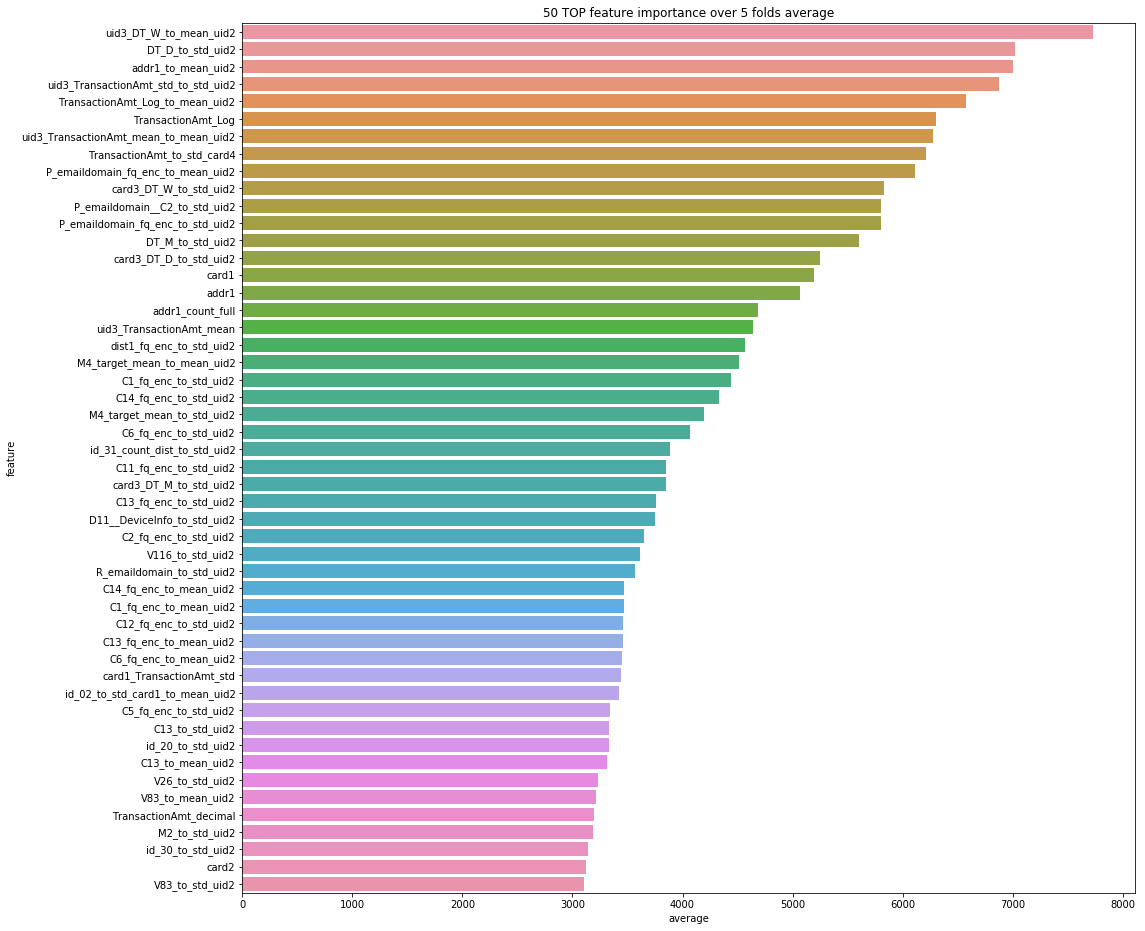

In [171]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [172]:
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=40, num_boost_round=1578, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

TransactionAmt uid2
ProductCD uid2
card1 uid2
card2 uid2
card3 uid2
card4 uid2
card5 uid2
card6 uid2
addr1 uid2
addr2 uid2
dist1 uid2
dist2 uid2
P_emaildomain uid2
R_emaildomain uid2
C1 uid2
C2 uid2
C3 uid2
C4 uid2
C5 uid2
C6 uid2
C7 uid2
C8 uid2
C9 uid2
C10 uid2
C11 uid2
C12 uid2
C13 uid2
C14 uid2
D1 uid2
D2 uid2
D3 uid2
D4 uid2
D5 uid2
D6 uid2
D7 uid2
D8 uid2
D9 uid2
D10 uid2
D11 uid2
D12 uid2
D13 uid2
D14 uid2
D15 uid2
M1 uid2
M2 uid2
M3 uid2
M4 uid2
M5 uid2
M6 uid2
M7 uid2
M8 uid2
M9 uid2
V1 uid2
V2 uid2
V3 uid2
V4 uid2
V5 uid2
V6 uid2
V7 uid2
V8 uid2
V9 uid2
V10 uid2
V11 uid2
V12 uid2
V13 uid2
V14 uid2
V15 uid2
V16 uid2
V17 uid2
V18 uid2
V19 uid2
V20 uid2
V21 uid2
V22 uid2
V23 uid2
V24 uid2
V25 uid2
V26 uid2
V27 uid2
V28 uid2
V29 uid2
V30 uid2
V31 uid2
V32 uid2
V33 uid2
V34 uid2
V35 uid2
V36 uid2
V37 uid2
V38 uid2
V39 uid2
V40 uid2
V41 uid2
V42 uid2
V43 uid2
V44 uid2
V45 uid2
V46 uid2
V47 uid2
V48 uid2
V49 uid2
V50 uid2
V51 uid2
V52 uid2
V53 uid2
V54 uid2
V55 uid2
V56 uid2
V57 uid

In [180]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('ieee_clean_numagg.csv', index=False)

In [ ]:
from sklearn.utils import class_weight
from catboost import CatBoostClassifier

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 y)

clf = CatBoostClassifier(iterations=1500,
                           random_state=10,
                           learning_rate=0.08,
                           task_type = "GPU",
                           eval_metric= 'AUC', 
                           scale_pos_weight = sum(y[y==0])/sum(y[y==1])/5.,
#                            one_hot_max_size = 4,
#                            has_time=True,
#                            min_data_in_leaf=5,
                           early_stopping_rounds = 50,
                          )

clf_cb.fit(X, y, verbose=True)

probs = clf_cb.predict_proba(test, verbose=1)

In [ ]:
preds_catboost = pd.DataFrame(probs[:, 1])
sub_cb = pd.read_csv('ieee/sample_submission.csv')
sub_cb['isFraud'] = preds_catboost

In [ ]:
sub_blend_cb_lgb = pd.read_csv('ieee/sample_submission.csv')
sub_blend_cb_lgb['isFraud'] = sub_cb['isFraud'].values*0.2 + sub['isFraud'].values*0.8

In [ ]:
sub_blend_cb_lgb.to_csv('ieee_cis_fraud_detection_v4_cb_lgb.csv', index=False)

In [ ]:
from keras.layers import Concatenate, Input, Dense, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import  Adam
import keras.backend as k

def make_model():
    k.clear_session()

#     categorical_inputs = []
#     for cat in categorical:
#         categorical_inputs.append(Input(shape=[1], name=cat))

#     categorical_embeddings = []
#     for i, cat in enumerate(categorical):
#         categorical_embeddings.append(
#             Embedding(category_counts[cat], int(np.log1p(category_counts[cat]) + 1), name = cat + "_embed")(categorical_inputs[i]))

#     categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(.1)(cat_emb)) for cat_emb in categorical_embeddings])
# #     categorical_logits = Dropout(.5)(categorical_logits)

    numerical_inputs = Input(shape=[X.shape[1]], name = 'numerical')
    numerical_logits = Dropout(.1)(numerical_inputs)
  
    x = Concatenate()([
#         categorical_logits, 
        numerical_logits,
    ])
#     x = categorical_logits
#     x = BatchNormalization()(x)


    x = Dense(200, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dropout(.2)(x)
    out = Dense(1, activation = 'sigmoid')(x)
    

    model = Model(inputs= [numerical_inputs],outputs=out)
    loss = "binary_crossentropy"
    model.compile(optimizer=Adam(lr = 0.01), loss = loss)
    return model

In [ ]:
nn = make_model()
nn.fit(X, y, validation_data = (X_valid,y_valid), batch_size = 8000, epochs = 1, verbose = 1)
        valid_preds = model.predict(X_valid, batch_size = 8000, verbose = True)
        score = roc_auc_score(y_valid, valid_preds)

In [ ]:
probs = nn.predict_proba(test, verbose=1)

# Experiments

## mean target encoding

## если разница между предсказанием и таргетом большая, выкинуть из обучения?

In [ ]:
# X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
# X.drop('Date', axis=1, inplace=True)

In [ ]:
# train_preds = clf.predict(X)

In [ ]:
# df_diff = pd.DataFrame(np.abs(train['isFraud'] - train_preds).sort_values(ascending=False))

In [ ]:
# oof_threshold = []
# for threshold in [0.8, 0.9, 0.95]:
    
    

#     X = train.loc[df_diff[df_diff['isFraud'] < threshold].index].sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
#     y = train.loc[df_diff[df_diff['isFraud'] < threshold].index].sort_values('TransactionDT')['isFraud']
# #     test = test#.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

#     X.drop('Date', axis=1, inplace=True)
#     # test.drop('Date', axis=1, inplace=True)

#     params = {'num_leaves': 500, 'min_child_weight': 0.03454472573214212,  'feature_fraction': 0.3797454081646243, 
#           'bagging_fraction': 0.4181193142567742, 'min_data_in_leaf': 106, 'objective': 'binary',  
#           'max_depth': -1, 'learning_rate': 0.05, "boosting_type": "gbdt",  "bagging_seed": 11,   
#           "metric": 'auc',  "verbosity": -1, 'reg_alpha': 0.3899927210061127,'reg_lambda': 0.6485237330340494, 
#           'random_state': 47, 'n_jobs':30         }
    
#     oof = fast_estimation(test, X, y, params)
#     print(threshold, oof)
#     oof_threshold.append(oof)

In [ ]:
# X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
# y = train.sort_values('TransactionDT')['isFraud']
# #     test = test#.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

# X.drop('Date', axis=1, inplace=True)
# # test.drop('Date', axis=1, inplace=True)

# params = {'num_leaves': 500, 'min_child_weight': 0.03454472573214212,  'feature_fraction': 0.3797454081646243, 
#       'bagging_fraction': 0.4181193142567742, 'min_data_in_leaf': 106, 'objective': 'binary',  
#       'max_depth': -1, 'learning_rate': 0.05, "boosting_type": "gbdt",  "bagging_seed": 11,   
#       "metric": 'auc',  "verbosity": -1, 'reg_alpha': 0.3899927210061127,'reg_lambda': 0.6485237330340494, 
#       'random_state': 47, 'n_jobs':30         }

# oof = fast_estimation(test, X, y, params)
# print(threshold, oof)
# oof_threshold.append(oof)

## откалибровать переменные на уровень таргета (прогнать через логрег с одной переменной) и заполнить пропуски средним таргетом